<a href="https://colab.research.google.com/github/Gh5al/VAT_ITA_classification/blob/data_aug/nlp_pw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import torch
from sklearn.model_selection import train_test_split
import random
import gc
import transformers
from tqdm import tqdm, trange
from typing import Callable, Dict, List, Tuple
from timeit import default_timer as timer
from transformers import EncoderDecoderModel, AutoTokenizer, PreTrainedTokenizer, BatchEncoding, AutoModel
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, WeightedRandomSampler
import os
import json

In [3]:
device = torch.device('cuda')

In [5]:
!pip install nlpaug
!pip install -U deep-translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.3 MB/s eta 0:00:00


In [5]:
import nltk
nltk.download('wordnet',"/kaggle/working/")
nltk.data.path.append("/kaggle/working/");

[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
import nlpaug.augmenter.word as naw
aug = naw.ContextualWordEmbsAug(
    model_path='bert-large-cased', action="insert")
#aug = naw.SynonymAug()
text = 'This a project work'

augmented_text = aug.augment(text)
augmented_text

2025-02-15 09:35:08.970398: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-15 09:35:08.970512: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-15 09:35:09.107416: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

['This causes a small project work']

# Loading data

In [7]:
def uniform(el):

    """

    Handles the values for multi-value attributes, splitting to list if necessary

    If the input is a list or transformed to a list, values are sorted



    Args:

        el (str or list): The attribute value



    Returns:

        str or list: The attribute value sorted if it is a list, the attribute value otherwise

    """

    if el == el:  # NaN is different from NaN, np.isnan and pd.isna don't work

        if '|' in el:

            el = sorted(el.split('|'))

        elif isinstance(el, list):

            el = sorted(el)

    return el



DATAFRAMES_PATH = '/kaggle/input/nlp-pw' if os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') else './Dataframes'



def create_df_annotations(path: str, language: str, dataset: str):

    """

    Load the dataset + create and save to file a dataframe with the annotations of the arguments.



    Args:

        path (str): path of the folder containing the JSON files

        dataset (str): One of [vat, tp, ecj]

    """



    pkl_file_path = f"{DATAFRAMES_PATH}/arg_annotations_{language}_{dataset}.pkl.xz"

    if os.path.isfile(pkl_file_path):

        print(f"Found pkl, loading it - {pkl_file_path}")

        return pd.read_pickle(pkl_file_path)



    print(f"Could not find pkl, reading dataset - {pkl_file_path}")

    temp = []

    files = os.listdir(path)

    files.sort()



    for filename in files:

        if not filename.endswith('.json'):

            print(f"Skipping '{filename}'")

        else:

            print(f"Loading '{filename}'")

            with open(os.path.join(path, filename), 'r', encoding='utf8') as f:

                data = json.load(f)

                annotations = data["annotations"]

                last_full_chain_id = None

                last_text = None



                for annotation in annotations:

                    if annotation["name"] != 'conc' and annotation["name"] != 'prem':

                        continue # Ignore intro, nreg, judoff, ...

                    #document = annotation["document"]

                    document = data["document"]["name"]

                    name = annotation["name"]

                    _id = annotation["_id"]

                    argument_chain_id = _id[0]

                    full_chain_id = f'{document}_{argument_chain_id}'

                    last_full_chain_id = full_chain_id

                    incremental_num = _id[1:]

                    text = data["document"]["plainText"][int(annotation["start"]):int(annotation["end"])]

                    last_text = text

                    # attribute extraction, NaN if that attribute is not present

                    T = uniform(annotation["attributes"].get("T", np.nan))

                    SUP = uniform(annotation["attributes"].get("SUP", np.nan))

                    SFF = uniform(annotation["attributes"].get("SFF", np.nan))

                    ATT = uniform(annotation["attributes"].get("ATT", np.nan))

                    INH = uniform(annotation["attributes"].get("INH", np.nan))

                    REPH = uniform(annotation["attributes"].get("REPH", np.nan))

                    S = uniform(annotation["attributes"].get("S", np.nan))



                    text = text.replace('\n','').lstrip('‘’\'\n0123456789.-–…;;) ').rstrip('‘’\'\n.;; ')



                    previous = last_text if last_full_chain_id == full_chain_id else None

                    temp.append([

                        document, name, _id, argument_chain_id, incremental_num, text, T, SUP, SFF, ATT, INH, REPH, S, full_chain_id, previous,

                    ])

    # df creation

    df = pd.DataFrame(temp, columns=[

            'Document', 'Name', 'Id', 'Chain', 'Num', 'Text', 'Type', 'SUP', 'SFF', 'ATT', 'INH', 'REPH', 'Scheme', 'FullChainID', 'Previous'

        ])



    print(f"Saving {len(df)} annotations to {pkl_file_path}")

    df.to_pickle(pkl_file_path)

    df.to_csv(pkl_file_path.replace('.pkl.xz', '.csv'))

    return df





df = create_df_annotations('Data/Dataset/VAT_ITA', 'italian', 'vat')


Found pkl, loading it - /kaggle/input/nlp-pw/arg_annotations_italian_vat.pkl.xz


In [8]:
df.describe()

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous
count,3311,3311,3311,3311,3311,3311,2910,1088,82,66,25,89,1314,3311,3311
unique,225,2,264,10,98,3163,3,428,48,32,19,31,63,367,3186
top,2016_202_VAT_OPAM_2_1_PS_AN,prem,A2,A,2,,F,A2,A7,A8,A10,A1,Rule,2016_202_VAT_OPAM_2_1_PS_AN_A,
freq,79,2910,221,2348,365,12,1572,54,6,8,3,29,349,79,12


In [9]:
df.head(10)

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A1,A,1,"In via preliminare, il Collegio prende in cons...",F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"In via preliminare, il Collegio prende in con..."
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,NaN,NaN,Rule,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'..."
2,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei...,L,NaN,NaN,NaN,NaN,NaN,Itpr,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,Se il ricorso non è stato\n proposto da o ...
3,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A4,A,4,Nel caso di specie solo la ILDS ha presentato ...,F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,Nel caso di specie solo la ILDS ha presentato...
4,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A5,A,5,come espressamente richiesto nel ricorso in...,F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,come\n espressamente richiesto nel ricorso...
5,2013_40_VAT_OPAM_2_REM_MB_PS_AN,conc,A6,A,6,"Poiché ciò non è avvenuto, risulta applicabile...",NaN,"[A1, A2, A3]","[A4, A5]",NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"\n Poiché ciò non è avvenuto, risulta appl..."
6,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A1,A,1,Secondo condivisa e costante giurisprudenza (C...,L,NaN,NaN,NaN,NaN,NaN,Rule,2018_847_VAT_OP_2_-1_MB_AF_AN_A,Secondo condivisa e costante giurisprudenza (C...
7,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A2,A,2,"Tuttavia, nel caso qui in esame, la Comm/ne no...",L,"[A3, A4]",NaN,NaN,NaN,NaN,Itpr,2018_847_VAT_OP_2_-1_MB_AF_AN_A,"Tuttavia, nel caso qui in esame, la Comm/ne no..."
8,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A3,A,3,A tal proposito si ricorda che la Corte cost. ...,L,NaN,NaN,NaN,NaN,NaN,Prec,2018_847_VAT_OP_2_-1_MB_AF_AN_A,A tal proposito si ricorda che la Corte cost. ...
9,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A4,A,4,Inoltre (Cass. 2.9.2013 n. 20064) “qualora la ...,L,NaN,NaN,NaN,NaN,NaN,Prec,2018_847_VAT_OP_2_-1_MB_AF_AN_A,Inoltre (Cass. 2.9.2013 n. 20064) “qualora la ...


Example of row with multiple attribute values:

In [10]:
df[df["FullChainID"] == "2021_2717_VAT_OPAM_2_1_FG_PS_AN_A"]

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous
3213,2021_2717_VAT_OPAM_2_1_FG_PS_AN,conc,A1,A,1,Passando all'esame del motivo di appello con c...,NaN,A13,NaN,NaN,NaN,NaN,NaN,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,Passando all'esame del motivo di appello con c...
3214,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A2,A,2,"Sul punto, come è noto, giova ricordare che la...",L,NaN,NaN,NaN,NaN,NaN,Princ,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,"Sul punto, come è noto, giova ricordare che la..."
3215,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A3,A,3,"Con riguardo al primo profilo, dall'esame degl...","[F, L]",NaN,NaN,NaN,NaN,NaN,Rule,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,"Con riguardo al primo profilo, dall'esame degl..."
3216,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A4,A,4,Per quanto riguarda il secondo profilo (come r...,F,"[A5, A6]",NaN,NaN,NaN,NaN,NaN,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,Per quanto riguarda il secondo profilo (come r...
3217,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A5,A,5,"Infatti, secondo la corretta interpretazione d...",L,NaN,NaN,NaN,NaN,NaN,Rule,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,"Infatti, secondo la corretta interpretazione d..."
3218,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A6,A,6,"Ed ancora, le suddette disposizioni vanno inte...",L,NaN,NaN,NaN,NaN,NaN,Prec,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,"Ed ancora, le suddette disposizioni vanno inte..."
3219,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A7,A,7,"Pertanto, tutti i motivi di appello dell'Uffic...",F,"[A2, A3, A4]",NaN,NaN,NaN,NaN,NaN,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,"Pertanto, tutti i motivi di appello dell'Uffic..."
3220,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A8,A,8,"Inoltre, nel caso specifico va sottolineato il...",F,NaN,NaN,NaN,NaN,NaN,NaN,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,"Inoltre, nel caso specifico va sottolineato il..."
3221,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A9,A,9,Per quanto riguarda gli ulteriori motivi con i...,F,NaN,NaN,NaN,NaN,NaN,NaN,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,Per quanto riguarda gli ulteriori motivi con i...
3222,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A10,A,10,In proposito giova ricordare che l’inesistenza...,"[F, L]",NaN,NaN,NaN,NaN,NaN,"[Prec, Rule]",2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,In proposito giova ricordare che l’inesistenza...


# Preproccesing

## Removing NaN values

Check whether there are any null values for ARGUMENT CLASSIFICATION(AC) task (Name column), and if it's the case then drop them:

In [11]:
df_ac = df[~(df['Name'].isnull())].reset_index(drop=True)

df_ac['Name'].unique()

array(['prem', 'conc'], dtype=object)

Check whether there are any null values for TYPE CLASSIFICATION(TC) task (Type column), and if it's the case then drop them

In [12]:
df_tc = df_ac[~(df_ac['Type'].isnull())].reset_index(drop=True)

df_tc.describe()

df_tc['Type'].drop_duplicates()


0          F
1          L
13    [F, L]
Name: Type, dtype: object

Check whether there are any null values for SCHEME CLASSIFICATION(SC) task (Scheme column), and if it's the case then drop them

In [13]:
df_sc = df_tc[~(df_tc['Scheme'].isnull())].reset_index(drop=True)

#print(df_sc.describe())

df_sc['Scheme'].drop_duplicates()

0                      Rule
1                      Itpr
4                      Prec
15             [Itpr, Prec]
21                      Aut
               ...         
1223    [Class, Itpr, Rule]
1240           [Acon, Itpr]
1241          [Class, Tele]
1276     [Prec, Rule, Syst]
1282     [Aut, Itpr, Princ]
Name: Scheme, Length: 63, dtype: object

In [14]:
#remove excessive white spaces from text column
import re
def remove_whitespace(text):
    t = re.sub(' +', ' ', text)
    return t

df_sc['Text'] =df_sc['Text'].map(remove_whitespace)
df_sc['Text'][1]


"Se il ricorso non è stato proposto da o nei confronti di tutti i soggetti sopra indicati deve essere ordinata l'integrazione del contraddittorio mediante la loro chiamata in causa entro un termine stabilito a pena di decadenza"

In [15]:
df_ac.describe().drop('top',axis=0)

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous
count,3311,3311,3311,3311,3311,3311,2910,1088,82,66,25,89,1314,3311,3311
unique,225,2,264,10,98,3163,3,428,48,32,19,31,63,367,3186
freq,79,2910,221,2348,365,12,1572,54,6,8,3,29,349,79,12


In [16]:
df_tc.describe().drop('top',axis=0)

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous
count,2910,2910,2910,2910,2910,2910,2910,691,42,66,25,20,1314,2910,2910
unique,225,1,255,10,95,2797,3,299,28,32,19,16,63,367,2812
freq,78,2910,214,2094,347,11,1572,30,4,8,3,2,349,78,11


In [17]:
df_sc.describe().drop('top', axis=0)

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous
count,1314,1314,1314,1314,1314,1314,1314,272,14,9,14,3,1314,1314,1314
unique,203,1,164,10,62,1241,3,129,11,7,13,3,63,309,1260
freq,41,1314,103,944,174,3,1000,15,2,2,2,1,349,41,3


## Argument classification Label Encoder

In [18]:
#df_ac['label'] = df_ac.Name.map({'prem': 0, 'conc': 1})

In [19]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df_ac['label'] = le.fit_transform(df_ac['Name'])

le.classes_

le.inverse_transform([0,1])

array(['conc', 'prem'], dtype=object)

In [20]:
df_ac['label'].unique()

array([1, 0])

In [21]:
df_ac['Name'].unique()

array(['prem', 'conc'], dtype=object)

<Axes: >

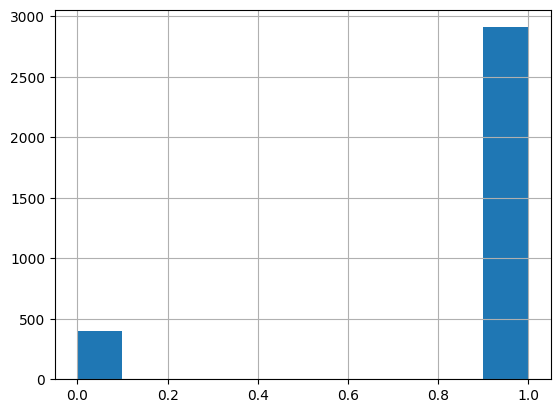

In [22]:
df_ac['label'].hist()

## Type classification multi-label-binarizer

In [23]:
df_tc.loc[13,'Type']

['F', 'L']

In [24]:
#need to extract the values from the list, in a way to pass it to the multilabelbinarizer

for i in range(len(df_tc)):

    x = df_tc.loc[i,'Type']

    if type(x) == list:

        df_tc.loc[i,'Type'] = ",".join([x[0],x[1]])


In [25]:
df_tc.loc[13,'Type']

'F,L'

In [26]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

mlb_result = mlb.fit_transform([str(df_tc.loc[i,'Type']).split(',') for i in range(len(df_tc))])

df_tc_final = pd.concat([df_tc,pd.DataFrame(mlb_result,columns=list(mlb.classes_))],axis=1)

df_tc_final

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous,F,L
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A1,A,1,"In via preliminare, il Collegio prende in cons...",F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"In via preliminare, il Collegio prende in con...",1,0
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,NaN,NaN,Rule,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'...",0,1
2,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei...,L,NaN,NaN,NaN,NaN,NaN,Itpr,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,Se il ricorso non è stato\n proposto da o ...,0,1
3,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A4,A,4,Nel caso di specie solo la ILDS ha presentato ...,F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,Nel caso di specie solo la ILDS ha presentato...,1,0
4,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A5,A,5,come espressamente richiesto nel ricorso in...,F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,come\n espressamente richiesto nel ricorso...,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2905,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C15,C,15,Sotto questo profilo i Compro Oro sono sottopo...,L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,Sotto questo profilo i Compro Oro sono sottopo...,0,1
2906,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C16,C,16,Tale comunicazione ha luogo quando i destinata...,L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,Tale comunicazione ha luogo quando i destinata...,0,1
2907,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C17,C,17,"Il Ministro dell'interno, con decreto del 17 f...",L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,"Il Ministro dell'interno, con decreto del 17 f...",0,1
2908,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,NaN,NaN,"[Class, Rule]",2021_6075_VAT_OPAM_2_1_PS_AN_C,Tra i soggetti destinatari del decreto sono ri...,0,1


In [27]:
df_tc_labels = df_tc_final[['F','L']]

df_tc_labels

,F,L
0,1,0
1,0,1
2,0,1
3,1,0
4,1,0
...,...,...
2905,0,1
2906,0,1
2907,0,1
2908,0,1


## Scheme classification multi-label-binarizer

In [28]:
#need to extract the values from the list, so convert to string, in order to pass them to the multilabelbinarizer

def clean_list(df_sc, column_name):
    for i in range(len(df_sc)):

        x = df_sc.loc[i,column_name]
        if type(x) == list:
            df_sc.loc[i,str(column_name) + "2"] = ",".join(x)
        else:
            try:
                df_sc.loc[i,str(column_name) + "2"] = x
            except:
                print(i,x)
    return df_sc
df_sc = clean_list(df_sc,'Scheme')
df_sc

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous,Scheme2
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,NaN,NaN,Rule,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'...",Rule
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei co...,L,NaN,NaN,NaN,NaN,NaN,Itpr,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,Se il ricorso non è stato\n proposto da o ...,Itpr
2,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A1,A,1,Secondo condivisa e costante giurisprudenza (C...,L,NaN,NaN,NaN,NaN,NaN,Rule,2018_847_VAT_OP_2_-1_MB_AF_AN_A,Secondo condivisa e costante giurisprudenza (C...,Rule
3,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A2,A,2,"Tuttavia, nel caso qui in esame, la Comm/ne no...",L,"[A3, A4]",NaN,NaN,NaN,NaN,Itpr,2018_847_VAT_OP_2_-1_MB_AF_AN_A,"Tuttavia, nel caso qui in esame, la Comm/ne no...",Itpr
4,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A3,A,3,A tal proposito si ricorda che la Corte cost. ...,L,NaN,NaN,NaN,NaN,NaN,Prec,2018_847_VAT_OP_2_-1_MB_AF_AN_A,A tal proposito si ricorda che la Corte cost. ...,Prec
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C15,C,15,Sotto questo profilo i Compro Oro sono sottopo...,L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,Sotto questo profilo i Compro Oro sono sottopo...,Rule
1310,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C16,C,16,Tale comunicazione ha luogo quando i destinata...,L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,Tale comunicazione ha luogo quando i destinata...,Rule
1311,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C17,C,17,"Il Ministro dell'interno, con decreto del 17 f...",L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,"Il Ministro dell'interno, con decreto del 17 f...",Rule
1312,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,NaN,NaN,"[Class, Rule]",2021_6075_VAT_OPAM_2_1_PS_AN_C,Tra i soggetti destinatari del decreto sono ri...,"Class,Rule"


In [29]:
a = df_sc.explode(['Scheme'])
sc_label_count = a['Scheme'].value_counts()
remove_c = sc_label_count[sc_label_count < 15]
list(remove_c.index)


['Lit', 'Abs', 'Psy', 'Acon']

In [30]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

mlb_result = mlb.fit_transform([str(df_sc.loc[i,'Scheme2']).split(',') for i in range(len(df_sc))])

df_sc_final1 = pd.concat([df_sc,pd.DataFrame(mlb_result,columns=list(mlb.classes_))],axis=1)

df_sc_final1

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,...,Aut,Class,Itpr,Lit,Prec,Princ,Psy,Rule,Syst,Tele
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei co...,L,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
2,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A1,A,1,Secondo condivisa e costante giurisprudenza (C...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
3,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A2,A,2,"Tuttavia, nel caso qui in esame, la Comm/ne no...",L,"[A3, A4]",NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
4,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A3,A,3,A tal proposito si ricorda che la Corte cost. ...,L,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C15,C,15,Sotto questo profilo i Compro Oro sono sottopo...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1310,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C16,C,16,Tale comunicazione ha luogo quando i destinata...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1311,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C17,C,17,"Il Ministro dell'interno, con decreto del 17 f...",L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1312,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,...,0,1,0,0,0,0,0,1,0,0


In [31]:
sc_classes = mlb.classes_

sc_classes

array(['Abs', 'Acon', 'Aut', 'Class', 'Itpr', 'Lit', 'Prec', 'Princ',
       'Psy', 'Rule', 'Syst', 'Tele'], dtype=object)

In [32]:
df_sc_labels = df_sc_final1[mlb.classes_]

df_sc_labels

,Abs,Acon,Aut,Class,Itpr,Lit,Prec,Princ,Psy,Rule,Syst,Tele
0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1309,0,0,0,0,0,0,0,0,0,1,0,0
1310,0,0,0,0,0,0,0,0,0,1,0,0
1311,0,0,0,0,0,0,0,0,0,1,0,0
1312,0,0,0,1,0,0,0,0,0,1,0,0


In [33]:
#mlb.inverse_transform(np.array(df_sc_labels))

In [34]:
sc_label_count = df_sc_labels.sum().sort_values(ascending=False)

sc_label_count

Rule     575
Prec     419
Itpr     314
Princ    144
Class    100
Aut       72
Syst      28
Tele      18
Lit       12
Abs        8
Psy        7
Acon       1
dtype: int64

<BarContainer object of 12 artists>

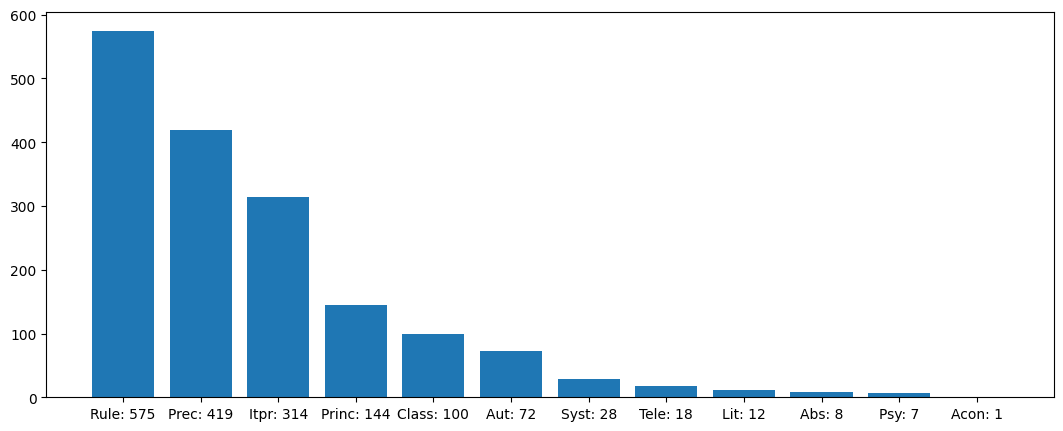

In [35]:
y = np.array(sc_label_count)

#x = np.array(sc_label_count.index)

#added values on x only for convenience

x = [sc_label_count.index[i] + ': ' + str(sc_label_count.iloc[i]) for i in range(len(sc_label_count))]

plt.figure(figsize=(13,5))

plt.bar(x, height=y)

In [36]:
bad_sc_classes = sc_label_count.index[sc_label_count < 15]

sc_classes = sc_label_count.index[sc_label_count >= 15]

print("Removing classes with low number of instances: "+', '.join(bad_sc_classes))

print("Keeping classes with good number of instances: "+', '.join(sc_classes))

good_sc_columns = np.setdiff1d(sc_classes, bad_sc_classes)

print("Remaining columns: "+', '.join(good_sc_columns))

#df_sc_final = df_sc_final1[~df_sc_final1["Scheme2"].isin(bad_sc_classes)].drop(bad_sc_classes,axis=1).reset_index(drop=True)
df_sc_final1

Removing classes with low number of instances: Lit, Abs, Psy, Acon
Keeping classes with good number of instances: Rule, Prec, Itpr, Princ, Class, Aut, Syst, Tele
Remaining columns: Aut, Class, Itpr, Prec, Princ, Rule, Syst, Tele


,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,...,Aut,Class,Itpr,Lit,Prec,Princ,Psy,Rule,Syst,Tele
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei co...,L,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
2,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A1,A,1,Secondo condivisa e costante giurisprudenza (C...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
3,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A2,A,2,"Tuttavia, nel caso qui in esame, la Comm/ne no...",L,"[A3, A4]",NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
4,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A3,A,3,A tal proposito si ricorda che la Corte cost. ...,L,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C15,C,15,Sotto questo profilo i Compro Oro sono sottopo...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1310,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C16,C,16,Tale comunicazione ha luogo quando i destinata...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1311,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C17,C,17,"Il Ministro dell'interno, con decreto del 17 f...",L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1312,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,...,0,1,0,0,0,0,0,1,0,0


In [37]:
#df_sc_final['Scheme'].isin(['Acon'])
#updated version, now we are also considering the list type elements
def remove_bad_classes(df_sc,bad_sc_classes):
    df = df_sc
    for i in range(len(df_sc)):
        x = df.loc[i,'Scheme']
        if type(x) == list:
            for q in x:
                if q in bad_sc_classes:
                    #print(x, q)
                    df = df.drop([i])
                    break
        elif x in bad_sc_classes:
            df = df.drop([i])
    df = df.drop(bad_sc_classes,axis=1).reset_index(drop=True)
    return df
df_r = remove_bad_classes(df_sc_final1,bad_sc_classes)
df_sc_final = df_r
df_sc_final.columns

Index(['Document', 'Name', 'Id', 'Chain', 'Num', 'Text', 'Type', 'SUP', 'SFF',
       'ATT', 'INH', 'REPH', 'Scheme', 'FullChainID', 'Previous', 'Scheme2',
       'Aut', 'Class', 'Itpr', 'Prec', 'Princ', 'Rule', 'Syst', 'Tele'],
      dtype='object')

In [38]:
df_sc_labels

,Abs,Acon,Aut,Class,Itpr,Lit,Prec,Princ,Psy,Rule,Syst,Tele
0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1309,0,0,0,0,0,0,0,0,0,1,0,0
1310,0,0,0,0,0,0,0,0,0,1,0,0
1311,0,0,0,0,0,0,0,0,0,1,0,0
1312,0,0,0,1,0,0,0,0,0,1,0,0


In [39]:
df_sc_final1.iloc[384]

Document                            2018_288_VAT_OP_2_0_AP_MB_AN
Name                                                        prem
Id                                                            A6
Chain                                                          A
Num                                                            6
Text           Il legislatore tributario, a fronte del princi...
Type                                                           L
SUP                                                          NaN
SFF                                                          NaN
ATT                                                          NaN
INH                                                          NaN
REPH                                                         NaN
Scheme                                                       Psy
FullChainID                       2018_288_VAT_OP_2_0_AP_MB_AN_A
Previous       Il legislatore tributario, a fronte del\n     ...
Scheme2                  

In [40]:
tr = df_sc_final.explode('Scheme')
#df_sc_final[df_sc_final['Scheme'].explode().isin(['Acon'])]
tr.drop(good_sc_columns,axis=1)

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous,Scheme2
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,NaN,NaN,Rule,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'...",Rule
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei co...,L,NaN,NaN,NaN,NaN,NaN,Itpr,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,Se il ricorso non è stato\n proposto da o ...,Itpr
2,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A1,A,1,Secondo condivisa e costante giurisprudenza (C...,L,NaN,NaN,NaN,NaN,NaN,Rule,2018_847_VAT_OP_2_-1_MB_AF_AN_A,Secondo condivisa e costante giurisprudenza (C...,Rule
3,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A2,A,2,"Tuttavia, nel caso qui in esame, la Comm/ne no...",L,"[A3, A4]",NaN,NaN,NaN,NaN,Itpr,2018_847_VAT_OP_2_-1_MB_AF_AN_A,"Tuttavia, nel caso qui in esame, la Comm/ne no...",Itpr
4,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A3,A,3,A tal proposito si ricorda che la Corte cost. ...,L,NaN,NaN,NaN,NaN,NaN,Prec,2018_847_VAT_OP_2_-1_MB_AF_AN_A,A tal proposito si ricorda che la Corte cost. ...,Prec
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C16,C,16,Tale comunicazione ha luogo quando i destinata...,L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,Tale comunicazione ha luogo quando i destinata...,Rule
1284,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C17,C,17,"Il Ministro dell'interno, con decreto del 17 f...",L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,"Il Ministro dell'interno, con decreto del 17 f...",Rule
1285,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,NaN,NaN,Class,2021_6075_VAT_OPAM_2_1_PS_AN_C,Tra i soggetti destinatari del decreto sono ri...,"Class,Rule"
1285,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,Tra i soggetti destinatari del decreto sono ri...,"Class,Rule"


In [41]:
df_sc_labels = df_sc_final[good_sc_columns]
df_sc_labels

,Aut,Class,Itpr,Prec,Princ,Rule,Syst,Tele
0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
1282,0,0,0,0,0,1,0,0
1283,0,0,0,0,0,1,0,0
1284,0,0,0,0,0,1,0,0
1285,0,1,0,0,0,1,0,0


# Data analysis

<Axes: >

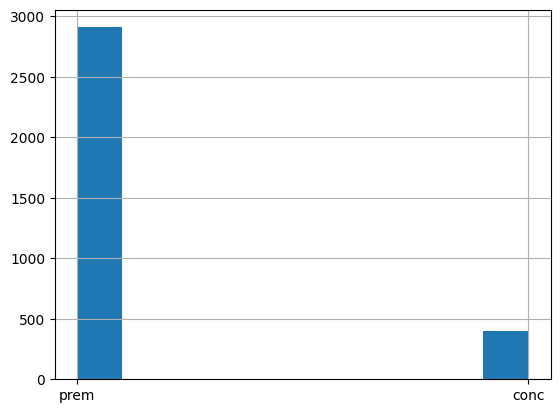

In [42]:
df_ac['Name'].hist()

In [43]:
print(f"There are {len(df_ac[df_ac['Name'] == 'prem'])} premises and {len(df_ac[df_ac['Name'] == 'conc'])} conclusions")

There are 2910 premises and 401 conclusions


<BarContainer object of 2 artists>

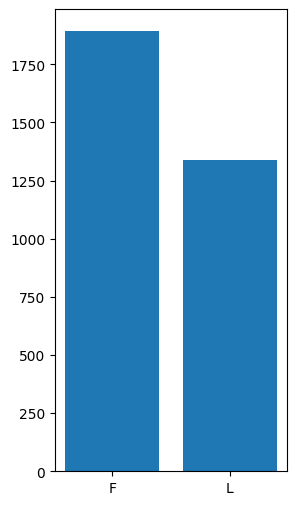

In [44]:
values = df_tc_labels.sum().sort_values(ascending=False)

y = np.array(values)

x = np.array(values.index)



plt.figure(figsize=(3,6))

plt.bar(x, height=y)

# Fixing seed

In [45]:
# Fix the random state for reproducibility

SEED = 27



def fix_seed(seed: int) -> None:

    """Fix all the possible sources of randomness.



    Args:

        seed: the seed to use.

    """

    np.random.seed(seed)

    random.seed(seed)

    torch.manual_seed(seed)

    torch.cuda.manual_seed(seed)



    torch.backends.cudnn.benchmark = False

    torch.backends.cudnn.deterministic = True

[ ]





fix_seed(SEED)

# Utils

## Train-Val-Test dataset splitting

In [46]:
def split_dataset(df, test_size=0.2):

    total_samples = df.shape[0]

    idx_train, idx_test = train_test_split(df['Document'].unique(),

                                      random_state=SEED,

                                      test_size=test_size)

    idx_train, idx_val = train_test_split(idx_train,

                                      random_state=SEED,

                                      test_size=idx_test.shape[0])

    df_train = df[df['Document'].isin(idx_train)]

    df_val = df[df['Document'].isin(idx_val)]

    df_test = df[df['Document'].isin(idx_test)]

    print('Number of training samples: {} ({}%)'.format(df_train.shape[0], 100*df_train.shape[0]/total_samples))

    print('Number of validation examples: {} ({}%)'.format(df_val.shape[0], 100*df_val.shape[0]/total_samples))

    print('Number of test samples: {} ({}%)'.format(df_test.shape[0], 100*df_test.shape[0]/total_samples))

    return df_train, df_val, df_test

In [47]:
from skmultilearn.model_selection import iterative_train_test_split
def iterative_split(df_sc_final, df_sc_labels,test_size=0.15):
    X = np.expand_dims(df_sc_final.index.values,1)
    y = df_sc_labels.values
    t_train, y_train, t_test, y_test = iterative_train_test_split(X,y, test_size = 0.2)
    t_train, y_train, t_val, y_val = iterative_train_test_split(t_train, y_train, test_size = 0.15)
    print(np.shape(t_train),np.shape(t_test),np.shape(t_val))
    df_train = df_sc_final.iloc[np.squeeze(t_train)]
    df_val = df_sc_final.iloc[np.squeeze(t_val)]
    df_test = df_sc_final.iloc[np.squeeze(t_test)]
    return df_train,df_val,df_test


In [48]:
df_train,df_val,df_test = iterative_split(df_sc_final,df_sc_labels)


(878, 1) (256, 1) (153, 1)


In [49]:
df_train['Scheme'].explode().value_counts()

Scheme
Rule     388
Prec     282
Itpr     211
Princ     97
Class     68
Aut       49
Syst      19
Tele      12
Name: count, dtype: int64

In [50]:
df_val['Scheme'].explode().value_counts()
df_test['Scheme'].explode().value_counts()

Scheme
Rule     114
Prec      83
Itpr      62
Princ     29
Class     20
Aut       14
Syst       5
Tele       3
Name: count, dtype: int64

In [51]:
#df_train, df_val, df_test=split_dataset(df_sc_final)
df_train1  = df_train.explode('Scheme')
df_train1[df_train1['Scheme2']=='Tele']['Text']

816     I cosiddetti “premi di incentivazione' sono fi...
1218    La ratio, è evidente, è quella di evitare che ...
Name: Text, dtype: object

In [52]:
df_train1['Scheme'].value_counts()

Scheme
Rule     388
Prec     282
Itpr     211
Princ     97
Class     68
Aut       49
Syst      19
Tele      12
Name: count, dtype: int64

In [53]:
count = df_sc_labels.sum().sort_values(ascending=False)
tot=np.array(count.reset_index(drop=True)).sum()
inv_class_fq = count/tot
1/inv_class_fq
class_weights = tot / (count)
class_weights

Rule      2.901754
Prec      3.985542
Itpr      5.335484
Princ    11.566434
Class    16.540000
Aut      22.972222
Syst     61.259259
Tele     97.294118
dtype: float64

## Data Aug with traslation + NLPaug

In [57]:
from deep_translator import GoogleTranslator,ChatGptTranslator,PonsTranslator
#GoogleTranslator(source='auto', target='en').translate("guten Tag")
translator = GoogleTranslator(source = 'italian',target = 'english')
retranslator =  GoogleTranslator(source = 'english',target = 'italian')


In [58]:
translator.translate('ciao')

'HI'

In [59]:
def google_translate(text,translator):
    output = []
    #print(translate_text)
    for t in text:
        translate_text = translator.translate(t)
        output.append(translate_text)
    return output
def google_retranslate(text,translator):
    output = []
    #print(translate_text)
    for t in text:
        translate_text = translator.translate(t)
        output.append(translate_text)
    return output

def augment(aug,text,n=1):
    aug_text = aug.augment(text,n=n)
    #print(f"aug: {aug_text}")
    return aug_text

def translate(model,tokenizer,text):
    model.eval()
    translated = model.generate(**tokenizer(text, return_tensors="pt", padding=True),max_length=256,)
    trans_text = []

    for t in translated:
        z = tokenizer.decode(t, skip_special_tokens=True)
        #print(z)
        trans_text.append(z)
    return trans_text

def retranslate(model,tokenizer,text):
    model.eval()
    retranslated = model.generate(**tokenizer(text, return_tensors="pt", padding=True),max_length=256)
    retrans_text = []
    for t in retranslated:
        z = tokenizer.decode(t, skip_special_tokens=True)
        #print(z)
        retrans_text.append(z)
    return retrans_text

In [61]:
GENERATION = False
if GENERATION:
    new_text = []
    new_target = []
    class_to_aug = ['Princ','Class','Aut','Syst','Tele']
    n_samples = [1,2,3,5,6]
    for ca,n in zip(class_to_aug,n_samples):

        new_df = df_train1[df_train1['Scheme']== ca]['Text']

        for e in new_df:
            #print([e])
            a = google_translate([e],translator)
            #print(a)
            b = augment(aug,a[0],n=n)
            #print(b)
            c = google_retranslate(b,retranslator)
            #print(f'QUI: {c}')
            new_text = new_text + c
        new_target = new_target + [ca]*len(new_df)*n
        print(len(new_text))


In [ ]:
if GENERATION:
    print(pd.DataFrame(new_target).value_counts())

In [111]:
#save generated data to csv file
if GENERATION:
    new_dict ={'Text':new_text,'Scheme':new_target }
    new_dataframe = pd.DataFrame(new_dict)
    new_dataframe.to_csv('aug_data.csv')
    new_dataframe


In [69]:
#read aug data from csv
AUG_PATH = '/kaggle/input/nlp-pw' if os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') else os.getcwd()
new_dataframe = pd.read_csv("".join([AUG_PATH,'/aug_data.csv']))
new_dataframe=new_dataframe.drop('Unnamed: 0',axis=1)
new_dataframe

,Text,Scheme
0,Una volta che l'autorità esecutiva penale abbi...,Princ
1,"7 In realtà, l'intera questione si fonda essen...",Princ
2,Come ha ribadito di recente la Corte Generale ...,Princ
3,Sembrerebbe che la difesa del contribuente int...,Princ
4,Affinché una spesa specifica nella sponsorizza...,Princ
...,...,...
541,Occorre tuttavia anche rilevare che l'obbligo ...,Tele
542,Occorre inoltre precisare che l'obbligo di mot...,Tele
543,Occorre inoltre ulteriormente evidenziare che ...,Tele
544,Va inoltre rilevato che l'obbligo di motivazio...,Tele


In [70]:
#merge dataframes
df1 = df_train[['Text','Scheme']].reset_index(drop=True)
tot_df = pd.concat([df1,new_dataframe],ignore_index=True)
tot_df


,Text,Scheme
0,Se il ricorso non è stato proposto da o nei co...,Itpr
1,Secondo condivisa e costante giurisprudenza (C...,Rule
2,Deve pertanto confermarsi che il ricorso di pr...,Rule
3,"atteso che, siccome correttamente eccepito dal...",Prec
4,La detta norma recepisce nell' ordinamento ita...,Rule
...,...,...
1419,Occorre tuttavia anche rilevare che l'obbligo ...,Tele
1420,Occorre inoltre precisare che l'obbligo di mot...,Tele
1421,Occorre inoltre ulteriormente evidenziare che ...,Tele
1422,Va inoltre rilevato che l'obbligo di motivazio...,Tele


In [71]:
tot_df = clean_list(tot_df,'Scheme')
tot_df
#apply multibinarizer
mlb = MultiLabelBinarizer()
mlb_result = mlb.fit_transform([str(tot_df.loc[i,'Scheme2']).split(',') for i in range(len(tot_df))])
aug_train_df = pd.concat([tot_df,pd.DataFrame(mlb_result,columns=list(mlb.classes_))],axis=1)

aug_train_df



,Text,Scheme,Scheme2,Aut,Class,Itpr,Prec,Princ,Rule,Syst,Tele
0,Se il ricorso non è stato proposto da o nei co...,Itpr,Itpr,0,0,1,0,0,0,0,0
1,Secondo condivisa e costante giurisprudenza (C...,Rule,Rule,0,0,0,0,0,1,0,0
2,Deve pertanto confermarsi che il ricorso di pr...,Rule,Rule,0,0,0,0,0,1,0,0
3,"atteso che, siccome correttamente eccepito dal...",Prec,Prec,0,0,0,1,0,0,0,0
4,La detta norma recepisce nell' ordinamento ita...,Rule,Rule,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1419,Occorre tuttavia anche rilevare che l'obbligo ...,Tele,Tele,0,0,0,0,0,0,0,1
1420,Occorre inoltre precisare che l'obbligo di mot...,Tele,Tele,0,0,0,0,0,0,0,1
1421,Occorre inoltre ulteriormente evidenziare che ...,Tele,Tele,0,0,0,0,0,0,0,1
1422,Va inoltre rilevato che l'obbligo di motivazio...,Tele,Tele,0,0,0,0,0,0,0,1


In [72]:
aug_train_df.explode('Scheme')['Scheme'].value_counts()

Scheme
Rule     388
Prec     282
Itpr     211
Class    204
Aut      196
Princ    193
Syst     114
Tele      84
Name: count, dtype: int64

In [73]:
aug_lab = aug_train_df[sc_classes]
aug_lab

,Rule,Prec,Itpr,Princ,Class,Aut,Syst,Tele
0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
1419,0,0,0,0,0,0,0,1
1420,0,0,0,0,0,0,0,1
1421,0,0,0,0,0,0,0,1
1422,0,0,0,0,0,0,0,1


## Save and load results

The results folder will contain the notebook, metrics and outputs for each seed.

In [74]:
results_folder = "results"

if not os.path.exists(results_folder):

    os.makedirs(results_folder)



def results_to_csv(df_results, seed):

    '''

    Args:

        df_results: DataFrame with the all the scores

        seed: the used seed

    '''

    csv_path = f"{results_folder}/{seed}.csv"

    df_results.to_csv(path_or_buf=csv_path)

In [75]:
def results_from_csv(seed):

    '''

    Args:

        seed: the wanted seed

    '''

    file_path = f"results/{seed}.csv"

    df_results = pd.read_csv(file_path)



    return df_results

## PyTorch dataset

In [76]:
class CustomTorchDataset(Dataset):

    def __init__(self, encodings):

        self.encodings = encodings



    def __getitem__(self, idx):

        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}



    def __len__(self):

        return len(self.encodings.input_ids)

## Focal Loss

In [77]:
num_label=len(good_sc_columns)

class FocalLoss(nn.Module):

    def __init__(self, alpha=None, gamma=2, logit=False, reduce=False):

        super(FocalLoss, self).__init__()

        self.alpha = alpha

        self.gamma = gamma

        self.logit = logit

        self.reduce = reduce



    def forward(self, inputs, targets):

        """

        BCE = nn.BCELoss()

        BCE_loss = BCE(inputs, targets)

        pt = torch.exp(-BCE_loss)

        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss



        if self.reduce:

            return torch.mean(F_loss)

        else:

            return F_loss

        """

        #p = torch.where(targets >= 0.5, inputs, 1-inputs)

        p = inputs * targets + (1 - inputs) * (1 - targets)
        if self.alpha != None:
            weight_mask = torch.where(targets >= 0.5, self.alpha, 1)
        logp = - torch.log(torch.clamp(p, 1e-4, 1-1e-4))
        #loss = logp*((1-p)**self.gamma)
        #print(f"wo_weight:{loss}")
        if self.alpha != None:
            loss = self.alpha*logp*((1-p)**self.gamma)
        else:
            loss = logp*((1-p)**self.gamma)

        #print(f"w_weight:{loss}")



        loss = loss.mean()

        return loss




In [78]:
num_label=len(good_sc_columns)

def focal_loss(logits, targets, gamma=2):

    #l = logits.reshape(-1)

    #t = targets.reshape(-1)

    #p = torch.sigmoid(l)

    p = torch.where(targets >= 0.5, logits, 1-logits)

    logp = - torch.log(torch.clamp(p, 1e-4, 1-1e-4))

    loss = logp*((1-p)**gamma)

    loss = loss.mean()


    return loss

# Processing

## Encoding

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer

import re

from nltk.corpus import stopwords



class BaselineVectorizer():

    def __init__(self, include_previous=False, max_features=None):

        self.tfidf = TfidfVectorizer(stop_words=stopwords.words('italian'),max_features=max_features)

        self.include_previous = include_previous

        self.fitted = False



    def _clean_texts(self,df):

        texts = df["Previous"]+". "+df["Text"] if INCLUDE_PREVIOUS else df["Text"]

        cleaned = []

        for text in texts:

            text = re.sub("[^a-zA-Z0-9]"," ",text).lower().strip()

            cleaned.append(text)



        return cleaned



    def fit(self,df):

        cleaned_texts = self._clean_texts(df)

        self.tfidf.fit(cleaned_texts)

        self.fitted = True



    def transform(self,df):

        if not self.fitted:

            raise Exception("Vectorizer is not fitted.")

        cleaned_texts = self._clean_texts(df)

        return self.tfidf.transform(cleaned_texts)

In [80]:
def encode(tokenizer:PreTrainedTokenizer,
           df:pd.DataFrame,
           labels,
           scheme=False,
           include_previous=True):

    '''

    Encodes the dataset according to the BERT specifications.

    The method encodes the data in the following way:

        [CLS] previous [SEP] current [SEP]

        where -previous- is the previous (if any) sentence in the same argumentation chain

        and -current- is the current sentence

    '''

    print("Encoding...")

    encodings = tokenizer(

          list(df['Previous']), list(df['Text']), padding=True, truncation=True, max_length = 512

        ) if include_previous else tokenizer(

          list(df['Text']), padding=True, truncation=True, max_length = 512

        )



    input_ids, input_attention_mask = encodings['input_ids'], encodings['attention_mask']

    print(f"input shape: {np.shape(input_ids)}")

    if not scheme:

        encodings.update({'labels' : torch.LongTensor(labels.values)})

    else:

        encodings.update({'labels': torch.FloatTensor(labels.values)})

    encodings.pop('token_type_ids')



    print("Encoding complete")

    return encodings

## Model

In [81]:
class ACModel(nn.Module):

    def __init__(self,checkpoint, output_size):

        super(ACModel, self).__init__()

        self.model = AutoModel.from_pretrained(checkpoint)

        self.output_size = output_size

        self.cl1 = nn.Linear(self.model.config.hidden_size, self.model.config.hidden_size)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

        self.output = nn.Linear(self.model.config.hidden_size, self.output_size)



    def forward(self, input_ids, attention_mask,only_embeddings=False):

        output  = self.model(input_ids, attention_mask=attention_mask, output_hidden_states=True)

        pooler_output = output.pooler_output

        x = self.cl1(pooler_output)

        x = self.relu(x)

        x = self.output(x)
        if only_embeddings:
            return pooler_output
        else:
            return x



class SCModel(nn.Module):



    def __init__(self,checkpoint, output_size):

        super(SCModel, self).__init__()

        self.model = AutoModel.from_pretrained(checkpoint)

        self.output_size = output_size
        self.cl1 = nn.Linear(self.model.config.hidden_size, self.model.config.hidden_size)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        #self.tanh = nn.Tanh()
        self.classifier = nn.Linear(self.model.config.hidden_size, self.output_size)





    def forward(self, input_ids, attention_mask,only_embeddings=False, freeze=None, x_aug=None):

        output  = self.model(input_ids, attention_mask=attention_mask, output_hidden_states=True)

        pooler_output = output.pooler_output
        x = self.dropout(pooler_output)
        x = self.cl1(x)
        x = self.relu(x)
        #x = self.tanh(x)
        #x = self.cl2(x)
        #x = self.relu(x)
        #x  = self.cl3(x)
        x = self.classifier(x)
        x = torch.sigmoid(x)

        if only_embeddings:
            return pooler_output
        else:
            return x



In [82]:


def getModel(model_checkpoint, num_labels, scheme=False,only_embeddings = False):

    '''

    Creates and return an instance of the desired model with the correct tokenizer.

    '''

    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

    if scheme:

        model = SCModel(model_checkpoint, num_labels)

    else:

        model = ACModel(model_checkpoint, num_labels)



    return model, tokenizer

## Train

In [83]:
# Train one epoch

def train_epoch(model: torch.nn.Module,

          train_loader:torch.utils.data.DataLoader,

          device: torch.device,

          optimizer: torch.optim,

          criterion: torch.nn.Module,

          epoch: int) -> float:

    """Trains a neural network for one epoch.



    Args:

        model: the model to train.

        train_loader: the data loader containing the training data.

        device: the device to use to train the model.

        optimizer: the optimizer to use to train the model.

        epoch: the number of the current epoch.



    Returns:

        the cross entropy Loss value on the training data.

    """

    size_ds_train = len(train_loader.dataset)

    num_batches = len(train_loader)

    loss_score = []

    loop = tqdm(train_loader)

    #set training mode

    model.train()
    #cr2 = DiceLoss()


    for idx_batch, batch in enumerate(loop):

        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)

        attention_mask = batch['attention_mask'].to(device)

        labels = batch['labels'].to(device)

        logits = model(input_ids,

                     attention_mask=attention_mask,

                        )

        loss = criterion(logits, labels)

        #loss = focal_loss(logits,labels)

        loss_score.append(loss.item())

        loss.backward()

        optimizer.step()

        loop.set_description(f'Epoch {epoch}')

        loop.set_postfix(loss=loss.item())



    loss_train = np.mean(loss_score)

    return loss_train



# Validate one epoch

def validate(model: torch.nn.Module,

             criterion: torch.nn.Module,

             data_loader: torch.utils.data.DataLoader,

             device: torch.device) -> float:

    """Evaluates the model.



    Args:

        model: the model to evalaute.

        data_loader: the data loader containing the validation data.

        device: the device to use to evaluate the model.



    Returns:

        the loss value on the validation data.

    """

    loss_score = []

    #set evaluation mode

    model = model.eval()

    with torch.no_grad():

        for idx_batch, batch in enumerate(data_loader):

            input_ids = batch['input_ids'].to(device)

            attention_mask = batch['attention_mask'].to(device)

            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask=attention_mask)

            #f_loss = FocalLoss(gamma=0)

            #loss = f_loss(logits,labels)

            loss = criterion(logits, labels)

            #loss = focal_loss(logits,labels)

            loss_score.append(loss.item())

    loss_val = np.mean(loss_score)

    return loss_val

In [84]:
def training_loop(num_epochs: int,

                  optimizer: torch.optim,

                  criterion: torch.nn.Module,

                  model: torch.nn.Module,

                  lr: float,

                  loader_train: torch.utils.data.DataLoader,

                  loader_val : torch.utils.data.DataLoader = None,
                  val_labels=None,
                  model_dir = "models",

                  verbose: bool=True,

                  use_cuda = False) -> Dict:

    """Executes the training loop.



        Args:

            num_epochs: the number of epochs.

            optimizer: the optimizer to use.

            criterion: criterions used to calculate loss.

            model: the model to train.

            loader_train: the data loader containing the training data.

            loader_val: the data loader containing the validation data.

            model_dir: checkpoints folder.

            verbose: if true print the value of loss.



        Returns:

            A dictionary with the statistics computed during the train:

            the values for the train loss for each epoch.

            the values for the validation loss for each epoch.

            the time of execution in seconds for the entire loop.

    """

    device = torch.device('cuda') if use_cuda and torch.cuda.is_available() else torch.device('cpu')

    model.to(device)

    loop_start = timer()

    train_losses_values = []

    val_losses_values = []



    #best_epoch = 1

    val_cri = nn.BCELoss(reduction = 'mean')
    #cri = DiceLoss()

    for epoch in range(1, num_epochs + 1):

        time_start = timer()
        #if epoch > 3:
            #criterion = cri

        loss_train = train_epoch(model, loader_train, device,

                                           optimizer, criterion, epoch)

        if(loader_val != None):

            loss_val = validate(model, val_cri, loader_val, device)
            val_predictions = evaluate(model, loader_val)
            print(np.array(val_predictions).shape)
            y_pred = np.where(val_predictions<0.5, 0., 1.)
            y_true = np.array(val_labels)
            print(y_true.shape, y_pred.shape)
            print("\n"+classification_report(y_true, y_pred,target_names = sc_classes))
        else:

            loss_val = 0

        time_end = timer()

        train_losses_values.append(loss_train)

        val_losses_values.append(loss_val)



       # torch.save(model.state_dict(), os.path.join(model_dir, 'epoch-{}.pt'.format(epoch)))

       # best_epoch = np.argmin(val_losses_values)+1



        if verbose:

            print(f'Epoch: {epoch} '

                  f' Lr: {lr:.8f} '

                  f' Loss: Train = [{loss_train:.4f}] - Val = [{loss_val:.4f}] '

                  f' Time one epoch (s): {(time_end - time_start):.4f} ')

        """

        if epoch >= 5:

            if loss_val > val_losses_values[-2] and loss_val> val_losses_values[-1]  :

                if verbose:

                    print("Early Stopping. Best epoch: {}".format(best_epoch))

                break

        """

    loop_end = timer()

    time_loop = loop_end - loop_start

    if verbose:

        print(f'Time for {num_epochs} epochs (s): {(time_loop):.3f}')



    #model.load_state_dict(torch.load(os.path.join(model_dir, 'epoch-{}.pt'.format(best_epoch))))



    return {'train_loss_values': train_losses_values,

            'val_loss_values' : val_losses_values,

            'time': time_loop}

In [126]:
def execute(lr: float,

            num_epochs: int,

            batch_size: int,

            num_labels: int,

            train_df: pd.DataFrame,

            train_labels: pd.DataFrame,

            val_df: pd.DataFrame,

            val_labels: pd.DataFrame,

            scheme = True,

            model_name="",

            model=None,

            tokenizer=None,

            use_cuda=True,

            include_previous=True,

            sampler: torch.utils.data.Sampler = None,
            cwt = None

            ) ->Tuple[torch.nn.Module, any]:

    """Gets the model, does the encodings of the training and validation data using the

        tokenizer, and then executes the training loop.



    Args:

        lr: the learning rate.

        num_epochs: the number of epochs.

        batch_size: the batch size.

        data: training-val dataframe.

        data_labels: training-val labels dataframe.

        val_df: validation dataframe.

        model: the network to train.

        history: questions-answers history flag.

    """

    #train on full data

    #get the model and the tokenizer

    if not model_name == "":

        model, tokenizer = getModel(model_name, num_labels, scheme)

    if scheme:

        #criterion = DiceLoss()
        #criterion = FocalLoss(alpha=cwt)

        criterion = torch.nn.BCELoss()

    else:

        criterion = torch.nn.CrossEntropyLoss()

    #Start encodings

    #print(f'Train set:')

    train_encodings = encode(tokenizer, train_df, train_labels, scheme, include_previous=include_previous)

    val_encodings = encode(tokenizer, val_df, val_labels, scheme, include_previous=include_previous)

    print(f'ENCODING COMPLETE.')



    #create training dataset

    train_dataset = CustomTorchDataset(train_encodings)

    #create training dataloader

    data_loader_train = torch.utils.data.DataLoader(train_dataset,

                                        batch_size=batch_size,

                                        shuffle = sampler is None,

                                        sampler = sampler )

    #create validation dataset

    val_dataset = CustomTorchDataset(val_encodings)

    #create validation dataloader

    data_loader_val = torch.utils.data.DataLoader(val_dataset,

                                          batch_size=batch_size,

                                          shuffle = False) # No custom sampling in validation

    #Optimizer

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1.5e-2)
    #optimizer = Adafactor(model.parameters(), lr = 5e-5)

    print(f'STARTING TRAINING with complete data:')

    model_dir = 'model_data'

    if not os.path.exists(model_dir):

        os.makedirs(model_dir)

    statistics = training_loop(num_epochs, optimizer, criterion, model,lr,

                              data_loader_train, data_loader_val,val_labels, model_dir=model_dir, use_cuda=use_cuda)

    print(f'TRAINING COMPLETE.')



    return model, tokenizer, statistics

In [86]:
from sklearn.svm import SVC, LinearSVC



def executeTfIdfSvm(train_df: pd.DataFrame,

            test_df: pd.DataFrame,

            kernel = "rbf",

            scheme = False,

            include_previous = True,

            weighted_sampling = False):

    # Build tokenizer

    tokenizer = BaselineVectorizer(include_previous=include_previous)

    tokenizer.fit(df_train)



    # Build model

    if scheme:

        # https://scikit-learn.org/stable/modules/svm.html#multi-class-classification

        # https://scikit-learn.org/stable/modules/multiclass.html

        model = LinearSVC(random_state=SEED, multi_class="crammer_singer") if kernel=="linear" else SVC(kernel=kernel, random_state=SEED, decision_function_shape='ovo')

    else:

        # https://scikit-learn.org/stable/modules/svm.html#classification

        model = LinearSVC(random_state=SEED) if kernel=="linear" else SVC(kernel=kernel, random_state=SEED)



    class_column = 'Scheme' if scheme else 'Name' # TODO is Name correct for AC?

    df_train_sample_weights = [class_weights[i] for i in df_train[class_column]] if weighted_sampling else None



    # Train model

    train_encodings = tokenizer.transform(df_train)

    labels = train_df['Scheme'] if scheme else train_df['label']

    model.fit(train_encodings, labels, sample_weight=df_train_sample_weights)



    # Test model

    test_encodings = tokenizer.transform(test_df)

    test_labels = test_df['Scheme'] if scheme else test_df['label']

    y_pred = model.predict(test_encodings)

    print("\n Baseline kernel: "+kernel+"\n"+classification_report(test_labels, y_pred))



    return model, tokenizer

# Execution configuration

In [127]:
#model_checkpoint = 'bert-base-uncased'

#model_checkpoint = 'dbmdz/bert-base-italian-xxl-cased' # https://huggingface.co/dbmdz/bert-base-italian-xxl-cased

model_checkpoint = "dhfbk/gulbert-ft-ita"
model_checkpoint = "dbmdz/bert-base-italian-xxl-uncased"
model_checkpoint = "dlicari/Italian-Legal-BERT" # https://huggingface.co/dlicari/Italian-Legal-BERT
False
#parameters

lr = 5e-5

batch_size = 32

scheme = True # boolean used to distinguish between the AC and SC tasks

epochs = 6

USE_CUDA = True

INCLUDE_PREVIOUS=False

ABBREVIATION_AUGMENTATION = False # whether to do data augmentation expanding abbreviations

WEIGHTED_SAMPLING=False

In [128]:
df_sc_final

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,...,Previous,Scheme2,Aut,Class,Itpr,Prec,Princ,Rule,Syst,Tele
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,...,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'...",Rule,0,0,0,0,0,1,0,0
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei co...,L,NaN,NaN,NaN,...,Se il ricorso non è stato\n proposto da o ...,Itpr,0,0,1,0,0,0,0,0
2,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A1,A,1,Secondo condivisa e costante giurisprudenza (C...,L,NaN,NaN,NaN,...,Secondo condivisa e costante giurisprudenza (C...,Rule,0,0,0,0,0,1,0,0
3,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A2,A,2,"Tuttavia, nel caso qui in esame, la Comm/ne no...",L,"[A3, A4]",NaN,NaN,...,"Tuttavia, nel caso qui in esame, la Comm/ne no...",Itpr,0,0,1,0,0,0,0,0
4,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A3,A,3,A tal proposito si ricorda che la Corte cost. ...,L,NaN,NaN,NaN,...,A tal proposito si ricorda che la Corte cost. ...,Prec,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C15,C,15,Sotto questo profilo i Compro Oro sono sottopo...,L,NaN,NaN,NaN,...,Sotto questo profilo i Compro Oro sono sottopo...,Rule,0,0,0,0,0,1,0,0
1283,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C16,C,16,Tale comunicazione ha luogo quando i destinata...,L,NaN,NaN,NaN,...,Tale comunicazione ha luogo quando i destinata...,Rule,0,0,0,0,0,1,0,0
1284,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C17,C,17,"Il Ministro dell'interno, con decreto del 17 f...",L,NaN,NaN,NaN,...,"Il Ministro dell'interno, con decreto del 17 f...",Rule,0,0,0,0,0,1,0,0
1285,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,...,Tra i soggetti destinatari del decreto sono ri...,"Class,Rule",0,1,0,0,0,1,0,0


In [129]:
#split dataset into training, validation and test sets

df = df_sc_final if scheme else df_ac

if scheme:
    df_train, df_val, df_test = iterative_split(df_sc_final,df_sc_labels)
else:
    df_train, df_val, df_test = split_dataset(df)
df_train

(878, 1) (256, 1) (153, 1)


,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,...,Previous,Scheme2,Aut,Class,Itpr,Prec,Princ,Rule,Syst,Tele
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,...,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'...",Rule,0,0,0,0,0,1,0,0
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei co...,L,NaN,NaN,NaN,...,Se il ricorso non è stato\n proposto da o ...,Itpr,0,0,1,0,0,0,0,0
8,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,B7,B,7,Deve pertanto confermarsi che il ricorso di pr...,"[F, L]",B6,NaN,NaN,...,Deve pertanto confermarsi che il ricorso di pr...,Rule,0,0,0,0,0,1,0,0
9,2021_434_VAT_OP_2_-1_AF_AF_AN,prem,A2,A,2,"atteso che, siccome correttamente eccepito dal...",L,NaN,NaN,NaN,...,"atteso che, siccome correttamente eccepito dal...",Prec,0,0,0,1,0,0,0,0
14,2021_434_VAT_OP_2_-1_AF_AF_AN,prem,D3,D,3,La detta norma recepisce nell' ordinamento ita...,L,NaN,NaN,NaN,...,La detta norma recepisce nell' ordinamento ita...,Rule,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C15,C,15,Sotto questo profilo i Compro Oro sono sottopo...,L,NaN,NaN,NaN,...,Sotto questo profilo i Compro Oro sono sottopo...,Rule,0,0,0,0,0,1,0,0
1283,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C16,C,16,Tale comunicazione ha luogo quando i destinata...,L,NaN,NaN,NaN,...,Tale comunicazione ha luogo quando i destinata...,Rule,0,0,0,0,0,1,0,0
1284,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C17,C,17,"Il Ministro dell'interno, con decreto del 17 f...",L,NaN,NaN,NaN,...,"Il Ministro dell'interno, con decreto del 17 f...",Rule,0,0,0,0,0,1,0,0
1285,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,...,Tra i soggetti destinatari del decreto sono ri...,"Class,Rule",0,1,0,0,0,1,0,0


In [130]:
abbr_file_path = ('/kaggle/input' if os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') else '.')+"/abbreviazioni.tsv"

if ABBREVIATION_AUGMENTATION and os.path.isfile(abbr_file_path):

    print(f"Augmenting {len(df_train)} training annotations with abbreviations")

    abbreviations_df = pd.read_csv(abbr_file_path, sep='\t', header=None, names=['Meaning','Abbreviation'])

    print(f"Loaded {len(abbreviations_df)} abbreviations")

    long_df = df_train.copy()

    for i, abbr_row in abbreviations_df.iterrows():

        abbr_regex = "(?i)\\b"+(abbr_row['Abbreviation'].replace('.','\.')) # https://stackoverflow.com/a/54464222/2347196

        long_df["Text"] = long_df["Text"].str.replace(abbr_regex, abbr_row['Meaning'], regex=True)

        long_df["Previous"] = long_df["Previous"].str.replace(abbr_regex, abbr_row['Meaning'], regex=True)



    df_train = pd.concat([df_train, long_df], ignore_index=True)

    print(f"{len(df_train)} annotations are now available")

else:

    print("Skipping abbreviation data augmentation")

Skipping abbreviation data augmentation


In [131]:
if not scheme:

    num_labels = len(df_train['label'].unique())

    train_labels = df_train['label']

    val_labels = df_val['label']

    test_labels = df_test['label']

else:

    print("Scheme task")

    train_labels = df_train[sc_classes]

    val_labels = df_val[sc_classes]

    test_labels = df_test[sc_classes]

    num_labels = train_labels.shape[1]


Scheme task


In [132]:
train_labels


,Rule,Prec,Itpr,Princ,Class,Aut,Syst,Tele
0,1,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0
8,1,0,0,0,0,0,0,0
9,0,1,0,0,0,0,0,0
14,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
1282,1,0,0,0,0,0,0,0
1283,1,0,0,0,0,0,0,0
1284,1,0,0,0,0,0,0,0
1285,1,0,0,0,1,0,0,0


## Baseline: TF-IDF + SVM

In [133]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from sklearn.metrics import classification_report,f1_score



#base_model, base_tokenizer = executeTfIdfSvm(

for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:

    executeTfIdfSvm(

        df_train,

        df_test,

        kernel = kernel,

        scheme = scheme,

        include_previous=INCLUDE_PREVIOUS,

        weighted_sampling = WEIGHTED_SAMPLING

    )

TypeError: '<' not supported between instances of 'str' and 'list'

## Actual model execution

In [134]:
# https://towardsdatascience.com/demystifying-pytorchs-weightedrandomsampler-by-example-a68aceccb452

# https://gist.github.com/Chris-hughes10/260c70650c5a6f322d273a8a8728b91a

if WEIGHTED_SAMPLING:

    class_weights_arr = [class_weights[i] for i in sc_label_count.index]

    custom_sampler = WeightedRandomSampler(weights=class_weights_arr, num_samples=len(df_sc_final))

    #dl = DataLoader(df_sc_final, sampler=sampler, batch_size=10)

else:

    custom_sampler = None

In [135]:
AUG = True
if AUG:
    df_train = aug_train_df
    train_labels = aug_lab

In [136]:
count = df_train['Scheme'].explode().value_counts()
count

Scheme
Rule     388
Prec     282
Itpr     211
Class    204
Aut      196
Princ    193
Syst     114
Tele      84
Name: count, dtype: int64

In [137]:
count = df_train['Scheme'].explode().value_counts()
tot = df_train['Scheme'].explode().value_counts().sum()
cwt = class_weights = tot/count
class_weights = np.log(class_weights)
class_weights

Scheme
Rule     1.460770
Prec     1.779869
Itpr     2.069918
Class    2.103656
Aut      2.143661
Princ    2.159086
Syst     2.685577
Tele     2.990959
Name: count, dtype: float64

In [138]:
cw = class_weights.reset_index(drop=True).to_frame()
cwt = torch.stack(list(map(lambda x : torch.tensor(x,device=device,dtype = torch.float32),np.array(cw).squeeze())))
cwt

tensor([1.4608, 1.7799, 2.0699, 2.1037, 2.1437, 2.1591, 2.6856, 2.9910],
       device='cuda:0')

In [139]:
def evaluate(model, data_loader, use_cuda=True):

    predictions = []

    device = torch.device('cuda') if use_cuda and torch.cuda.is_available() else torch.device('cpu')

    model.eval()

    model.to(device)

    loop = tqdm(data_loader)

    with torch.no_grad():

        for batch in loop:

            pred = model(batch['input_ids'].to(device), attention_mask = batch["attention_mask"].to(device))

            pred = pred.cpu().detach().numpy()

            predictions.append(pred)

    predictions = np.concatenate(predictions)

    return predictions

In [149]:
#epoch 9 cwt log
#epoch 9 test 0.48 cwt with prev
#epoch 11 test 0.53 cwt no prev
#epoch 12 test 0.57 cwt no prev
from sklearn.metrics import classification_report,f1_score
epochs = 8
model, tokenizer, statistics = execute(

    lr,

    epochs,

    batch_size,

    num_labels,

    df_train,

    train_labels,

    df_val,

    val_labels,

    scheme,

    model_name=model_checkpoint,

    use_cuda=USE_CUDA,

    include_previous=False,

    sampler = custom_sampler,
    cwt=cwt
)

Some weights of BertModel were not initialized from the model checkpoint at dlicari/Italian-Legal-BERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Encoding...
input shape: (1424, 410)
Encoding complete
Encoding...
input shape: (153, 351)
Encoding complete
ENCODING COMPLETE.
STARTING TRAINING with complete data:


  0%|          | 0/45 [00:00<?, ?it/s]/tmp/ipykernel_34/136612130.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 5/5 [00:01<00:00,  2.99it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

(153, 8)
(153, 8) (153, 8)

              precision    recall  f1-score   support

        Rule       0.00      0.00      0.00        68
        Prec       0.00      0.00      0.00        50
        Itpr       0.00      0.00      0.00        37
       Princ       0.00      0.00      0.00        17
       Class       0.00      0.00      0.00        12
         Aut       0.00      0.00      0.00         9
        Syst       0.00      0.00      0.00         3
        Tele       0.00      0.00      0.00         2

   micro avg       0.00      0.00      0.00       198
   macro avg       0.00      0.00      0.00       198
weighted avg       0.00      0.00      0.00       198
 samples avg       0.00      0.00      0.00       198

Epoch: 1  Lr: 0.00005000  Loss: Train = [0.4571] - Val = [0.3927]  Time one epoch (s): 63.9084 


  0%|          | 0/45 [00:00<?, ?it/s]/tmp/ipykernel_34/136612130.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 5/5 [00:01<00:00,  2.94it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

(153, 8)
(153, 8) (153, 8)

              precision    recall  f1-score   support

        Rule       1.00      0.43      0.60        68
        Prec       0.84      0.94      0.89        50
        Itpr       0.00      0.00      0.00        37
       Princ       0.00      0.00      0.00        17
       Class       0.00      0.00      0.00        12
         Aut       0.00      0.00      0.00         9
        Syst       0.00      0.00      0.00         3
        Tele       0.00      0.00      0.00         2

   micro avg       0.89      0.38      0.54       198
   macro avg       0.23      0.17      0.19       198
weighted avg       0.56      0.38      0.43       198
 samples avg       0.50      0.41      0.44       198

Epoch: 2  Lr: 0.00005000  Loss: Train = [0.3810] - Val = [0.3116]  Time one epoch (s): 64.0925 


  0%|          | 0/45 [00:00<?, ?it/s]/tmp/ipykernel_34/136612130.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 5/5 [00:01<00:00,  2.96it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

(153, 8)
(153, 8) (153, 8)

              precision    recall  f1-score   support

        Rule       0.86      0.88      0.87        68
        Prec       0.86      0.88      0.87        50
        Itpr       0.00      0.00      0.00        37
       Princ       0.00      0.00      0.00        17
       Class       0.00      0.00      0.00        12
         Aut       0.00      0.00      0.00         9
        Syst       0.00      0.00      0.00         3
        Tele       0.00      0.00      0.00         2

   micro avg       0.86      0.53      0.65       198
   macro avg       0.21      0.22      0.22       198
weighted avg       0.51      0.53      0.52       198
 samples avg       0.64      0.56      0.58       198

Epoch: 3  Lr: 0.00005000  Loss: Train = [0.3156] - Val = [0.2481]  Time one epoch (s): 64.1278 


  0%|          | 0/45 [00:00<?, ?it/s]/tmp/ipykernel_34/136612130.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 5/5 [00:01<00:00,  2.97it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

(153, 8)
(153, 8) (153, 8)

              precision    recall  f1-score   support

        Rule       0.84      0.91      0.87        68
        Prec       0.80      0.88      0.84        50
        Itpr       0.00      0.00      0.00        37
       Princ       0.38      0.29      0.33        17
       Class       0.00      0.00      0.00        12
         Aut       0.67      0.44      0.53         9
        Syst       0.50      0.33      0.40         3
        Tele       0.00      0.00      0.00         2

   micro avg       0.77      0.59      0.67       198
   macro avg       0.40      0.36      0.37       198
weighted avg       0.56      0.59      0.57       198
 samples avg       0.68      0.62      0.63       198

Epoch: 4  Lr: 0.00005000  Loss: Train = [0.2415] - Val = [0.2238]  Time one epoch (s): 64.0708 


  0%|          | 0/45 [00:00<?, ?it/s]/tmp/ipykernel_34/136612130.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 5/5 [00:01<00:00,  2.97it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

(153, 8)
(153, 8) (153, 8)

              precision    recall  f1-score   support

        Rule       0.86      0.91      0.89        68
        Prec       0.84      0.94      0.89        50
        Itpr       0.70      0.19      0.30        37
       Princ       0.50      0.47      0.48        17
       Class       0.80      0.33      0.47        12
         Aut       0.86      0.67      0.75         9
        Syst       0.50      0.33      0.40         3
        Tele       0.00      0.00      0.00         2

   micro avg       0.80      0.68      0.74       198
   macro avg       0.63      0.48      0.52       198
weighted avg       0.78      0.68      0.69       198
 samples avg       0.75      0.71      0.71       198

Epoch: 5  Lr: 0.00005000  Loss: Train = [0.1774] - Val = [0.2056]  Time one epoch (s): 64.0987 


  0%|          | 0/45 [00:00<?, ?it/s]/tmp/ipykernel_34/136612130.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 5/5 [00:01<00:00,  2.98it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(153, 8)
(153, 8) (153, 8)

              precision    recall  f1-score   support

        Rule       0.89      0.82      0.85        68
        Prec       0.88      0.98      0.92        50
        Itpr       0.92      0.32      0.48        37
       Princ       0.52      0.65      0.58        17
       Class       0.71      0.42      0.53        12
         Aut       0.83      0.56      0.67         9
        Syst       1.00      0.33      0.50         3
        Tele       1.00      0.50      0.67         2

   micro avg       0.83      0.71      0.77       198
   macro avg       0.84      0.57      0.65       198
weighted avg       0.85      0.71      0.74       198
 samples avg       0.81      0.75      0.76       198

Epoch: 6  Lr: 0.00005000  Loss: Train = [0.1300] - Val = [0.2039]  Time one epoch (s): 64.0289 


  0%|          | 0/45 [00:00<?, ?it/s]/tmp/ipykernel_34/136612130.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 5/5 [00:01<00:00,  2.97it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(153, 8)
(153, 8) (153, 8)

              precision    recall  f1-score   support

        Rule       0.90      0.84      0.87        68
        Prec       0.92      0.90      0.91        50
        Itpr       0.63      0.51      0.57        37
       Princ       0.50      0.53      0.51        17
       Class       0.50      0.42      0.45        12
         Aut       0.47      0.89      0.62         9
        Syst       1.00      0.33      0.50         3
        Tele       0.50      0.50      0.50         2

   micro avg       0.76      0.73      0.75       198
   macro avg       0.68      0.62      0.62       198
weighted avg       0.78      0.73      0.75       198
 samples avg       0.78      0.76      0.75       198

Epoch: 7  Lr: 0.00005000  Loss: Train = [0.0980] - Val = [0.2148]  Time one epoch (s): 64.0731 


  0%|          | 0/45 [00:00<?, ?it/s]/tmp/ipykernel_34/136612130.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

(153, 8)
(153, 8) (153, 8)

              precision    recall  f1-score   support

        Rule       0.87      0.91      0.89        68
        Prec       0.77      0.96      0.86        50
        Itpr       0.65      0.46      0.54        37
       Princ       0.59      0.59      0.59        17
       Class       0.55      0.50      0.52        12
         Aut       0.88      0.78      0.82         9
        Syst       1.00      0.33      0.50         3
        Tele       0.00      0.00      0.00         2

   micro avg       0.77      0.76      0.76       198
   macro avg       0.66      0.57      0.59       198
weighted avg       0.76      0.76      0.75       198
 samples avg       0.80      0.80      0.78       198

Epoch: 8  Lr: 0.00005000  Loss: Train = [0.0730] - Val = [0.2065]  Time one epoch (s): 64.0442 
Time for 8 epochs (s): 512.444
TRAINING COMPLETE.


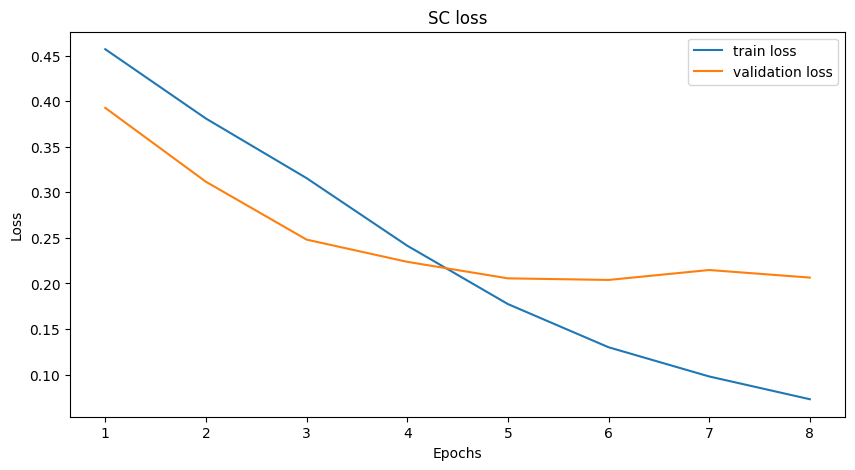

In [150]:
plt.figure(figsize=(10,5))

plt.title("SC loss" if scheme else "AC loss")

plt.plot(statistics['train_loss_values'],label="train loss")

plt.plot(statistics['val_loss_values'],label="validation loss")

plt.xlabel("Epochs")

plt.xticks(np.arange(epochs), np.arange(1, epochs+1, 1))

plt.ylabel("Loss")



plt.legend()

plt.show()

# Evaluation

## AC Evaluation

In [151]:
def predict(model, data_loader, use_cuda=True):

    '''

    Args:

      model: trained model.

      data_loader: source of evaluation data.



    Returns:

      pred_emo: predicted emotions.

      pred_tri: predicted thresholded triggers.

      pred_tri_orig: raw model's trigger predictions.

    '''

    device = torch.device('cuda') if use_cuda and torch.cuda.is_available() else torch.device('cpu')

    model.eval()

    model.to(device)

    predictions = []

    with torch.no_grad():

        for step_num, batch in tqdm(enumerate(data_loader)):

            input_ids = batch['input_ids'].to(device)

            attention_mask = batch['attention_mask'].to(device)

            #labels_emo = batch['labels'].to(device)

            output = model(input_ids, attention_mask=attention_mask)

            pred= output

            pred = pred.cpu().detach().numpy()

            predictions.append(np.argmax(pred,axis=-1))

    predictions = np.concatenate(predictions)



    return predictions

In [152]:
#base_test_encodings = base_tokenizer.transform(df_test)

train_encodings = encode(tokenizer, df_train, train_labels, include_previous=INCLUDE_PREVIOUS)

val_encodings = encode(tokenizer, df_val, val_labels, include_previous=INCLUDE_PREVIOUS)

test_encodings = encode(tokenizer,df_test,test_labels, include_previous=INCLUDE_PREVIOUS)

print(f'ENCODING COMPLETE.')




Encoding...
input shape: (1424, 410)
Encoding complete
Encoding...
input shape: (153, 351)
Encoding complete
Encoding...
input shape: (256, 334)
Encoding complete
ENCODING COMPLETE.


In [153]:
if not scheme:

    #create val dataset

    val_dataset = CustomTorchDataset(val_encodings)

    #create val dataloader

    data_loader_val = torch.utils.data.DataLoader(val_dataset,

                                      batch_size=batch_size,

                                      shuffle = False)

    y_true = val_labels

    y_pred = predict(model,data_loader_val)

    print('/n'+""+classification_report(y_true, y_pred))

In [154]:
if not scheme:

    y_true = test_labels



    #y_pred = base_model.predict(base_test_encodings)

    #print("\n Baseline: \n"+classification_report(y_true, y_pred))



    #create test dataset

    test_dataset = CustomTorchDataset(test_encodings)

    #create test dataloader

    data_loader_test = torch.utils.data.DataLoader(test_dataset,

                                      batch_size=batch_size,

                                      shuffle = False)

    y_pred = predict(model,data_loader_test)

    print("\n Actual model: \n"+classification_report(y_true, y_pred))

In [155]:
#score = f1_score(y_true, y_pred, labels=df_test['label'].unique(), average='macro')

## SC Evaluation

In [156]:
def evaluate(model, data_loader, use_cuda=True):

    predictions = []

    device = torch.device('cuda') if use_cuda and torch.cuda.is_available() else torch.device('cpu')

    model.eval()

    model.to(device)

    loop = tqdm(data_loader)

    with torch.no_grad():

        for batch in loop:

            pred = model(batch['input_ids'].to(device), attention_mask = batch["attention_mask"].to(device))

            pred = pred.cpu().detach().numpy()

            predictions.append(pred)

    predictions = np.concatenate(predictions)

    return predictions

In [157]:
from sklearn.metrics import classification_report,f1_score


TRAIN = False
if scheme:

    #y_pred = base_model.predict(base_test_encodings)

    #print("\n Baseline: \n"+classification_report(df_test['Scheme'], y_pred))



    test_encodings = encode(tokenizer,df_test,test_labels,scheme,include_previous=INCLUDE_PREVIOUS)
    train_encodings = encode(tokenizer,df_train,train_labels,scheme,include_previous=INCLUDE_PREVIOUS)
    #create test dataset

    test_dataset = CustomTorchDataset(test_encodings)
    train_dataset = CustomTorchDataset(train_encodings)

    #create test dataloader

    data_loader_test = torch.utils.data.DataLoader(test_dataset,

                                        batch_size=batch_size,

                                        shuffle = False)
    data_loader_train = torch.utils.data.DataLoader(train_dataset,

                                        batch_size=batch_size,

                                        shuffle = False)


    train_predictions = evaluate(model, data_loader_train)
    test_predictions = evaluate(model, data_loader_test)
    if TRAIN:
        y_pred = np.where(train_predictions<0.5, 0., 1.)
        y_true = np.array(train_labels)
    else:
        y_pred = np.where(test_predictions<0.5, 0., 1.)
        y_true = np.array(test_labels)


    #print(y_pred)


    print(y_true.shape,y_pred.shape)
    print("\n"+classification_report(y_true, y_pred,target_names = sc_classes))

Encoding...
input shape: (256, 334)
Encoding complete
Encoding...
input shape: (1424, 410)
Encoding complete


  0%|          | 0/45 [00:00<?, ?it/s]/tmp/ipykernel_34/136612130.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 8/8 [00:02<00:00,  2.97it/s]

(256, 8) (256, 8)

              precision    recall  f1-score   support

        Rule       0.92      0.88      0.90       114
        Prec       0.82      0.90      0.86        83
        Itpr       0.66      0.50      0.57        62
       Princ       0.48      0.48      0.48        29
       Class       0.70      0.35      0.47        20
         Aut       0.41      0.64      0.50        14
        Syst       0.00      0.00      0.00         5
        Tele       0.50      0.33      0.40         3

   micro avg       0.76      0.72      0.74       330
   macro avg       0.56      0.51      0.52       330
weighted avg       0.75      0.72      0.73       330
 samples avg       0.78      0.75      0.75       330




/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        Rule       0.85      0.90      0.88       114
        Prec       0.89      0.89      0.89        83
        Itpr       0.57      0.40      0.47        62
       Princ       0.47      0.24      0.32        29
       Class       0.17      0.05      0.08        20
         Aut       0.47      0.57      0.52        14
        Syst       0.00      0.00      0.00         5
        Tele       0.00      0.00      0.00         3

   micro avg       0.76      0.66      0.71       330
   macro avg       0.43      0.38      0.39       330
weighted avg       0.70      0.66      0.67       330
 samples avg       0.73      0.68      0.69       330

BCE loss, no aug, 12 epochs

              precision    recall  f1-score   support

        Rule       0.86      0.77      0.81       114
        Prec       0.87      0.93      0.90        83
        Itpr       0.46      0.63      0.53        62
       Princ       0.67      0.48      0.56        29
       Class       0.43      0.45      0.44        20
         Aut       0.89      0.57      0.70        14
        Syst       0.00      0.00      0.00         5
        Tele       0.50      0.33      0.40         3

   micro avg       0.72      0.72      0.72       330
   macro avg       0.58      0.52      0.54       330
weighted avg       0.73      0.72      0.72       330
 samples avg       0.74      0.74      0.72       330
 
FL, no aug, 12 epochs

          precision    recall  f1-score   support

        Rule       0.92      0.89      0.91       114
        Prec       0.88      0.86      0.87        83
        Itpr       0.62      0.50      0.55        62
       Princ       0.41      0.66      0.51        29
       Class       0.54      0.35      0.42        20
         Aut       0.50      0.71      0.59        14
        Syst       0.33      0.20      0.25         5
        Tele       0.33      0.33      0.33         3

   micro avg       0.74      0.73      0.74       330
   macro avg       0.57      0.56      0.55       330
weighted avg       0.75      0.73      0.74       330
 samples avg       0.76      0.77      0.74       330

 FL, AUG, 9 EPOCHS 

      Rule       0.92      0.88      0.90       114
        Prec       0.82      0.90      0.86        83
        Itpr       0.66      0.50      0.57        62
       Princ       0.48      0.48      0.48        29
       Class       0.70      0.35      0.47        20
         Aut       0.41      0.64      0.50        14
        Syst       0.00      0.00      0.00         5
        Tele       0.50      0.33      0.40         3

   micro avg       0.76      0.72      0.74       330
   macro avg       0.56      0.51      0.52       330
weighted avg       0.75      0.72      0.73       330
 samples avg       0.78      0.75      0.75       330

 BCE, AUG, 8 EPOCHS

## GE3(embedding augmentation)

In [ ]:
class Classifier(nn.Module):

    def __init__(self, output_size):
        super(Classifier, self).__init__()
        self.output_size = output_size
        self.cl1 = nn.Linear(768, 768)
        self.relu = nn.ReLU()
        self.classifier = nn.Linear(768, self.output_size)

    def forward(self, input):

        x = self.cl1(input)
        x = self.relu(x)
        x = self.classifier(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
cls = Classifier(num_labels)
cls

Classifier(
  (cl1): Linear(in_features=768, out_features=768, bias=True)
  (relu): ReLU()
  (classifier): Linear(in_features=768, out_features=8, bias=True)
)

In [ ]:
for name, layer in model.named_modules():
    break
    print(name)

In [ ]:
import time
start = time.time()
l = ['cl1','classifier']

sub_dict = {k:v for k,v in model.state_dict().items() if k in l}
end = time.time()

print(start-end)


sub_dict

-0.0028679370880126953


{}

In [ ]:
sub = dict(list(model.state_dict().items())[-4:])
sub.keys()

dict_keys(['cl1.weight', 'cl1.bias', 'classifier.weight', 'classifier.bias'])

In [ ]:
cls.load_state_dict(sub)

<All keys matched successfully>

In [ ]:
cls(torch.zeros((5,768))).size()

torch.Size([5, 8])

In [ ]:
#m,t= getModel("dlicari/Italian-Legal-BERT",num_labels,scheme = True)
m,t = model,tokenizer
train_encodings = encode(t, df_train, train_labels, scheme, include_previous=False)
tot =  len(train_encodings['input_ids'])
device = torch.device('cuda')
m.to(device)
print(tot)
b_size = 32
n_minibatch = tot //b_size
print(f"n_minibatches: {n_minibatch}")
embeddings= []
for i in range(n_minibatch):
    start = i*b_size
    end = (i+1)*b_size
    with torch.no_grad():
        input = torch.stack([torch.tensor(t,device=device) for t in train_encodings['input_ids'][start:end]])
        mask = torch.stack([torch.tensor(t,device=device) for t in train_encodings['attention_mask'][start:end]])
        #out = m(torch.tensor(train_encodings['input_ids'][start:end],device=device),torch.tensor(train_encodings['attention_mask'][start:end],device=device))
        #print(input.size())
        out = m(input,mask,only_embeddings=True)

    embeddings = embeddings + list(out)
tot = len(embeddings)
print(tot)

Encoding...
input shape: (878, 410)
Encoding complete
878
n_minibatches: 27
864


In [ ]:
train_labels
for x in np.array(train_labels):
    if list(x).count(1) > 1:
        break
        #print(x)
lab = df_train['Scheme'][:tot].reset_index(drop=True)
lab

0               Rule
1               Itpr
2               Rule
3               Rule
4       [Itpr, Prec]
           ...      
859     [Prec, Rule]
860     [Prec, Rule]
861             Rule
862    [Class, Rule]
863            Princ
Name: Scheme, Length: 864, dtype: object

In [ ]:
print(torch.stack(embeddings).unsqueeze(1).size())
e = torch.stack(embeddings).detach().cpu().numpy()
def compress(x):
    return list(x)

e1 = list(map(compress, e))
np.array(e1).shape
enc_lab = np.array(train_labels[:tot])
len(enc_lab.tolist())

torch.Size([864, 1, 768])


864

In [ ]:
e = torch.stack(embeddings).detach().cpu().numpy()
df = pd.DataFrame()
#df.head(10)
df['embeddings'] = e.tolist()
#df.assign(embeddings=list(e))
#df.assign(labels=lab.tolist())
df['labels'] = lab
#df['enc_labels'] = enc_lab.tolist()
#df.head(10)
df

,embeddings,labels
0,"[-0.6425947546958923, 0.49876999855041504, -0....",Rule
1,"[0.7353600263595581, 0.2940705120563507, 0.370...",Itpr
2,"[-0.4840069115161896, 0.3996689021587372, -0.7...",Rule
3,"[-0.606418251991272, 0.5708830952644348, -0.81...",Rule
4,"[0.6229081153869629, 0.3674868047237396, 0.496...","[Itpr, Prec]"
...,...,...
859,"[-0.33637452125549316, 0.28232645988464355, -0...","[Prec, Rule]"
860,"[-0.3831097483634949, 0.10311482101678848, -0....","[Prec, Rule]"
861,"[-0.7380532026290894, 0.3156740963459015, -0.8...",Rule
862,"[0.15592938661575317, -0.08031386137008667, -0...","[Class, Rule]"


In [ ]:
df = clean_list(df,'labels')
df

,embeddings,labels,labels2
0,"[-0.6425947546958923, 0.49876999855041504, -0....",Rule,Rule
1,"[0.7353600263595581, 0.2940705120563507, 0.370...",Itpr,Itpr
2,"[-0.4840069115161896, 0.3996689021587372, -0.7...",Rule,Rule
3,"[-0.606418251991272, 0.5708830952644348, -0.81...",Rule,Rule
4,"[0.6229081153869629, 0.3674868047237396, 0.496...","[Itpr, Prec]","Itpr,Prec"
...,...,...,...
859,"[-0.33637452125549316, 0.28232645988464355, -0...","[Prec, Rule]","Prec,Rule"
860,"[-0.3831097483634949, 0.10311482101678848, -0....","[Prec, Rule]","Prec,Rule"
861,"[-0.7380532026290894, 0.3156740963459015, -0.8...",Rule,Rule
862,"[0.15592938661575317, -0.08031386137008667, -0...","[Class, Rule]","Class,Rule"


In [ ]:
#consider each combination of labels as a different label
names = df['labels'].explode().unique()
len(names)
names

array(['Rule', 'Itpr', 'Prec', 'Aut', 'Class', 'Syst', 'Princ', 'Tele'],
      dtype=object)

In [ ]:
#mean_embeddings = np.empty((len(names),768))
df = df.explode('labels')
mean_embeddings = dict()
for name in names:
    a = df[df['labels']==name]
    #print(a['embeddings'].apply(lambda x: np.array(x)))
    q = np.array(a['embeddings'])

    #print(type(a['embeddings'].iloc[0]))
    #a.head(10)
    q =np.array(list(map(lambda x: np.array(x),q)))
    #np.array(q1).shape
    if len(q)==0:
        print(name)
    mean_embeddings[name] = q.mean(0)
    #print(np.array(a['embeddings']).shape)
len(mean_embeddings)

8

In [ ]:
#create new embeddings: target_emb = source_emb - mean_source + mean_target
new_embeddings = []
new_labels = []
for source in names:
    a = df[df['labels']==source]
    print(f'source: {source}, length:{len(a)}')
    for target in names:
        l=0
        if target == source:
            continue
        for e in a['embeddings']:
            l = l + 1
            new = np.array(e) - mean_embeddings[source] + mean_embeddings[target]
            new_embeddings.append(new)
            new_labels.append(target)
        print(source,target,l)
len(new_embeddings)

source: Rule, length:377
Rule Itpr 377
Rule Prec 377
Rule Aut 377
Rule Class 377
Rule Syst 377
Rule Princ 377
Rule Tele 377
source: Itpr, length:210
Itpr Rule 210
Itpr Prec 210
Itpr Aut 210
Itpr Class 210
Itpr Syst 210
Itpr Princ 210
Itpr Tele 210
source: Prec, length:282
Prec Rule 282
Prec Itpr 282
Prec Aut 282
Prec Class 282
Prec Syst 282
Prec Princ 282
Prec Tele 282
source: Aut, length:49
Aut Rule 49
Aut Itpr 49
Aut Prec 49
Aut Class 49
Aut Syst 49
Aut Princ 49
Aut Tele 49
source: Class, length:66
Class Rule 66
Class Itpr 66
Class Prec 66
Class Aut 66
Class Syst 66
Class Princ 66
Class Tele 66
source: Syst, length:19
Syst Rule 19
Syst Itpr 19
Syst Prec 19
Syst Aut 19
Syst Class 19
Syst Princ 19
Syst Tele 19
source: Princ, length:95
Princ Rule 95
Princ Itpr 95
Princ Prec 95
Princ Aut 95
Princ Class 95
Princ Syst 95
Princ Tele 95
source: Tele, length:12
Tele Rule 12
Tele Itpr 12
Tele Prec 12
Tele Aut 12
Tele Class 12
Tele Syst 12
Tele Princ 12


7770

In [ ]:
#reverse exploding
df =df.rename_axis(index='ind')
df1 = df.explode('labels').groupby(by='ind').agg({'embeddings':list,'labels':list})
df1

,embeddings,labels
ind,,
0,"[[-0.6425947546958923, 0.49876999855041504, -0...",[Rule]
1,"[[0.7353600263595581, 0.2940705120563507, 0.37...",[Itpr]
2,"[[-0.4840069115161896, 0.3996689021587372, -0....",[Rule]
3,"[[-0.606418251991272, 0.5708830952644348, -0.8...",[Rule]
4,"[[0.6229081153869629, 0.3674868047237396, 0.49...","[Itpr, Prec]"
...,...,...
859,"[[-0.33637452125549316, 0.28232645988464355, -...","[Prec, Rule]"
860,"[[-0.3831097483634949, 0.10311482101678848, -0...","[Prec, Rule]"
861,"[[-0.7380532026290894, 0.3156740963459015, -0....",[Rule]


In [ ]:
#remove list of list in embedding column
def f(x):
    return x[0]

df1['embeddings'] = df1['embeddings'].apply(f)
df1['embeddings']

ind
0      [-0.6425947546958923, 0.49876999855041504, -0....
1      [0.7353600263595581, 0.2940705120563507, 0.370...
2      [-0.4840069115161896, 0.3996689021587372, -0.7...
3      [-0.606418251991272, 0.5708830952644348, -0.81...
4      [0.6229081153869629, 0.3674868047237396, 0.496...
                             ...                        
859    [-0.33637452125549316, 0.28232645988464355, -0...
860    [-0.3831097483634949, 0.10311482101678848, -0....
861    [-0.7380532026290894, 0.3156740963459015, -0.8...
862    [0.15592938661575317, -0.08031386137008667, -0...
863    [0.07925524562597275, -0.3112379014492035, -0....
Name: embeddings, Length: 864, dtype: object

In [ ]:
df1

,embeddings,labels
ind,,
0,"[-0.6425947546958923, 0.49876999855041504, -0....",[Rule]
1,"[0.7353600263595581, 0.2940705120563507, 0.370...",[Itpr]
2,"[-0.4840069115161896, 0.3996689021587372, -0.7...",[Rule]
3,"[-0.606418251991272, 0.5708830952644348, -0.81...",[Rule]
4,"[0.6229081153869629, 0.3674868047237396, 0.496...","[Itpr, Prec]"
...,...,...
859,"[-0.33637452125549316, 0.28232645988464355, -0...","[Prec, Rule]"
860,"[-0.3831097483634949, 0.10311482101678848, -0....","[Prec, Rule]"
861,"[-0.7380532026290894, 0.3156740963459015, -0.8...",[Rule]


In [ ]:
new_df = pd.DataFrame()
new_df['embeddings'] = new_embeddings
new_df['labels'] = new_labels
#new_df.describe()
#q = (new_df['embeddings'][:2])
#q = np.array(list(map(lambda x: np.array(x),q)))
#torch.stack(list(map(lambda x: torch.tensor(x),q))).
new_df['labels'].value_counts()

labels
Tele     1098
Syst     1091
Aut      1061
Class    1044
Princ    1015
Itpr      900
Prec      828
Rule      733
Name: count, dtype: int64

In [ ]:
#merge dataframes
tot_df = pd.concat([df1,new_df],ignore_index=True)
#final_df = pd.get_dummies(tot_df,columns = ['labels'],dtype=float)

z = tot_df.explode('labels')
z['labels'].value_counts()
#convert list labels to string
tot_df=clean_list(tot_df,'labels')
tot_df

,embeddings,labels,labels2
0,"[-0.6425947546958923, 0.49876999855041504, -0....",[Rule],Rule
1,"[0.7353600263595581, 0.2940705120563507, 0.370...",[Itpr],Itpr
2,"[-0.4840069115161896, 0.3996689021587372, -0.7...",[Rule],Rule
3,"[-0.606418251991272, 0.5708830952644348, -0.81...",[Rule],Rule
4,"[0.6229081153869629, 0.3674868047237396, 0.496...","[Itpr, Prec]","Itpr,Prec"
...,...,...,...
8629,"[-0.5122079027195772, 0.18639138029038646, -0....",Princ,Princ
8630,"[-0.5288697255154451, -0.0801727355915334, -0....",Princ,Princ
8631,"[-0.22952695911129312, -0.1597647847133901, 0....",Princ,Princ
8632,"[-0.36191212361057595, -0.03471595360815785, 0...",Princ,Princ


In [ ]:
#apply again the multibinarizer on Scheme, before transform the list classes into str,
#and get a one hot encoding of the labels
mlb1 = MultiLabelBinarizer()

mlb_result = mlb.fit_transform([str(tot_df.loc[i,'labels2']).split(',') for i in range(len(tot_df))])

df_aug = pd.concat([tot_df,pd.DataFrame(mlb_result,columns=list(mlb.classes_))],axis=1)
df_aug_labels = df_aug[sc_classes]
df_aug_train = df_aug['embeddings']

In [ ]:
las = torch.stack(list(map(lambda l: torch.tensor(l,device=device,dtype=torch.float32),np.array(train_labels))))
las.size()

torch.Size([878, 8])

In [ ]:
#preprocessing
#q = (new_df['embeddings'][:2])
#q = np.array(list(map(lambda x: np.array(x),q)))
#torch.stack(list(map(lambda x: torch.tensor(x),q)))

train_data = torch.stack(list(map(lambda e: torch.tensor(e,device=device,dtype=torch.float32),df_aug_train)))
train_labs = torch.stack(list(map(lambda l: torch.tensor(l,device=device,dtype=torch.float32),np.array(df_aug_labels))))
print(train_data.size(),train_labs.size())


torch.Size([8634, 768]) torch.Size([8634, 8])


In [ ]:
#clsf = classifier(11)
cls.to(device).train()

Classifier(
  (cl1): Linear(in_features=768, out_features=768, bias=True)
  (relu): ReLU()
  (classifier): Linear(in_features=768, out_features=8, bias=True)
)

In [ ]:
#define loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(cls.parameters(), lr=5e-5, weight_decay=1.5e-2)

In [ ]:
b_size = 32
n_minibatch = len(train_data) //b_size
print(f"n_minibatches: {n_minibatch}")
for e in tqdm(range(1000)):
    losses= []
    for i in range(n_minibatch):
        start = i*b_size
        end = (i+1)*b_size
        optimizer.zero_grad()

        preds = cls(train_data[start:end])
        ground = train_labs[start:end]
        loss = criterion(preds,ground)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    tot_loss = np.mean(losses)
    print(f'epoch: {e}, loss:{tot_loss}')



n_minibatches: 269


  0%|          | 1/1000 [00:00<05:43,  2.90it/s]

epoch: 0, loss:0.1220913901717357


  0%|          | 2/1000 [00:00<05:37,  2.95it/s]

epoch: 1, loss:0.07198479710333741


  0%|          | 3/1000 [00:01<05:35,  2.97it/s]

epoch: 2, loss:0.06019036113163352


  0%|          | 4/1000 [00:01<05:32,  3.00it/s]

epoch: 3, loss:0.054767971700853686


  0%|          | 5/1000 [00:01<05:34,  2.98it/s]

epoch: 4, loss:0.05147110367173045


  1%|          | 6/1000 [00:02<05:38,  2.94it/s]

epoch: 5, loss:0.04913107447021513


  1%|          | 7/1000 [00:02<05:36,  2.95it/s]

epoch: 6, loss:0.04722075455659329


  1%|          | 8/1000 [00:02<05:33,  2.97it/s]

epoch: 7, loss:0.04558204027277082


  1%|          | 9/1000 [00:03<05:29,  3.01it/s]

epoch: 8, loss:0.044127905591595296


  1%|          | 10/1000 [00:03<05:26,  3.04it/s]

epoch: 9, loss:0.042797428081469906


  1%|          | 11/1000 [00:03<05:22,  3.07it/s]

epoch: 10, loss:0.04154449472200389


  1%|          | 12/1000 [00:03<05:20,  3.08it/s]

epoch: 11, loss:0.040349670001184466


  1%|▏         | 13/1000 [00:04<05:19,  3.09it/s]

epoch: 12, loss:0.03921808619190658


  1%|▏         | 14/1000 [00:04<05:17,  3.10it/s]

epoch: 13, loss:0.03814055723463597


  2%|▏         | 15/1000 [00:04<05:18,  3.09it/s]

epoch: 14, loss:0.03711109766286545


  2%|▏         | 16/1000 [00:05<05:16,  3.11it/s]

epoch: 15, loss:0.03608157474038686


  2%|▏         | 17/1000 [00:05<05:14,  3.12it/s]

epoch: 16, loss:0.035102166219867184


  2%|▏         | 18/1000 [00:05<05:12,  3.14it/s]

epoch: 17, loss:0.0341479592986031


  2%|▏         | 19/1000 [00:06<05:12,  3.14it/s]

epoch: 18, loss:0.03322967797341206


  2%|▏         | 20/1000 [00:06<05:13,  3.12it/s]

epoch: 19, loss:0.032344978434279505


  2%|▏         | 21/1000 [00:06<05:13,  3.12it/s]

epoch: 20, loss:0.03149714672307875


  2%|▏         | 22/1000 [00:07<05:12,  3.13it/s]

epoch: 21, loss:0.030680189657000805


  2%|▏         | 23/1000 [00:07<05:12,  3.12it/s]

epoch: 22, loss:0.029886989530563686


  2%|▏         | 24/1000 [00:07<05:20,  3.04it/s]

epoch: 23, loss:0.02911735093610562


  2%|▎         | 25/1000 [00:08<05:29,  2.96it/s]

epoch: 24, loss:0.028379958474811263


  3%|▎         | 26/1000 [00:08<05:26,  2.98it/s]

epoch: 25, loss:0.02766153438200267


  3%|▎         | 27/1000 [00:08<05:21,  3.02it/s]

epoch: 26, loss:0.026967820368679483


  3%|▎         | 28/1000 [00:09<05:19,  3.04it/s]

epoch: 27, loss:0.02629059993057792


  3%|▎         | 29/1000 [00:09<05:17,  3.06it/s]

epoch: 28, loss:0.025630748059105504


  3%|▎         | 30/1000 [00:09<05:14,  3.08it/s]

epoch: 29, loss:0.024983470249820682


  3%|▎         | 31/1000 [00:10<05:15,  3.08it/s]

epoch: 30, loss:0.024356259324338606


  3%|▎         | 32/1000 [00:10<05:13,  3.09it/s]

epoch: 31, loss:0.02374802824701823


  3%|▎         | 33/1000 [00:10<05:11,  3.10it/s]

epoch: 32, loss:0.02315517152974652


  3%|▎         | 34/1000 [00:11<05:11,  3.10it/s]

epoch: 33, loss:0.02257896653596367


  4%|▎         | 35/1000 [00:11<05:09,  3.12it/s]

epoch: 34, loss:0.022010360601216167


  4%|▎         | 36/1000 [00:11<05:11,  3.10it/s]

epoch: 35, loss:0.021456369399231578


  4%|▎         | 37/1000 [00:12<05:10,  3.10it/s]

epoch: 36, loss:0.020907858261565045


  4%|▍         | 38/1000 [00:12<05:12,  3.08it/s]

epoch: 37, loss:0.02037815121478543


  4%|▍         | 39/1000 [00:12<05:13,  3.07it/s]

epoch: 38, loss:0.01985489500368007


  4%|▍         | 40/1000 [00:13<05:11,  3.08it/s]

epoch: 39, loss:0.019353219577575236


  4%|▍         | 41/1000 [00:13<05:10,  3.09it/s]

epoch: 40, loss:0.018849482568981453


  4%|▍         | 42/1000 [00:13<05:11,  3.08it/s]

epoch: 41, loss:0.018371472979954628


  4%|▍         | 43/1000 [00:14<05:14,  3.05it/s]

epoch: 42, loss:0.017896461477987884


  4%|▍         | 44/1000 [00:14<05:16,  3.02it/s]

epoch: 43, loss:0.01743483126464691


  4%|▍         | 45/1000 [00:14<05:18,  3.00it/s]

epoch: 44, loss:0.01698352205636305


  5%|▍         | 46/1000 [00:15<05:16,  3.01it/s]

epoch: 45, loss:0.01654124780442067


  5%|▍         | 47/1000 [00:15<05:13,  3.04it/s]

epoch: 46, loss:0.016113215457166798


  5%|▍         | 48/1000 [00:15<05:09,  3.07it/s]

epoch: 47, loss:0.015689615312129344


  5%|▍         | 49/1000 [00:16<05:07,  3.09it/s]

epoch: 48, loss:0.015277982162758292


  5%|▌         | 50/1000 [00:16<05:11,  3.05it/s]

epoch: 49, loss:0.014878308318718076


  5%|▌         | 51/1000 [00:16<05:09,  3.07it/s]

epoch: 50, loss:0.014480190721840761


  5%|▌         | 52/1000 [00:16<05:07,  3.08it/s]

epoch: 51, loss:0.014100435641931792


  5%|▌         | 53/1000 [00:17<05:06,  3.09it/s]

epoch: 52, loss:0.01372023011046223


  5%|▌         | 54/1000 [00:17<05:05,  3.10it/s]

epoch: 53, loss:0.013362393510219776


  6%|▌         | 55/1000 [00:17<05:06,  3.08it/s]

epoch: 54, loss:0.012999885790197173


  6%|▌         | 56/1000 [00:18<05:14,  3.00it/s]

epoch: 55, loss:0.012657315654638587


  6%|▌         | 57/1000 [00:18<05:12,  3.02it/s]

epoch: 56, loss:0.012315017851736037


  6%|▌         | 58/1000 [00:18<05:09,  3.04it/s]

epoch: 57, loss:0.011984221985845802


  6%|▌         | 59/1000 [00:19<05:08,  3.05it/s]

epoch: 58, loss:0.01165669726953949


  6%|▌         | 60/1000 [00:19<05:06,  3.07it/s]

epoch: 59, loss:0.01134306811541492


  6%|▌         | 61/1000 [00:19<05:08,  3.05it/s]

epoch: 60, loss:0.011035442703055585


  6%|▌         | 62/1000 [00:20<05:07,  3.05it/s]

epoch: 61, loss:0.010737312234700987


  6%|▋         | 63/1000 [00:20<05:04,  3.08it/s]

epoch: 62, loss:0.010439930970349513


  6%|▋         | 64/1000 [00:20<05:01,  3.10it/s]

epoch: 63, loss:0.010161021076269157


  6%|▋         | 65/1000 [00:21<05:03,  3.09it/s]

epoch: 64, loss:0.009876976506767247


  7%|▋         | 66/1000 [00:21<05:02,  3.09it/s]

epoch: 65, loss:0.009605882306138338


  7%|▋         | 67/1000 [00:21<05:01,  3.09it/s]

epoch: 66, loss:0.009341132011113959


  7%|▋         | 68/1000 [00:22<05:01,  3.09it/s]

epoch: 67, loss:0.009081433549675689


  7%|▋         | 69/1000 [00:22<05:01,  3.09it/s]

epoch: 68, loss:0.008826770274648893


  7%|▋         | 70/1000 [00:22<05:01,  3.09it/s]

epoch: 69, loss:0.00858025883474183


  7%|▋         | 71/1000 [00:23<05:05,  3.04it/s]

epoch: 70, loss:0.008333727956613609


  7%|▋         | 72/1000 [00:23<05:06,  3.03it/s]

epoch: 71, loss:0.008104707203873825


  7%|▋         | 73/1000 [00:23<05:02,  3.06it/s]

epoch: 72, loss:0.007868824767720882


  7%|▋         | 74/1000 [00:24<05:04,  3.05it/s]

epoch: 73, loss:0.007642225078679275


  8%|▊         | 75/1000 [00:24<05:01,  3.07it/s]

epoch: 74, loss:0.007420571866275597


  8%|▊         | 76/1000 [00:24<04:58,  3.09it/s]

epoch: 75, loss:0.007210139751254294


  8%|▊         | 77/1000 [00:25<04:57,  3.10it/s]

epoch: 76, loss:0.006997758708504759


  8%|▊         | 78/1000 [00:25<04:54,  3.13it/s]

epoch: 77, loss:0.006795088793012594


  8%|▊         | 79/1000 [00:25<04:53,  3.14it/s]

epoch: 78, loss:0.006596838088284617


  8%|▊         | 80/1000 [00:26<04:57,  3.09it/s]

epoch: 79, loss:0.006400655673667061


  8%|▊         | 81/1000 [00:26<04:56,  3.10it/s]

epoch: 80, loss:0.006218241787717685


  8%|▊         | 82/1000 [00:26<04:59,  3.06it/s]

epoch: 81, loss:0.0060275801214355745


  8%|▊         | 83/1000 [00:27<05:02,  3.03it/s]

epoch: 82, loss:0.005849463556703616


  8%|▊         | 84/1000 [00:27<05:04,  3.01it/s]

epoch: 83, loss:0.005671943000389685


  8%|▊         | 85/1000 [00:27<05:03,  3.01it/s]

epoch: 84, loss:0.005506657912948976


  9%|▊         | 86/1000 [00:28<05:06,  2.98it/s]

epoch: 85, loss:0.005336769833954373


  9%|▊         | 87/1000 [00:28<05:09,  2.95it/s]

epoch: 86, loss:0.005180272973834132


  9%|▉         | 88/1000 [00:28<05:05,  2.99it/s]

epoch: 87, loss:0.005019325311823668


  9%|▉         | 89/1000 [00:29<05:01,  3.02it/s]

epoch: 88, loss:0.004864159323726036


  9%|▉         | 90/1000 [00:29<04:58,  3.04it/s]

epoch: 89, loss:0.004710004673829323


  9%|▉         | 91/1000 [00:29<04:59,  3.04it/s]

epoch: 90, loss:0.004575182393917703


  9%|▉         | 92/1000 [00:30<05:07,  2.95it/s]

epoch: 91, loss:0.004422025578801925


  9%|▉         | 93/1000 [00:30<05:18,  2.85it/s]

epoch: 92, loss:0.004293264024657263


  9%|▉         | 94/1000 [00:30<05:17,  2.85it/s]

epoch: 93, loss:0.004155761107283499


 10%|▉         | 95/1000 [00:31<05:16,  2.86it/s]

epoch: 94, loss:0.004023485856559595


 10%|▉         | 96/1000 [00:31<05:15,  2.87it/s]

epoch: 95, loss:0.0038946538273542408


 10%|▉         | 97/1000 [00:31<05:07,  2.93it/s]

epoch: 96, loss:0.003777479294864513


 10%|▉         | 98/1000 [00:32<05:02,  2.98it/s]

epoch: 97, loss:0.003652498648492412


 10%|▉         | 99/1000 [00:32<04:57,  3.03it/s]

epoch: 98, loss:0.0035388543121547


 10%|█         | 100/1000 [00:32<04:59,  3.00it/s]

epoch: 99, loss:0.003423660931554597


 10%|█         | 101/1000 [00:33<04:56,  3.03it/s]

epoch: 100, loss:0.0033095469045908046


 10%|█         | 102/1000 [00:33<04:52,  3.07it/s]

epoch: 101, loss:0.003212040122591918


 10%|█         | 103/1000 [00:33<04:49,  3.10it/s]

epoch: 102, loss:0.003104591696149


 10%|█         | 104/1000 [00:34<04:47,  3.12it/s]

epoch: 103, loss:0.0030084293464750058


 10%|█         | 105/1000 [00:34<04:46,  3.13it/s]

epoch: 104, loss:0.002905694758095415


 11%|█         | 106/1000 [00:34<04:45,  3.13it/s]

epoch: 105, loss:0.0028153079655800417


 11%|█         | 107/1000 [00:35<04:50,  3.07it/s]

epoch: 106, loss:0.0027243409992672146


 11%|█         | 108/1000 [00:35<04:52,  3.05it/s]

epoch: 107, loss:0.002630823519313275


 11%|█         | 109/1000 [00:35<04:53,  3.03it/s]

epoch: 108, loss:0.0025501271700495197


 11%|█         | 110/1000 [00:36<04:59,  2.97it/s]

epoch: 109, loss:0.0024674332022545107


 11%|█         | 111/1000 [00:36<05:02,  2.94it/s]

epoch: 110, loss:0.0023853558651052613


 11%|█         | 112/1000 [00:36<04:58,  2.98it/s]

epoch: 111, loss:0.0023086964711893114


 11%|█▏        | 113/1000 [00:37<04:55,  3.00it/s]

epoch: 112, loss:0.0022324851134594625


 11%|█▏        | 114/1000 [00:37<04:51,  3.04it/s]

epoch: 113, loss:0.0021583235783641597


 12%|█▏        | 115/1000 [00:37<04:49,  3.05it/s]

epoch: 114, loss:0.0020883332587519773


 12%|█▏        | 116/1000 [00:38<04:49,  3.05it/s]

epoch: 115, loss:0.002018262399590447


 12%|█▏        | 117/1000 [00:38<04:53,  3.01it/s]

epoch: 116, loss:0.001954179731903937


 12%|█▏        | 118/1000 [00:38<04:49,  3.05it/s]

epoch: 117, loss:0.0018893760450696747


 12%|█▏        | 119/1000 [00:39<04:46,  3.08it/s]

epoch: 118, loss:0.0018282855281544215


 12%|█▏        | 120/1000 [00:39<04:50,  3.03it/s]

epoch: 119, loss:0.001770448503142364


 12%|█▏        | 121/1000 [00:39<04:52,  3.01it/s]

epoch: 120, loss:0.0017088834683683036


 12%|█▏        | 122/1000 [00:40<04:51,  3.01it/s]

epoch: 121, loss:0.001655349489021224


 12%|█▏        | 123/1000 [00:40<04:50,  3.02it/s]

epoch: 122, loss:0.001603893849802451


 12%|█▏        | 124/1000 [00:40<04:51,  3.00it/s]

epoch: 123, loss:0.0015519201610626637


 12%|█▎        | 125/1000 [00:41<04:54,  2.97it/s]

epoch: 124, loss:0.0015012186294772964


 13%|█▎        | 126/1000 [00:41<04:49,  3.01it/s]

epoch: 125, loss:0.001454932164849491


 13%|█▎        | 127/1000 [00:41<04:50,  3.01it/s]

epoch: 126, loss:0.0014077919390103732


 13%|█▎        | 128/1000 [00:42<04:53,  2.97it/s]

epoch: 127, loss:0.0013652227069231224


 13%|█▎        | 129/1000 [00:42<04:53,  2.97it/s]

epoch: 128, loss:0.0013223892344106365


 13%|█▎        | 130/1000 [00:42<04:54,  2.96it/s]

epoch: 129, loss:0.001278532030171839


 13%|█▎        | 131/1000 [00:43<04:55,  2.94it/s]

epoch: 130, loss:0.0012411369851611958


 13%|█▎        | 132/1000 [00:43<04:49,  2.99it/s]

epoch: 131, loss:0.0012027279822194566


 13%|█▎        | 133/1000 [00:43<04:46,  3.03it/s]

epoch: 132, loss:0.0011652052675831615


 13%|█▎        | 134/1000 [00:44<04:43,  3.05it/s]

epoch: 133, loss:0.0011318523713785048


 14%|█▎        | 135/1000 [00:44<04:41,  3.07it/s]

epoch: 134, loss:0.0010970453838082606


 14%|█▎        | 136/1000 [00:44<04:42,  3.06it/s]

epoch: 135, loss:0.001065601188813946


 14%|█▎        | 137/1000 [00:45<04:41,  3.07it/s]

epoch: 136, loss:0.00103264086808572


 14%|█▍        | 138/1000 [00:45<04:39,  3.08it/s]

epoch: 137, loss:0.0010014866437370994


 14%|█▍        | 139/1000 [00:45<04:42,  3.05it/s]

epoch: 138, loss:0.0009720821052551773


 14%|█▍        | 140/1000 [00:46<04:40,  3.06it/s]

epoch: 139, loss:0.000945909879824437


 14%|█▍        | 141/1000 [00:46<04:42,  3.04it/s]

epoch: 140, loss:0.0009222210355125304


 14%|█▍        | 142/1000 [00:46<04:44,  3.02it/s]

epoch: 141, loss:0.000893288784081487


 14%|█▍        | 143/1000 [00:47<04:42,  3.04it/s]

epoch: 142, loss:0.0008717080293951994


 14%|█▍        | 144/1000 [00:47<04:38,  3.07it/s]

epoch: 143, loss:0.000842802727979299


 14%|█▍        | 145/1000 [00:47<04:39,  3.06it/s]

epoch: 144, loss:0.0008218365842891406


 15%|█▍        | 146/1000 [00:48<04:44,  3.01it/s]

epoch: 145, loss:0.0007987167281191169


 15%|█▍        | 147/1000 [00:48<04:47,  2.97it/s]

epoch: 146, loss:0.0007767436134863568


 15%|█▍        | 148/1000 [00:48<04:47,  2.96it/s]

epoch: 147, loss:0.0007610355670298047


 15%|█▍        | 149/1000 [00:49<04:43,  3.00it/s]

epoch: 148, loss:0.000742265072900835


 15%|█▌        | 150/1000 [00:49<04:39,  3.04it/s]

epoch: 149, loss:0.0007205126287714668


 15%|█▌        | 151/1000 [00:49<04:38,  3.05it/s]

epoch: 150, loss:0.0007055581174636685


 15%|█▌        | 152/1000 [00:50<04:41,  3.01it/s]

epoch: 151, loss:0.0006858258736418836


 15%|█▌        | 153/1000 [00:50<04:40,  3.02it/s]

epoch: 152, loss:0.0006712465700658807


 15%|█▌        | 154/1000 [00:50<04:39,  3.03it/s]

epoch: 153, loss:0.0006565699812953423


 16%|█▌        | 155/1000 [00:50<04:36,  3.06it/s]

epoch: 154, loss:0.0006405790576871395


 16%|█▌        | 156/1000 [00:51<04:33,  3.09it/s]

epoch: 155, loss:0.0006278682635672498


 16%|█▌        | 157/1000 [00:51<04:31,  3.10it/s]

epoch: 156, loss:0.0006071483175503333


 16%|█▌        | 158/1000 [00:51<04:32,  3.09it/s]

epoch: 157, loss:0.0005940684583109093


 16%|█▌        | 159/1000 [00:52<04:36,  3.04it/s]

epoch: 158, loss:0.0005841993390909162


 16%|█▌        | 160/1000 [00:52<04:38,  3.02it/s]

epoch: 159, loss:0.0005743815920164727


 16%|█▌        | 161/1000 [00:52<04:34,  3.06it/s]

epoch: 160, loss:0.0005614813070489455


 16%|█▌        | 162/1000 [00:53<04:33,  3.07it/s]

epoch: 161, loss:0.000546799292036917


 16%|█▋        | 163/1000 [00:53<04:32,  3.07it/s]

epoch: 162, loss:0.0005357464470005003


 16%|█▋        | 164/1000 [00:53<04:32,  3.07it/s]

epoch: 163, loss:0.0005222589758251266


 16%|█▋        | 165/1000 [00:54<04:31,  3.07it/s]

epoch: 164, loss:0.0005164163677012205


 17%|█▋        | 166/1000 [00:54<04:31,  3.07it/s]

epoch: 165, loss:0.0005071371520386313


 17%|█▋        | 167/1000 [00:54<04:30,  3.07it/s]

epoch: 166, loss:0.0004940183456318458


 17%|█▋        | 168/1000 [00:55<04:31,  3.06it/s]

epoch: 167, loss:0.0004905554720425477


 17%|█▋        | 169/1000 [00:55<04:30,  3.07it/s]

epoch: 168, loss:0.00048190943956218974


 17%|█▋        | 170/1000 [00:55<04:33,  3.03it/s]

epoch: 169, loss:0.0004736016720229782


 17%|█▋        | 171/1000 [00:56<04:32,  3.04it/s]

epoch: 170, loss:0.0004642171251967218


 17%|█▋        | 172/1000 [00:56<04:31,  3.05it/s]

epoch: 171, loss:0.00046007076438143004


 17%|█▋        | 173/1000 [00:56<04:30,  3.05it/s]

epoch: 172, loss:0.0004503202756463619


 17%|█▋        | 174/1000 [00:57<04:29,  3.06it/s]

epoch: 173, loss:0.0004478843967756576


 18%|█▊        | 175/1000 [00:57<04:27,  3.09it/s]

epoch: 174, loss:0.00043955686443991555


 18%|█▊        | 176/1000 [00:57<04:26,  3.09it/s]

epoch: 175, loss:0.0004337224234491073


 18%|█▊        | 177/1000 [00:58<04:33,  3.01it/s]

epoch: 176, loss:0.000426353959441677


 18%|█▊        | 178/1000 [00:58<04:35,  2.98it/s]

epoch: 177, loss:0.0004273615706381195


 18%|█▊        | 179/1000 [00:58<04:36,  2.97it/s]

epoch: 178, loss:0.0004165501537190586


 18%|█▊        | 180/1000 [00:59<04:32,  3.01it/s]

epoch: 179, loss:0.0004159959149562981


 18%|█▊        | 181/1000 [00:59<04:32,  3.01it/s]

epoch: 180, loss:0.00040276379385656777


 18%|█▊        | 182/1000 [00:59<04:33,  2.99it/s]

epoch: 181, loss:0.00040250470513601477


 18%|█▊        | 183/1000 [01:00<04:34,  2.97it/s]

epoch: 182, loss:0.00040037639129013937


 18%|█▊        | 184/1000 [01:00<04:34,  2.98it/s]

epoch: 183, loss:0.00039618858908123806


 18%|█▊        | 185/1000 [01:00<04:29,  3.02it/s]

epoch: 184, loss:0.0003913629772600313


 19%|█▊        | 186/1000 [01:01<04:27,  3.04it/s]

epoch: 185, loss:0.0003866147236944638


 19%|█▊        | 187/1000 [01:01<04:24,  3.07it/s]

epoch: 186, loss:0.0003798131678730674


 19%|█▉        | 188/1000 [01:01<04:32,  2.98it/s]

epoch: 187, loss:0.000380274132701322


 19%|█▉        | 189/1000 [01:02<04:35,  2.94it/s]

epoch: 188, loss:0.00037422514736839033


 19%|█▉        | 190/1000 [01:02<04:36,  2.93it/s]

epoch: 189, loss:0.0003686881837512242


 19%|█▉        | 191/1000 [01:02<04:39,  2.90it/s]

epoch: 190, loss:0.0003711029570269237


 19%|█▉        | 192/1000 [01:03<04:35,  2.93it/s]

epoch: 191, loss:0.0003643829772189676


 19%|█▉        | 193/1000 [01:03<04:29,  2.99it/s]

epoch: 192, loss:0.00036000251874832034


 19%|█▉        | 194/1000 [01:03<04:26,  3.03it/s]

epoch: 193, loss:0.00035897356900430126


 20%|█▉        | 195/1000 [01:04<04:23,  3.06it/s]

epoch: 194, loss:0.0003494126235945459


 20%|█▉        | 196/1000 [01:04<04:20,  3.09it/s]

epoch: 195, loss:0.0003536396438818941


 20%|█▉        | 197/1000 [01:04<04:18,  3.10it/s]

epoch: 196, loss:0.0003438684243815513


 20%|█▉        | 198/1000 [01:05<04:18,  3.11it/s]

epoch: 197, loss:0.0003450189538268939


 20%|█▉        | 199/1000 [01:05<04:16,  3.12it/s]

epoch: 198, loss:0.00034766535996982975


 20%|██        | 200/1000 [01:05<04:15,  3.13it/s]

epoch: 199, loss:0.00034233872890702423


 20%|██        | 201/1000 [01:06<04:21,  3.05it/s]

epoch: 200, loss:0.0003389234675823832


 20%|██        | 202/1000 [01:06<04:24,  3.02it/s]

epoch: 201, loss:0.0003392921946080392


 20%|██        | 203/1000 [01:06<04:22,  3.04it/s]

epoch: 202, loss:0.0003309594881936018


 20%|██        | 204/1000 [01:07<04:20,  3.06it/s]

epoch: 203, loss:0.0003339407286085161


 20%|██        | 205/1000 [01:07<04:19,  3.06it/s]

epoch: 204, loss:0.00033708511973942583


 21%|██        | 206/1000 [01:07<04:18,  3.07it/s]

epoch: 205, loss:0.00032683734247367964


 21%|██        | 207/1000 [01:08<04:25,  2.99it/s]

epoch: 206, loss:0.00033081103216057534


 21%|██        | 208/1000 [01:08<04:26,  2.97it/s]

epoch: 207, loss:0.000327559369023323


 21%|██        | 209/1000 [01:08<04:26,  2.97it/s]

epoch: 208, loss:0.0003230452618080576


 21%|██        | 210/1000 [01:09<04:27,  2.95it/s]

epoch: 209, loss:0.0003253195464783174


 21%|██        | 211/1000 [01:09<04:23,  2.99it/s]

epoch: 210, loss:0.00031882973045726246


 21%|██        | 212/1000 [01:09<04:20,  3.02it/s]

epoch: 211, loss:0.00031607540069940603


 21%|██▏       | 213/1000 [01:10<04:22,  3.00it/s]

epoch: 212, loss:0.0003137568402518778


 21%|██▏       | 214/1000 [01:10<04:19,  3.03it/s]

epoch: 213, loss:0.00031430453658188163


 22%|██▏       | 215/1000 [01:10<04:16,  3.06it/s]

epoch: 214, loss:0.00031201343670488133


 22%|██▏       | 216/1000 [01:11<04:15,  3.07it/s]

epoch: 215, loss:0.00031329037224905616


 22%|██▏       | 217/1000 [01:11<04:13,  3.09it/s]

epoch: 216, loss:0.0003082401591079029


 22%|██▏       | 218/1000 [01:11<04:12,  3.09it/s]

epoch: 217, loss:0.00030732103866419494


 22%|██▏       | 219/1000 [01:12<04:11,  3.10it/s]

epoch: 218, loss:0.00030788875934116084


 22%|██▏       | 220/1000 [01:12<04:11,  3.10it/s]

epoch: 219, loss:0.0003073448547515178


 22%|██▏       | 221/1000 [01:12<04:12,  3.09it/s]

epoch: 220, loss:0.0003037970931842015


 22%|██▏       | 222/1000 [01:13<04:11,  3.09it/s]

epoch: 221, loss:0.0003041627098165333


 22%|██▏       | 223/1000 [01:13<04:09,  3.12it/s]

epoch: 222, loss:0.00030415179676483023


 22%|██▏       | 224/1000 [01:13<04:08,  3.13it/s]

epoch: 223, loss:0.00029858117475470075


 22%|██▎       | 225/1000 [01:13<04:07,  3.14it/s]

epoch: 224, loss:0.0002999234626724998


 23%|██▎       | 226/1000 [01:14<04:07,  3.13it/s]

epoch: 225, loss:0.00029435287239077133


 23%|██▎       | 227/1000 [01:14<04:08,  3.11it/s]

epoch: 226, loss:0.00029465149517671045


 23%|██▎       | 228/1000 [01:14<04:07,  3.12it/s]

epoch: 227, loss:0.00029462184644907057


 23%|██▎       | 229/1000 [01:15<04:06,  3.13it/s]

epoch: 228, loss:0.0002970013031460429


 23%|██▎       | 230/1000 [01:15<04:06,  3.12it/s]

epoch: 229, loss:0.00029289378596120624


 23%|██▎       | 231/1000 [01:15<04:06,  3.12it/s]

epoch: 230, loss:0.0002968112867108947


 23%|██▎       | 232/1000 [01:16<04:06,  3.12it/s]

epoch: 231, loss:0.0002862520833733562


 23%|██▎       | 233/1000 [01:16<04:06,  3.11it/s]

epoch: 232, loss:0.0002876894811384493


 23%|██▎       | 234/1000 [01:16<04:07,  3.09it/s]

epoch: 233, loss:0.00028475164867745195


 24%|██▎       | 235/1000 [01:17<04:06,  3.10it/s]

epoch: 234, loss:0.000290630545661909


 24%|██▎       | 236/1000 [01:17<04:04,  3.12it/s]

epoch: 235, loss:0.0002840886494080882


 24%|██▎       | 237/1000 [01:17<04:07,  3.09it/s]

epoch: 236, loss:0.0002847321164239934


 24%|██▍       | 238/1000 [01:18<04:16,  2.97it/s]

epoch: 237, loss:0.00028421196228493135


 24%|██▍       | 239/1000 [01:18<04:19,  2.94it/s]

epoch: 238, loss:0.00028480579733762974


 24%|██▍       | 240/1000 [01:18<04:15,  2.97it/s]

epoch: 239, loss:0.00028149719512307635


 24%|██▍       | 241/1000 [01:19<04:12,  3.01it/s]

epoch: 240, loss:0.00028707587013121645


 24%|██▍       | 242/1000 [01:19<04:09,  3.03it/s]

epoch: 241, loss:0.00027772933726960856


 24%|██▍       | 243/1000 [01:19<04:09,  3.03it/s]

epoch: 242, loss:0.00027967008761320785


 24%|██▍       | 244/1000 [01:20<04:08,  3.04it/s]

epoch: 243, loss:0.0002819968663427282


 24%|██▍       | 245/1000 [01:20<04:06,  3.06it/s]

epoch: 244, loss:0.00028336970692922464


 25%|██▍       | 246/1000 [01:20<04:08,  3.04it/s]

epoch: 245, loss:0.00027744295808871874


 25%|██▍       | 247/1000 [01:21<04:12,  2.98it/s]

epoch: 246, loss:0.0002789576506251652


 25%|██▍       | 248/1000 [01:21<04:12,  2.98it/s]

epoch: 247, loss:0.0002754731070789816


 25%|██▍       | 249/1000 [01:21<04:13,  2.96it/s]

epoch: 248, loss:0.00027830083925384344


 25%|██▌       | 250/1000 [01:22<04:13,  2.95it/s]

epoch: 249, loss:0.0002693206352997331


 25%|██▌       | 251/1000 [01:22<04:15,  2.94it/s]

epoch: 250, loss:0.00027170111990721063


 25%|██▌       | 252/1000 [01:22<04:11,  2.97it/s]

epoch: 251, loss:0.00027418864749200204


 25%|██▌       | 253/1000 [01:23<04:09,  2.99it/s]

epoch: 252, loss:0.000269131469054273


 25%|██▌       | 254/1000 [01:23<04:05,  3.03it/s]

epoch: 253, loss:0.0002698088655122016


 26%|██▌       | 255/1000 [01:23<04:05,  3.04it/s]

epoch: 254, loss:0.00026954295630767097


 26%|██▌       | 256/1000 [01:24<04:05,  3.04it/s]

epoch: 255, loss:0.000266559522326407


 26%|██▌       | 257/1000 [01:24<04:03,  3.06it/s]

epoch: 256, loss:0.00026975843940496303


 26%|██▌       | 258/1000 [01:24<04:02,  3.06it/s]

epoch: 257, loss:0.00026671730751439207


 26%|██▌       | 259/1000 [01:25<04:02,  3.05it/s]

epoch: 258, loss:0.0002674753084270333


 26%|██▌       | 260/1000 [01:25<04:00,  3.07it/s]

epoch: 259, loss:0.00026376363592794033


 26%|██▌       | 261/1000 [01:25<04:04,  3.02it/s]

epoch: 260, loss:0.0002649045486718617


 26%|██▌       | 262/1000 [01:26<04:07,  2.99it/s]

epoch: 261, loss:0.0002622266703009728


 26%|██▋       | 263/1000 [01:26<04:09,  2.96it/s]

epoch: 262, loss:0.0002661334579812573


 26%|██▋       | 264/1000 [01:26<04:12,  2.92it/s]

epoch: 263, loss:0.0002622105775435182


 26%|██▋       | 265/1000 [01:27<04:12,  2.91it/s]

epoch: 264, loss:0.00026261824193537787


 27%|██▋       | 266/1000 [01:27<04:11,  2.92it/s]

epoch: 265, loss:0.0002584692939989203


 27%|██▋       | 267/1000 [01:27<04:10,  2.93it/s]

epoch: 266, loss:0.0002684165384939326


 27%|██▋       | 268/1000 [01:28<04:11,  2.91it/s]

epoch: 267, loss:0.0002603069481435811


 27%|██▋       | 269/1000 [01:28<04:11,  2.91it/s]

epoch: 268, loss:0.00025918161147177955


 27%|██▋       | 270/1000 [01:28<04:06,  2.96it/s]

epoch: 269, loss:0.0002591802081749501


 27%|██▋       | 271/1000 [01:29<04:04,  2.98it/s]

epoch: 270, loss:0.0002614286478105342


 27%|██▋       | 272/1000 [01:29<04:02,  3.01it/s]

epoch: 271, loss:0.0002589756794329628


 27%|██▋       | 273/1000 [01:29<03:59,  3.04it/s]

epoch: 272, loss:0.00026013937715881183


 27%|██▋       | 274/1000 [01:30<03:56,  3.07it/s]

epoch: 273, loss:0.0002589988649354621


 28%|██▊       | 275/1000 [01:30<03:53,  3.10it/s]

epoch: 274, loss:0.0002593398776989665


 28%|██▊       | 276/1000 [01:30<03:55,  3.07it/s]

epoch: 275, loss:0.0002566295756197431


 28%|██▊       | 277/1000 [01:31<03:57,  3.05it/s]

epoch: 276, loss:0.00026154527850980356


 28%|██▊       | 278/1000 [01:31<03:58,  3.02it/s]

epoch: 277, loss:0.0002606454079025598


 28%|██▊       | 279/1000 [01:31<03:57,  3.04it/s]

epoch: 278, loss:0.0002579752618741431


 28%|██▊       | 280/1000 [01:32<03:54,  3.06it/s]

epoch: 279, loss:0.00025535996345587436


 28%|██▊       | 281/1000 [01:32<03:52,  3.09it/s]

epoch: 280, loss:0.0002553335746579188


 28%|██▊       | 282/1000 [01:32<03:51,  3.10it/s]

epoch: 281, loss:0.000251376897305104


 28%|██▊       | 283/1000 [01:33<03:50,  3.11it/s]

epoch: 282, loss:0.0002531326058025304


 28%|██▊       | 284/1000 [01:33<03:49,  3.11it/s]

epoch: 283, loss:0.0002522678594936627


 28%|██▊       | 285/1000 [01:33<03:57,  3.01it/s]

epoch: 284, loss:0.000253410053599497


 29%|██▊       | 286/1000 [01:34<04:03,  2.93it/s]

epoch: 285, loss:0.00024902780908736235


 29%|██▊       | 287/1000 [01:34<04:04,  2.92it/s]

epoch: 286, loss:0.00025250444064879167


 29%|██▉       | 288/1000 [01:34<04:05,  2.90it/s]

epoch: 287, loss:0.0002475697442357521


 29%|██▉       | 289/1000 [01:35<04:04,  2.91it/s]

epoch: 288, loss:0.00024702103984502533


 29%|██▉       | 290/1000 [01:35<04:03,  2.92it/s]

epoch: 289, loss:0.00024797137631151444


 29%|██▉       | 291/1000 [01:35<04:02,  2.92it/s]

epoch: 290, loss:0.0002490309839634171


 29%|██▉       | 292/1000 [01:36<04:01,  2.93it/s]

epoch: 291, loss:0.0002495632027294346


 29%|██▉       | 293/1000 [01:36<03:57,  2.97it/s]

epoch: 292, loss:0.0002502064728107505


 29%|██▉       | 294/1000 [01:36<03:55,  2.99it/s]

epoch: 293, loss:0.0002516683613821163


 30%|██▉       | 295/1000 [01:37<03:53,  3.01it/s]

epoch: 294, loss:0.00024535863662862215


 30%|██▉       | 296/1000 [01:37<03:52,  3.03it/s]

epoch: 295, loss:0.000245450343900487


 30%|██▉       | 297/1000 [01:37<03:51,  3.04it/s]

epoch: 296, loss:0.0002468551650989595


 30%|██▉       | 298/1000 [01:38<03:56,  2.97it/s]

epoch: 297, loss:0.0002492815842539426


 30%|██▉       | 299/1000 [01:38<03:53,  3.00it/s]

epoch: 298, loss:0.0002453634167158082


 30%|███       | 300/1000 [01:38<03:54,  2.99it/s]

epoch: 299, loss:0.0002481512835850813


 30%|███       | 301/1000 [01:39<03:51,  3.02it/s]

epoch: 300, loss:0.0002460661111103695


 30%|███       | 302/1000 [01:39<03:49,  3.04it/s]

epoch: 301, loss:0.0002476700514944858


 30%|███       | 303/1000 [01:39<03:49,  3.04it/s]

epoch: 302, loss:0.000244959906037122


 30%|███       | 304/1000 [01:40<03:52,  2.99it/s]

epoch: 303, loss:0.00024591497479272106


 30%|███       | 305/1000 [01:40<03:54,  2.97it/s]

epoch: 304, loss:0.00024722174417484777


 31%|███       | 306/1000 [01:40<03:51,  2.99it/s]

epoch: 305, loss:0.0002456928729601715


 31%|███       | 307/1000 [01:41<03:49,  3.02it/s]

epoch: 306, loss:0.00024750002763920467


 31%|███       | 308/1000 [01:41<03:51,  2.99it/s]

epoch: 307, loss:0.0002471702295593236


 31%|███       | 309/1000 [01:41<03:49,  3.00it/s]

epoch: 308, loss:0.00025350825092737285


 31%|███       | 310/1000 [01:42<03:50,  2.99it/s]

epoch: 309, loss:0.0002464348227553515


 31%|███       | 311/1000 [01:42<03:53,  2.95it/s]

epoch: 310, loss:0.00024322865373469247


 31%|███       | 312/1000 [01:42<03:49,  2.99it/s]

epoch: 311, loss:0.0002440886825693996


 31%|███▏      | 313/1000 [01:43<03:45,  3.04it/s]

epoch: 312, loss:0.00024467348836194186


 31%|███▏      | 314/1000 [01:43<03:43,  3.07it/s]

epoch: 313, loss:0.0002414868904318158


 32%|███▏      | 315/1000 [01:43<03:40,  3.10it/s]

epoch: 314, loss:0.00024086729431705857


 32%|███▏      | 316/1000 [01:44<03:39,  3.12it/s]

epoch: 315, loss:0.000239222831516217


 32%|███▏      | 317/1000 [01:44<03:38,  3.12it/s]

epoch: 316, loss:0.00023923846020303919


 32%|███▏      | 318/1000 [01:44<03:40,  3.09it/s]

epoch: 317, loss:0.0002387166500028075


 32%|███▏      | 319/1000 [01:45<03:43,  3.05it/s]

epoch: 318, loss:0.0002417114555016136


 32%|███▏      | 320/1000 [01:45<03:43,  3.04it/s]

epoch: 319, loss:0.0002394438211978702


 32%|███▏      | 321/1000 [01:45<03:43,  3.04it/s]

epoch: 320, loss:0.00023981813454305377


 32%|███▏      | 322/1000 [01:46<03:43,  3.04it/s]

epoch: 321, loss:0.0002386438154337203


 32%|███▏      | 323/1000 [01:46<03:45,  3.00it/s]

epoch: 322, loss:0.00023998042243879276


 32%|███▏      | 324/1000 [01:46<03:44,  3.01it/s]

epoch: 323, loss:0.00023726471429853145


 32%|███▎      | 325/1000 [01:47<03:45,  3.00it/s]

epoch: 324, loss:0.00023704126974661538


 33%|███▎      | 326/1000 [01:47<03:41,  3.04it/s]

epoch: 325, loss:0.00023514617503602554


 33%|███▎      | 327/1000 [01:47<03:39,  3.07it/s]

epoch: 326, loss:0.00023685957118693856


 33%|███▎      | 328/1000 [01:48<03:43,  3.01it/s]

epoch: 327, loss:0.0002382795587006298


 33%|███▎      | 329/1000 [01:48<03:44,  2.99it/s]

epoch: 328, loss:0.00023992282108196143


 33%|███▎      | 330/1000 [01:48<03:40,  3.04it/s]

epoch: 329, loss:0.00023997874069152427


 33%|███▎      | 331/1000 [01:49<03:38,  3.06it/s]

epoch: 330, loss:0.0002381353891399419


 33%|███▎      | 332/1000 [01:49<03:41,  3.01it/s]

epoch: 331, loss:0.00023686054106555928


 33%|███▎      | 333/1000 [01:49<03:40,  3.03it/s]

epoch: 332, loss:0.00023496916802927687


 33%|███▎      | 334/1000 [01:50<03:39,  3.03it/s]

epoch: 333, loss:0.00023421207889919477


 34%|███▎      | 335/1000 [01:50<03:37,  3.05it/s]

epoch: 334, loss:0.00023692501311489968


 34%|███▎      | 336/1000 [01:50<03:36,  3.06it/s]

epoch: 335, loss:0.00023415793582135536


 34%|███▎      | 337/1000 [01:51<03:35,  3.07it/s]

epoch: 336, loss:0.0002333276214646557


 34%|███▍      | 338/1000 [01:51<03:34,  3.09it/s]

epoch: 337, loss:0.00023032984281338536


 34%|███▍      | 339/1000 [01:51<03:34,  3.09it/s]

epoch: 338, loss:0.00023214351940353673


 34%|███▍      | 340/1000 [01:52<03:32,  3.11it/s]

epoch: 339, loss:0.00023481749407497604


 34%|███▍      | 341/1000 [01:52<03:32,  3.11it/s]

epoch: 340, loss:0.0002311657155957414


 34%|███▍      | 342/1000 [01:52<03:34,  3.06it/s]

epoch: 341, loss:0.0002338293584420322


 34%|███▍      | 343/1000 [01:53<03:38,  3.01it/s]

epoch: 342, loss:0.0002304874629997355


 34%|███▍      | 344/1000 [01:53<03:35,  3.04it/s]

epoch: 343, loss:0.00023226001001427568


 34%|███▍      | 345/1000 [01:53<03:33,  3.06it/s]

epoch: 344, loss:0.00023484043328154478


 35%|███▍      | 346/1000 [01:53<03:33,  3.06it/s]

epoch: 345, loss:0.00023500133174671046


 35%|███▍      | 347/1000 [01:54<03:32,  3.08it/s]

epoch: 346, loss:0.00023203117815211817


 35%|███▍      | 348/1000 [01:54<03:30,  3.09it/s]

epoch: 347, loss:0.00023350764632838248


 35%|███▍      | 349/1000 [01:54<03:30,  3.10it/s]

epoch: 348, loss:0.00022994819834163294


 35%|███▌      | 350/1000 [01:55<03:31,  3.07it/s]

epoch: 349, loss:0.00023000370216056317


 35%|███▌      | 351/1000 [01:55<03:31,  3.07it/s]

epoch: 350, loss:0.00023153773615683403


 35%|███▌      | 352/1000 [01:55<03:33,  3.03it/s]

epoch: 351, loss:0.00023150889194934731


 35%|███▌      | 353/1000 [01:56<03:33,  3.04it/s]

epoch: 352, loss:0.000228865592883274


 35%|███▌      | 354/1000 [01:56<03:32,  3.04it/s]

epoch: 353, loss:0.0002288779501772112


 36%|███▌      | 355/1000 [01:56<03:32,  3.04it/s]

epoch: 354, loss:0.00023088963369539647


 36%|███▌      | 356/1000 [01:57<03:32,  3.03it/s]

epoch: 355, loss:0.00023101785989647109


 36%|███▌      | 357/1000 [01:57<03:31,  3.04it/s]

epoch: 356, loss:0.0002313830309039044


 36%|███▌      | 358/1000 [01:57<03:29,  3.06it/s]

epoch: 357, loss:0.00023014301281066134


 36%|███▌      | 359/1000 [01:58<03:34,  3.00it/s]

epoch: 358, loss:0.00023505320297412434


 36%|███▌      | 360/1000 [01:58<03:35,  2.97it/s]

epoch: 359, loss:0.00023284600643178128


 36%|███▌      | 361/1000 [01:58<03:32,  3.00it/s]

epoch: 360, loss:0.0002354333029945333


 36%|███▌      | 362/1000 [01:59<03:32,  3.00it/s]

epoch: 361, loss:0.0002302365326443669


 36%|███▋      | 363/1000 [01:59<03:32,  3.00it/s]

epoch: 362, loss:0.00022684521275341722


 36%|███▋      | 364/1000 [01:59<03:33,  2.98it/s]

epoch: 363, loss:0.00022739239048739462


 36%|███▋      | 365/1000 [02:00<03:31,  3.00it/s]

epoch: 364, loss:0.000231203797662522


 37%|███▋      | 366/1000 [02:00<03:30,  3.01it/s]

epoch: 365, loss:0.00023030050076012335


 37%|███▋      | 367/1000 [02:00<03:29,  3.02it/s]

epoch: 366, loss:0.00022886175198002614


 37%|███▋      | 368/1000 [02:01<03:26,  3.06it/s]

epoch: 367, loss:0.00022796530651879188


 37%|███▋      | 369/1000 [02:01<03:24,  3.08it/s]

epoch: 368, loss:0.00022774632885287825


 37%|███▋      | 370/1000 [02:01<03:25,  3.07it/s]

epoch: 369, loss:0.00023370472826101605


 37%|███▋      | 371/1000 [02:02<03:24,  3.08it/s]

epoch: 370, loss:0.00022937696372824173


 37%|███▋      | 372/1000 [02:02<03:22,  3.11it/s]

epoch: 371, loss:0.00022665603669779763


 37%|███▋      | 373/1000 [02:02<03:21,  3.12it/s]

epoch: 372, loss:0.00022720979908154274


 37%|███▋      | 374/1000 [02:03<03:20,  3.13it/s]

epoch: 373, loss:0.00022508706269101813


 38%|███▊      | 375/1000 [02:03<03:19,  3.14it/s]

epoch: 374, loss:0.00022604877985895063


 38%|███▊      | 376/1000 [02:03<03:19,  3.13it/s]

epoch: 375, loss:0.0002281203300931576


 38%|███▊      | 377/1000 [02:04<03:18,  3.14it/s]

epoch: 376, loss:0.00022637975159682332


 38%|███▊      | 378/1000 [02:04<03:17,  3.15it/s]

epoch: 377, loss:0.00022606989067411857


 38%|███▊      | 379/1000 [02:04<03:19,  3.12it/s]

epoch: 378, loss:0.0002243669543904893


 38%|███▊      | 380/1000 [02:05<03:20,  3.10it/s]

epoch: 379, loss:0.0002273090139330233


 38%|███▊      | 381/1000 [02:05<03:22,  3.05it/s]

epoch: 380, loss:0.00022875623581962754


 38%|███▊      | 382/1000 [02:05<03:30,  2.94it/s]

epoch: 381, loss:0.00022764042395718564


 38%|███▊      | 383/1000 [02:06<03:33,  2.89it/s]

epoch: 382, loss:0.00022591468369938245


 38%|███▊      | 384/1000 [02:06<03:34,  2.87it/s]

epoch: 383, loss:0.00022589150382875103


 38%|███▊      | 385/1000 [02:06<03:33,  2.88it/s]

epoch: 384, loss:0.00022830521912037735


 39%|███▊      | 386/1000 [02:07<03:33,  2.88it/s]

epoch: 385, loss:0.00022390891494898069


 39%|███▊      | 387/1000 [02:07<03:32,  2.89it/s]

epoch: 386, loss:0.00022585832241525712


 39%|███▉      | 388/1000 [02:07<03:29,  2.92it/s]

epoch: 387, loss:0.00022509579897730413


 39%|███▉      | 389/1000 [02:08<03:32,  2.88it/s]

epoch: 388, loss:0.0002267823039489565


 39%|███▉      | 390/1000 [02:08<03:26,  2.96it/s]

epoch: 389, loss:0.0002246913386411867


 39%|███▉      | 391/1000 [02:08<03:23,  3.00it/s]

epoch: 390, loss:0.00022882262989898578


 39%|███▉      | 392/1000 [02:09<03:20,  3.04it/s]

epoch: 391, loss:0.0002306156339807184


 39%|███▉      | 393/1000 [02:09<03:17,  3.07it/s]

epoch: 392, loss:0.0002284912835366727


 39%|███▉      | 394/1000 [02:09<03:16,  3.09it/s]

epoch: 393, loss:0.0002268711802898266


 40%|███▉      | 395/1000 [02:10<03:18,  3.04it/s]

epoch: 394, loss:0.00022597663177463884


 40%|███▉      | 396/1000 [02:10<03:22,  2.98it/s]

epoch: 395, loss:0.00022693148765039607


 40%|███▉      | 397/1000 [02:10<03:22,  2.98it/s]

epoch: 396, loss:0.00022699084221977346


 40%|███▉      | 398/1000 [02:11<03:18,  3.03it/s]

epoch: 397, loss:0.00022613151231583016


 40%|███▉      | 399/1000 [02:11<03:18,  3.03it/s]

epoch: 398, loss:0.00022552803425826792


 40%|████      | 400/1000 [02:11<03:19,  3.01it/s]

epoch: 399, loss:0.00022442752226650456


 40%|████      | 401/1000 [02:12<03:21,  2.97it/s]

epoch: 400, loss:0.00022407140088531833


 40%|████      | 402/1000 [02:12<03:20,  2.98it/s]

epoch: 401, loss:0.0002244836617997013


 40%|████      | 403/1000 [02:12<03:18,  3.02it/s]

epoch: 402, loss:0.00022353708679840928


 40%|████      | 404/1000 [02:13<03:15,  3.05it/s]

epoch: 403, loss:0.00022533135317799087


 40%|████      | 405/1000 [02:13<03:13,  3.07it/s]

epoch: 404, loss:0.000223206743894364


 41%|████      | 406/1000 [02:13<03:15,  3.03it/s]

epoch: 405, loss:0.00022307833214585434


 41%|████      | 407/1000 [02:14<03:16,  3.02it/s]

epoch: 406, loss:0.00022772730751007125


 41%|████      | 408/1000 [02:14<03:14,  3.05it/s]

epoch: 407, loss:0.00022639266227952835


 41%|████      | 409/1000 [02:14<03:12,  3.07it/s]

epoch: 408, loss:0.0002251368975872495


 41%|████      | 410/1000 [02:15<03:12,  3.07it/s]

epoch: 409, loss:0.00022360640117917116


 41%|████      | 411/1000 [02:15<03:13,  3.04it/s]

epoch: 410, loss:0.00022512586898122482


 41%|████      | 412/1000 [02:15<03:13,  3.03it/s]

epoch: 411, loss:0.00022412873711111927


 41%|████▏     | 413/1000 [02:16<03:16,  2.99it/s]

epoch: 412, loss:0.0002241983496834111


 41%|████▏     | 414/1000 [02:16<03:16,  2.99it/s]

epoch: 413, loss:0.00022298623913253698


 42%|████▏     | 415/1000 [02:16<03:14,  3.01it/s]

epoch: 414, loss:0.00022275494037032024


 42%|████▏     | 416/1000 [02:17<03:12,  3.04it/s]

epoch: 415, loss:0.00022170711740306697


 42%|████▏     | 417/1000 [02:17<03:10,  3.07it/s]

epoch: 416, loss:0.00022395156857182342


 42%|████▏     | 418/1000 [02:17<03:09,  3.07it/s]

epoch: 417, loss:0.00022239989698002378


 42%|████▏     | 419/1000 [02:18<03:13,  3.01it/s]

epoch: 418, loss:0.00022196382621821048


 42%|████▏     | 420/1000 [02:18<03:12,  3.01it/s]

epoch: 419, loss:0.00022463635738763236


 42%|████▏     | 421/1000 [02:18<03:11,  3.03it/s]

epoch: 420, loss:0.00022295692042956193


 42%|████▏     | 422/1000 [02:19<03:13,  2.99it/s]

epoch: 421, loss:0.00022528372774025437


 42%|████▏     | 423/1000 [02:19<03:10,  3.02it/s]

epoch: 422, loss:0.0002236635656110073


 42%|████▏     | 424/1000 [02:19<03:09,  3.04it/s]

epoch: 423, loss:0.00022237003638059903


 42%|████▎     | 425/1000 [02:20<03:09,  3.04it/s]

epoch: 424, loss:0.00022513898834827898


 43%|████▎     | 426/1000 [02:20<03:11,  3.00it/s]

epoch: 425, loss:0.00022258413686521603


 43%|████▎     | 427/1000 [02:20<03:11,  3.00it/s]

epoch: 426, loss:0.0002218131593237597


 43%|████▎     | 428/1000 [02:21<03:12,  2.96it/s]

epoch: 427, loss:0.00021889114096366465


 43%|████▎     | 429/1000 [02:21<03:13,  2.95it/s]

epoch: 428, loss:0.00022133229377107108


 43%|████▎     | 430/1000 [02:21<03:15,  2.91it/s]

epoch: 429, loss:0.00022238596724588193


 43%|████▎     | 431/1000 [02:22<03:13,  2.94it/s]

epoch: 430, loss:0.00022211615838460717


 43%|████▎     | 432/1000 [02:22<03:11,  2.97it/s]

epoch: 431, loss:0.000220815674266887


 43%|████▎     | 433/1000 [02:22<03:14,  2.91it/s]

epoch: 432, loss:0.00021881491171551036


 43%|████▎     | 434/1000 [02:23<03:12,  2.94it/s]

epoch: 433, loss:0.00021975963086226134


 44%|████▎     | 435/1000 [02:23<03:09,  2.99it/s]

epoch: 434, loss:0.00022509298524099012


 44%|████▎     | 436/1000 [02:23<03:08,  3.00it/s]

epoch: 435, loss:0.00022425244413978523


 44%|████▎     | 437/1000 [02:24<03:07,  3.00it/s]

epoch: 436, loss:0.00021893328180149315


 44%|████▍     | 438/1000 [02:24<03:05,  3.03it/s]

epoch: 437, loss:0.00022201503203524473


 44%|████▍     | 439/1000 [02:24<03:05,  3.03it/s]

epoch: 438, loss:0.00022043375973806182


 44%|████▍     | 440/1000 [02:25<03:05,  3.03it/s]

epoch: 439, loss:0.00021980134599620444


 44%|████▍     | 441/1000 [02:25<03:06,  2.99it/s]

epoch: 440, loss:0.0002187120030944736


 44%|████▍     | 442/1000 [02:25<03:08,  2.96it/s]

epoch: 441, loss:0.00021838362185309785


 44%|████▍     | 443/1000 [02:26<03:09,  2.94it/s]

epoch: 442, loss:0.00021821699883556455


 44%|████▍     | 444/1000 [02:26<03:10,  2.92it/s]

epoch: 443, loss:0.0002168507146554628


 44%|████▍     | 445/1000 [02:26<03:09,  2.93it/s]

epoch: 444, loss:0.0002165470886439007


 45%|████▍     | 446/1000 [02:27<03:06,  2.96it/s]

epoch: 445, loss:0.0002170037985018316


 45%|████▍     | 447/1000 [02:27<03:07,  2.94it/s]

epoch: 446, loss:0.00021942624478755768


 45%|████▍     | 448/1000 [02:27<03:08,  2.93it/s]

epoch: 447, loss:0.00021705978448175012


 45%|████▍     | 449/1000 [02:28<03:10,  2.89it/s]

epoch: 448, loss:0.00021639012125405322


 45%|████▌     | 450/1000 [02:28<03:07,  2.93it/s]

epoch: 449, loss:0.00021506905165302568


 45%|████▌     | 451/1000 [02:28<03:07,  2.93it/s]

epoch: 450, loss:0.0002151334647617597


 45%|████▌     | 452/1000 [02:29<03:07,  2.92it/s]

epoch: 451, loss:0.00021492561968154453


 45%|████▌     | 453/1000 [02:29<03:07,  2.91it/s]

epoch: 452, loss:0.00021652374033574083


 45%|████▌     | 454/1000 [02:29<03:06,  2.92it/s]

epoch: 453, loss:0.00022021774291372182


 46%|████▌     | 455/1000 [02:30<03:06,  2.92it/s]

epoch: 454, loss:0.00022093390393604365


 46%|████▌     | 456/1000 [02:30<03:04,  2.95it/s]

epoch: 455, loss:0.00022240119605876344


 46%|████▌     | 457/1000 [02:30<03:01,  2.99it/s]

epoch: 456, loss:0.00021865039748588712


 46%|████▌     | 458/1000 [02:31<02:59,  3.02it/s]

epoch: 457, loss:0.00021725969338574268


 46%|████▌     | 459/1000 [02:31<02:59,  3.01it/s]

epoch: 458, loss:0.0002212943293100991


 46%|████▌     | 460/1000 [02:31<02:58,  3.02it/s]

epoch: 459, loss:0.00022149276900049027


 46%|████▌     | 461/1000 [02:32<02:57,  3.04it/s]

epoch: 460, loss:0.00022089240558189938


 46%|████▌     | 462/1000 [02:32<02:56,  3.06it/s]

epoch: 461, loss:0.0002181132647776616


 46%|████▋     | 463/1000 [02:32<02:58,  3.02it/s]

epoch: 462, loss:0.00021832368487363063


 46%|████▋     | 464/1000 [02:33<02:59,  2.98it/s]

epoch: 463, loss:0.00021885622062050908


 46%|████▋     | 465/1000 [02:33<02:59,  2.99it/s]

epoch: 464, loss:0.00021775477989833492


 47%|████▋     | 466/1000 [02:33<02:57,  3.00it/s]

epoch: 465, loss:0.0002174635163539789


 47%|████▋     | 467/1000 [02:34<02:56,  3.03it/s]

epoch: 466, loss:0.0002217855267019105


 47%|████▋     | 468/1000 [02:34<02:56,  3.01it/s]

epoch: 467, loss:0.00021780214914089398


 47%|████▋     | 469/1000 [02:34<02:59,  2.96it/s]

epoch: 468, loss:0.0002153582059074373


 47%|████▋     | 470/1000 [02:35<02:56,  3.00it/s]

epoch: 469, loss:0.00021566229749618406


 47%|████▋     | 471/1000 [02:35<02:54,  3.03it/s]

epoch: 470, loss:0.00021617198144947294


 47%|████▋     | 472/1000 [02:35<02:53,  3.05it/s]

epoch: 471, loss:0.00021887996316623546


 47%|████▋     | 473/1000 [02:36<02:51,  3.07it/s]

epoch: 472, loss:0.00022677643314047624


 47%|████▋     | 474/1000 [02:36<02:50,  3.09it/s]

epoch: 473, loss:0.0002217464525636984


 48%|████▊     | 475/1000 [02:36<02:51,  3.06it/s]

epoch: 474, loss:0.00021852359522418202


 48%|████▊     | 476/1000 [02:37<02:50,  3.08it/s]

epoch: 475, loss:0.00021928109230963386


 48%|████▊     | 477/1000 [02:37<02:56,  2.96it/s]

epoch: 476, loss:0.00021811733791427112


 48%|████▊     | 478/1000 [02:37<03:00,  2.89it/s]

epoch: 477, loss:0.00021638146712307324


 48%|████▊     | 479/1000 [02:38<03:03,  2.84it/s]

epoch: 478, loss:0.00021790051182509892


 48%|████▊     | 480/1000 [02:38<03:02,  2.85it/s]

epoch: 479, loss:0.00021583473649486779


 48%|████▊     | 481/1000 [02:38<02:59,  2.89it/s]

epoch: 480, loss:0.00021642415499322233


 48%|████▊     | 482/1000 [02:39<02:56,  2.93it/s]

epoch: 481, loss:0.0002152692189217339


 48%|████▊     | 483/1000 [02:39<02:54,  2.96it/s]

epoch: 482, loss:0.0002156638287662033


 48%|████▊     | 484/1000 [02:39<02:53,  2.97it/s]

epoch: 483, loss:0.00021489350257692888


 48%|████▊     | 485/1000 [02:40<02:52,  2.99it/s]

epoch: 484, loss:0.0002142146544677848


 49%|████▊     | 486/1000 [02:40<02:50,  3.02it/s]

epoch: 485, loss:0.00021486731259050715


 49%|████▊     | 487/1000 [02:40<02:50,  3.00it/s]

epoch: 486, loss:0.00021348062326621535


 49%|████▉     | 488/1000 [02:41<02:51,  2.98it/s]

epoch: 487, loss:0.00021396036348618754


 49%|████▉     | 489/1000 [02:41<02:50,  3.00it/s]

epoch: 488, loss:0.00021177638797462945


 49%|████▉     | 490/1000 [02:41<02:48,  3.03it/s]

epoch: 489, loss:0.00021082543011393426


 49%|████▉     | 491/1000 [02:42<02:45,  3.08it/s]

epoch: 490, loss:0.0002122589097708019


 49%|████▉     | 492/1000 [02:42<02:44,  3.10it/s]

epoch: 491, loss:0.00021206445325475841


 49%|████▉     | 493/1000 [02:42<02:42,  3.11it/s]

epoch: 492, loss:0.00021245495333201134


 49%|████▉     | 494/1000 [02:43<02:43,  3.09it/s]

epoch: 493, loss:0.000211306719086307


 50%|████▉     | 495/1000 [02:43<02:42,  3.11it/s]

epoch: 494, loss:0.0002106733878009325


 50%|████▉     | 496/1000 [02:43<02:43,  3.08it/s]

epoch: 495, loss:0.00021142743202619624


 50%|████▉     | 497/1000 [02:44<02:42,  3.10it/s]

epoch: 496, loss:0.0002131403600667048


 50%|████▉     | 498/1000 [02:44<02:42,  3.08it/s]

epoch: 497, loss:0.00021162752967457442


 50%|████▉     | 499/1000 [02:44<02:45,  3.03it/s]

epoch: 498, loss:0.00021243622045006864


 50%|█████     | 500/1000 [02:45<02:47,  2.99it/s]

epoch: 499, loss:0.0002146594965524062


 50%|█████     | 501/1000 [02:45<02:48,  2.97it/s]

epoch: 500, loss:0.0002121376904349642


 50%|█████     | 502/1000 [02:45<02:49,  2.95it/s]

epoch: 501, loss:0.00021086740608959188


 50%|█████     | 503/1000 [02:46<02:46,  2.99it/s]

epoch: 502, loss:0.00021091873236244466


 50%|█████     | 504/1000 [02:46<02:43,  3.03it/s]

epoch: 503, loss:0.00020966408515297197


 50%|█████     | 505/1000 [02:46<02:41,  3.06it/s]

epoch: 504, loss:0.00021206439517045613


 51%|█████     | 506/1000 [02:47<02:41,  3.06it/s]

epoch: 505, loss:0.00021977622761053405


 51%|█████     | 507/1000 [02:47<02:40,  3.08it/s]

epoch: 506, loss:0.00021493207005606052


 51%|█████     | 508/1000 [02:47<02:40,  3.07it/s]

epoch: 507, loss:0.00021412296342884803


 51%|█████     | 509/1000 [02:48<02:43,  3.00it/s]

epoch: 508, loss:0.00021390969405604967


 51%|█████     | 510/1000 [02:48<02:43,  2.99it/s]

epoch: 509, loss:0.0002105032266687942


 51%|█████     | 511/1000 [02:48<02:41,  3.02it/s]

epoch: 510, loss:0.00021062633454722697


 51%|█████     | 512/1000 [02:49<02:40,  3.04it/s]

epoch: 511, loss:0.00021373741825281528


 51%|█████▏    | 513/1000 [02:49<02:45,  2.95it/s]

epoch: 512, loss:0.00021483547712043748


 51%|█████▏    | 514/1000 [02:49<02:45,  2.94it/s]

epoch: 513, loss:0.0002113762566478287


 52%|█████▏    | 515/1000 [02:50<02:45,  2.93it/s]

epoch: 514, loss:0.00021121316036019263


 52%|█████▏    | 516/1000 [02:50<02:44,  2.95it/s]

epoch: 515, loss:0.0002106528531774335


 52%|█████▏    | 517/1000 [02:50<02:41,  2.99it/s]

epoch: 516, loss:0.00021121164236284656


 52%|█████▏    | 518/1000 [02:51<02:42,  2.97it/s]

epoch: 517, loss:0.00021181185020404745


 52%|█████▏    | 519/1000 [02:51<02:40,  2.99it/s]

epoch: 518, loss:0.00021059601501096376


 52%|█████▏    | 520/1000 [02:51<02:38,  3.02it/s]

epoch: 519, loss:0.0002090304463804666


 52%|█████▏    | 521/1000 [02:52<02:37,  3.05it/s]

epoch: 520, loss:0.00020955296726617146


 52%|█████▏    | 522/1000 [02:52<02:35,  3.07it/s]

epoch: 521, loss:0.00020798935339649607


 52%|█████▏    | 523/1000 [02:52<02:37,  3.03it/s]

epoch: 522, loss:0.00020715552311561535


 52%|█████▏    | 524/1000 [02:53<02:35,  3.06it/s]

epoch: 523, loss:0.0002069804610710149


 52%|█████▎    | 525/1000 [02:53<02:33,  3.09it/s]

epoch: 524, loss:0.00020699191963401085


 53%|█████▎    | 526/1000 [02:53<02:34,  3.06it/s]

epoch: 525, loss:0.00020839929534966406


 53%|█████▎    | 527/1000 [02:54<02:34,  3.07it/s]

epoch: 526, loss:0.00021013374788929494


 53%|█████▎    | 528/1000 [02:54<02:34,  3.06it/s]

epoch: 527, loss:0.00021222559982883213


 53%|█████▎    | 529/1000 [02:54<02:35,  3.03it/s]

epoch: 528, loss:0.00020955831926519768


 53%|█████▎    | 530/1000 [02:55<02:34,  3.05it/s]

epoch: 529, loss:0.00021015693983853225


 53%|█████▎    | 531/1000 [02:55<02:32,  3.09it/s]

epoch: 530, loss:0.00020877165307118452


 53%|█████▎    | 532/1000 [02:55<02:31,  3.10it/s]

epoch: 531, loss:0.0002140258555741477


 53%|█████▎    | 533/1000 [02:56<02:32,  3.07it/s]

epoch: 532, loss:0.00021774196381244105


 53%|█████▎    | 534/1000 [02:56<02:31,  3.08it/s]

epoch: 533, loss:0.00021292660600750107


 54%|█████▎    | 535/1000 [02:56<02:29,  3.10it/s]

epoch: 534, loss:0.00021134518964030334


 54%|█████▎    | 536/1000 [02:57<02:31,  3.05it/s]

epoch: 535, loss:0.0002095937358181664


 54%|█████▎    | 537/1000 [02:57<02:32,  3.03it/s]

epoch: 536, loss:0.00020888082890830554


 54%|█████▍    | 538/1000 [02:57<02:33,  3.00it/s]

epoch: 537, loss:0.00020833898707479486


 54%|█████▍    | 539/1000 [02:58<02:32,  3.02it/s]

epoch: 538, loss:0.0002113535075222352


 54%|█████▍    | 540/1000 [02:58<02:35,  2.96it/s]

epoch: 539, loss:0.00020880828719697724


 54%|█████▍    | 541/1000 [02:58<02:35,  2.96it/s]

epoch: 540, loss:0.00020837733343546225


 54%|█████▍    | 542/1000 [02:59<02:36,  2.93it/s]

epoch: 541, loss:0.0002173904257827949


 54%|█████▍    | 543/1000 [02:59<02:36,  2.92it/s]

epoch: 542, loss:0.0002133173996700495


 54%|█████▍    | 544/1000 [02:59<02:33,  2.97it/s]

epoch: 543, loss:0.00021261332433088683


 55%|█████▍    | 545/1000 [03:00<02:31,  3.01it/s]

epoch: 544, loss:0.00021192538750586126


 55%|█████▍    | 546/1000 [03:00<02:29,  3.03it/s]

epoch: 545, loss:0.00021160407450435367


 55%|█████▍    | 547/1000 [03:00<02:28,  3.06it/s]

epoch: 546, loss:0.00021843164861147496


 55%|█████▍    | 548/1000 [03:01<02:27,  3.06it/s]

epoch: 547, loss:0.00021417185009344844


 55%|█████▍    | 549/1000 [03:01<02:25,  3.09it/s]

epoch: 548, loss:0.00021272354847489918


 55%|█████▌    | 550/1000 [03:01<02:24,  3.11it/s]

epoch: 549, loss:0.00021342867218383582


 55%|█████▌    | 551/1000 [03:02<02:25,  3.09it/s]

epoch: 550, loss:0.00021394152096463272


 55%|█████▌    | 552/1000 [03:02<02:24,  3.09it/s]

epoch: 551, loss:0.00021141781863141245


 55%|█████▌    | 553/1000 [03:02<02:24,  3.10it/s]

epoch: 552, loss:0.00021537810092379171


 55%|█████▌    | 554/1000 [03:03<02:24,  3.09it/s]

epoch: 553, loss:0.00021565951732317845


 56%|█████▌    | 555/1000 [03:03<02:24,  3.08it/s]

epoch: 554, loss:0.0002141529382767531


 56%|█████▌    | 556/1000 [03:03<02:23,  3.09it/s]

epoch: 555, loss:0.0002129460907103011


 56%|█████▌    | 557/1000 [03:03<02:23,  3.09it/s]

epoch: 556, loss:0.00021694461526008542


 56%|█████▌    | 558/1000 [03:04<02:23,  3.08it/s]

epoch: 557, loss:0.00021266531571795618


 56%|█████▌    | 559/1000 [03:04<02:21,  3.11it/s]

epoch: 558, loss:0.00021381876440640813


 56%|█████▌    | 560/1000 [03:04<02:20,  3.13it/s]

epoch: 559, loss:0.00021412186196102315


 56%|█████▌    | 561/1000 [03:05<02:20,  3.12it/s]

epoch: 560, loss:0.0002116580111552746


 56%|█████▌    | 562/1000 [03:05<02:20,  3.13it/s]

epoch: 561, loss:0.00021146940265281947


 56%|█████▋    | 563/1000 [03:05<02:20,  3.11it/s]

epoch: 562, loss:0.0002112347970408806


 56%|█████▋    | 564/1000 [03:06<02:19,  3.13it/s]

epoch: 563, loss:0.00021200615048411341


 56%|█████▋    | 565/1000 [03:06<02:18,  3.15it/s]

epoch: 564, loss:0.00021101817101869315


 57%|█████▋    | 566/1000 [03:06<02:17,  3.16it/s]

epoch: 565, loss:0.00021198126696446502


 57%|█████▋    | 567/1000 [03:07<02:18,  3.12it/s]

epoch: 566, loss:0.0002152857860272872


 57%|█████▋    | 568/1000 [03:07<02:17,  3.14it/s]

epoch: 567, loss:0.00021437568800254685


 57%|█████▋    | 569/1000 [03:07<02:17,  3.12it/s]

epoch: 568, loss:0.0002128527518670708


 57%|█████▋    | 570/1000 [03:08<02:21,  3.05it/s]

epoch: 569, loss:0.00021420790809908755


 57%|█████▋    | 571/1000 [03:08<02:20,  3.05it/s]

epoch: 570, loss:0.00021408001735565132


 57%|█████▋    | 572/1000 [03:08<02:19,  3.07it/s]

epoch: 571, loss:0.00021468760978067864


 57%|█████▋    | 573/1000 [03:09<02:23,  2.97it/s]

epoch: 572, loss:0.00021379681369208153


 57%|█████▋    | 574/1000 [03:09<02:27,  2.89it/s]

epoch: 573, loss:0.0002133118374179321


 57%|█████▊    | 575/1000 [03:09<02:28,  2.87it/s]

epoch: 574, loss:0.00021514208220920755


 58%|█████▊    | 576/1000 [03:10<02:29,  2.83it/s]

epoch: 575, loss:0.00022132004627043578


 58%|█████▊    | 577/1000 [03:10<02:30,  2.81it/s]

epoch: 576, loss:0.00021618227909398627


 58%|█████▊    | 578/1000 [03:10<02:28,  2.84it/s]

epoch: 577, loss:0.00021332807467446072


 58%|█████▊    | 579/1000 [03:11<02:26,  2.88it/s]

epoch: 578, loss:0.00021390906457367407


 58%|█████▊    | 580/1000 [03:11<02:24,  2.91it/s]

epoch: 579, loss:0.00021308993368350488


 58%|█████▊    | 581/1000 [03:11<02:23,  2.93it/s]

epoch: 580, loss:0.00021850042930846305


 58%|█████▊    | 582/1000 [03:12<02:20,  2.97it/s]

epoch: 581, loss:0.00021076581716587633


 58%|█████▊    | 583/1000 [03:12<02:18,  3.02it/s]

epoch: 582, loss:0.00020974395778597737


 58%|█████▊    | 584/1000 [03:12<02:16,  3.05it/s]

epoch: 583, loss:0.00020923361442730195


 58%|█████▊    | 585/1000 [03:13<02:15,  3.07it/s]

epoch: 584, loss:0.0002124557473693331


 59%|█████▊    | 586/1000 [03:13<02:16,  3.03it/s]

epoch: 585, loss:0.00021286175769398937


 59%|█████▊    | 587/1000 [03:13<02:18,  2.99it/s]

epoch: 586, loss:0.00021091558299172716


 59%|█████▉    | 588/1000 [03:14<02:18,  2.97it/s]

epoch: 587, loss:0.0002078345036723754


 59%|█████▉    | 589/1000 [03:14<02:17,  2.98it/s]

epoch: 588, loss:0.0002094066698471978


 59%|█████▉    | 590/1000 [03:14<02:18,  2.96it/s]

epoch: 589, loss:0.00020783771651303095


 59%|█████▉    | 591/1000 [03:15<02:16,  2.99it/s]

epoch: 590, loss:0.00020631397833651465


 59%|█████▉    | 592/1000 [03:15<02:14,  3.04it/s]

epoch: 591, loss:0.00021125293337532746


 59%|█████▉    | 593/1000 [03:15<02:12,  3.07it/s]

epoch: 592, loss:0.0002108480032522017


 59%|█████▉    | 594/1000 [03:16<02:13,  3.05it/s]

epoch: 593, loss:0.0002100101232756204


 60%|█████▉    | 595/1000 [03:16<02:14,  3.02it/s]

epoch: 594, loss:0.0002076245486152845


 60%|█████▉    | 596/1000 [03:16<02:14,  2.99it/s]

epoch: 595, loss:0.00020786475420913152


 60%|█████▉    | 597/1000 [03:17<02:13,  3.01it/s]

epoch: 596, loss:0.00020886026754710998


 60%|█████▉    | 598/1000 [03:17<02:12,  3.04it/s]

epoch: 597, loss:0.00020778760346404408


 60%|█████▉    | 599/1000 [03:17<02:10,  3.07it/s]

epoch: 598, loss:0.00020897295804986766


 60%|██████    | 600/1000 [03:18<02:13,  3.00it/s]

epoch: 599, loss:0.0002070406920364804


 60%|██████    | 601/1000 [03:18<02:12,  3.01it/s]

epoch: 600, loss:0.0002127974538926994


 60%|██████    | 602/1000 [03:18<02:10,  3.05it/s]

epoch: 601, loss:0.00022055409219257113


 60%|██████    | 603/1000 [03:19<02:09,  3.07it/s]

epoch: 602, loss:0.00022327815593501163


 60%|██████    | 604/1000 [03:19<02:08,  3.09it/s]

epoch: 603, loss:0.0002178801523560339


 60%|██████    | 605/1000 [03:19<02:06,  3.11it/s]

epoch: 604, loss:0.00021590025457545516


 61%|██████    | 606/1000 [03:20<02:06,  3.11it/s]

epoch: 605, loss:0.0002186647491133266


 61%|██████    | 607/1000 [03:20<02:05,  3.12it/s]

epoch: 606, loss:0.00021645904326352556


 61%|██████    | 608/1000 [03:20<02:05,  3.12it/s]

epoch: 607, loss:0.0002145617162985454


 61%|██████    | 609/1000 [03:21<02:06,  3.08it/s]

epoch: 608, loss:0.00021275002107388544


 61%|██████    | 610/1000 [03:21<02:06,  3.09it/s]

epoch: 609, loss:0.00021233691538018976


 61%|██████    | 611/1000 [03:21<02:05,  3.11it/s]

epoch: 610, loss:0.0002119090024184499


 61%|██████    | 612/1000 [03:22<02:05,  3.09it/s]

epoch: 611, loss:0.0002129006037249195


 61%|██████▏   | 613/1000 [03:22<02:04,  3.10it/s]

epoch: 612, loss:0.00021268215205354324


 61%|██████▏   | 614/1000 [03:22<02:05,  3.08it/s]

epoch: 613, loss:0.00021050989680516846


 62%|██████▏   | 615/1000 [03:23<02:04,  3.09it/s]

epoch: 614, loss:0.00021110225002357496


 62%|██████▏   | 616/1000 [03:23<02:04,  3.10it/s]

epoch: 615, loss:0.0002118242003503102


 62%|██████▏   | 617/1000 [03:23<02:03,  3.11it/s]

epoch: 616, loss:0.00020903036370223312


 62%|██████▏   | 618/1000 [03:24<02:03,  3.09it/s]

epoch: 617, loss:0.00021979199636515824


 62%|██████▏   | 619/1000 [03:24<02:03,  3.09it/s]

epoch: 618, loss:0.0002147232014359387


 62%|██████▏   | 620/1000 [03:24<02:03,  3.08it/s]

epoch: 619, loss:0.00021530102028739578


 62%|██████▏   | 621/1000 [03:25<02:04,  3.05it/s]

epoch: 620, loss:0.00021292224178461394


 62%|██████▏   | 622/1000 [03:25<02:04,  3.03it/s]

epoch: 621, loss:0.0002184168369299782


 62%|██████▏   | 623/1000 [03:25<02:03,  3.05it/s]

epoch: 622, loss:0.00021167660074806249


 62%|██████▏   | 624/1000 [03:26<02:04,  3.02it/s]

epoch: 623, loss:0.00021140281655967225


 62%|██████▎   | 625/1000 [03:26<02:04,  3.02it/s]

epoch: 624, loss:0.00021261328954417526


 63%|██████▎   | 626/1000 [03:26<02:02,  3.05it/s]

epoch: 625, loss:0.00021186262319488556


 63%|██████▎   | 627/1000 [03:27<02:03,  3.03it/s]

epoch: 626, loss:0.00021506232797311586


 63%|██████▎   | 628/1000 [03:27<02:03,  3.01it/s]

epoch: 627, loss:0.0002115647057913735


 63%|██████▎   | 629/1000 [03:27<02:03,  2.99it/s]

epoch: 628, loss:0.00021033926849251352


 63%|██████▎   | 630/1000 [03:28<02:05,  2.94it/s]

epoch: 629, loss:0.0002108336159041023


 63%|██████▎   | 631/1000 [03:28<02:06,  2.92it/s]

epoch: 630, loss:0.0002130862860565056


 63%|██████▎   | 632/1000 [03:28<02:04,  2.97it/s]

epoch: 631, loss:0.00021263454942419596


 63%|██████▎   | 633/1000 [03:29<02:03,  2.97it/s]

epoch: 632, loss:0.00021065069743646527


 63%|██████▎   | 634/1000 [03:29<02:01,  3.02it/s]

epoch: 633, loss:0.00021065148488841876


 64%|██████▎   | 635/1000 [03:29<01:59,  3.06it/s]

epoch: 634, loss:0.00021583134041144243


 64%|██████▎   | 636/1000 [03:30<01:59,  3.05it/s]

epoch: 635, loss:0.00021274859145200683


 64%|██████▎   | 637/1000 [03:30<02:01,  2.98it/s]

epoch: 636, loss:0.0002115256841566262


 64%|██████▍   | 638/1000 [03:30<02:02,  2.97it/s]

epoch: 637, loss:0.00021043272080382717


 64%|██████▍   | 639/1000 [03:31<02:03,  2.92it/s]

epoch: 638, loss:0.00021468594297243925


 64%|██████▍   | 640/1000 [03:31<02:02,  2.95it/s]

epoch: 639, loss:0.00021335015385156217


 64%|██████▍   | 641/1000 [03:31<02:02,  2.94it/s]

epoch: 640, loss:0.0002139812299324311


 64%|██████▍   | 642/1000 [03:32<01:59,  2.98it/s]

epoch: 641, loss:0.0002110191679370266


 64%|██████▍   | 643/1000 [03:32<01:58,  3.02it/s]

epoch: 642, loss:0.00021041356823124494


 64%|██████▍   | 644/1000 [03:32<01:56,  3.05it/s]

epoch: 643, loss:0.00021074975159646574


 64%|██████▍   | 645/1000 [03:33<01:56,  3.05it/s]

epoch: 644, loss:0.00021006650876780202


 65%|██████▍   | 646/1000 [03:33<01:55,  3.07it/s]

epoch: 645, loss:0.0002087822681504556


 65%|██████▍   | 647/1000 [03:33<01:54,  3.10it/s]

epoch: 646, loss:0.00020916193839742864


 65%|██████▍   | 648/1000 [03:34<01:54,  3.08it/s]

epoch: 647, loss:0.00020877275356155354


 65%|██████▍   | 649/1000 [03:34<01:53,  3.08it/s]

epoch: 648, loss:0.00020919209076838955


 65%|██████▌   | 650/1000 [03:34<01:53,  3.10it/s]

epoch: 649, loss:0.00020911309068937168


 65%|██████▌   | 651/1000 [03:34<01:53,  3.08it/s]

epoch: 650, loss:0.00021099085591054536


 65%|██████▌   | 652/1000 [03:35<01:52,  3.10it/s]

epoch: 651, loss:0.00021093556471355656


 65%|██████▌   | 653/1000 [03:35<01:50,  3.13it/s]

epoch: 652, loss:0.00020887111480487393


 65%|██████▌   | 654/1000 [03:35<01:50,  3.14it/s]

epoch: 653, loss:0.00020619919672763097


 66%|██████▌   | 655/1000 [03:36<01:50,  3.12it/s]

epoch: 654, loss:0.00020555560655909265


 66%|██████▌   | 656/1000 [03:36<01:49,  3.13it/s]

epoch: 655, loss:0.00021386378546065147


 66%|██████▌   | 657/1000 [03:36<01:49,  3.12it/s]

epoch: 656, loss:0.00021586818929886036


 66%|██████▌   | 658/1000 [03:37<01:50,  3.10it/s]

epoch: 657, loss:0.00021228961470986553


 66%|██████▌   | 659/1000 [03:37<01:49,  3.11it/s]

epoch: 658, loss:0.0002118305247808802


 66%|██████▌   | 660/1000 [03:37<01:49,  3.11it/s]

epoch: 659, loss:0.00021596620900614523


 66%|██████▌   | 661/1000 [03:38<01:51,  3.04it/s]

epoch: 660, loss:0.00021550632360847397


 66%|██████▌   | 662/1000 [03:38<01:50,  3.07it/s]

epoch: 661, loss:0.00021681450645107638


 66%|██████▋   | 663/1000 [03:38<01:49,  3.08it/s]

epoch: 662, loss:0.00021399746973543214


 66%|██████▋   | 664/1000 [03:39<01:48,  3.09it/s]

epoch: 663, loss:0.0002143568244818735


 66%|██████▋   | 665/1000 [03:39<01:47,  3.11it/s]

epoch: 664, loss:0.0002101930622027919


 67%|██████▋   | 666/1000 [03:39<01:47,  3.12it/s]

epoch: 665, loss:0.00021325642992730645


 67%|██████▋   | 667/1000 [03:40<01:47,  3.08it/s]

epoch: 666, loss:0.00021271630777481792


 67%|██████▋   | 668/1000 [03:40<01:47,  3.09it/s]

epoch: 667, loss:0.00021351993535618857


 67%|██████▋   | 669/1000 [03:40<01:46,  3.12it/s]

epoch: 668, loss:0.00021051519848417112


 67%|██████▋   | 670/1000 [03:41<01:49,  3.02it/s]

epoch: 669, loss:0.0002093614295328263


 67%|██████▋   | 671/1000 [03:41<01:51,  2.94it/s]

epoch: 670, loss:0.00021112188003297316


 67%|██████▋   | 672/1000 [03:41<01:51,  2.94it/s]

epoch: 671, loss:0.00020873632769051668


 67%|██████▋   | 673/1000 [03:42<01:52,  2.90it/s]

epoch: 672, loss:0.0002088589203033718


 67%|██████▋   | 674/1000 [03:42<01:50,  2.95it/s]

epoch: 673, loss:0.0002085046375034923


 68%|██████▊   | 675/1000 [03:42<01:48,  3.01it/s]

epoch: 674, loss:0.00020574479126992396


 68%|██████▊   | 676/1000 [03:43<01:46,  3.05it/s]

epoch: 675, loss:0.00020748625953206167


 68%|██████▊   | 677/1000 [03:43<01:44,  3.08it/s]

epoch: 676, loss:0.00020610798571554648


 68%|██████▊   | 678/1000 [03:43<01:44,  3.09it/s]

epoch: 677, loss:0.00020736734087247204


 68%|██████▊   | 679/1000 [03:44<01:43,  3.11it/s]

epoch: 678, loss:0.00020780947315964955


 68%|██████▊   | 680/1000 [03:44<01:42,  3.12it/s]

epoch: 679, loss:0.00020926604442945737


 68%|██████▊   | 681/1000 [03:44<01:42,  3.13it/s]

epoch: 680, loss:0.00020751370780813975


 68%|██████▊   | 682/1000 [03:45<01:42,  3.12it/s]

epoch: 681, loss:0.0002090734057418853


 68%|██████▊   | 683/1000 [03:45<01:41,  3.13it/s]

epoch: 682, loss:0.00020646841422929346


 68%|██████▊   | 684/1000 [03:45<01:40,  3.15it/s]

epoch: 683, loss:0.0002075719244313937


 68%|██████▊   | 685/1000 [03:46<01:39,  3.16it/s]

epoch: 684, loss:0.00020550024110940442


 69%|██████▊   | 686/1000 [03:46<01:41,  3.09it/s]

epoch: 685, loss:0.00020287054014072223


 69%|██████▊   | 687/1000 [03:46<01:41,  3.07it/s]

epoch: 686, loss:0.0002071367659367225


 69%|██████▉   | 688/1000 [03:47<01:42,  3.03it/s]

epoch: 687, loss:0.00020429306099531872


 69%|██████▉   | 689/1000 [03:47<01:43,  3.01it/s]

epoch: 688, loss:0.00020243571468372477


 69%|██████▉   | 690/1000 [03:47<01:42,  3.01it/s]

epoch: 689, loss:0.0002025173907129018


 69%|██████▉   | 691/1000 [03:48<01:43,  2.98it/s]

epoch: 690, loss:0.00020339978450459293


 69%|██████▉   | 692/1000 [03:48<01:45,  2.93it/s]

epoch: 691, loss:0.0002018038226379068


 69%|██████▉   | 693/1000 [03:48<01:43,  2.97it/s]

epoch: 692, loss:0.00020094973153815274


 69%|██████▉   | 694/1000 [03:49<01:41,  3.01it/s]

epoch: 693, loss:0.00020164480994061518


 70%|██████▉   | 695/1000 [03:49<01:40,  3.03it/s]

epoch: 694, loss:0.00020092196145829678


 70%|██████▉   | 696/1000 [03:49<01:39,  3.06it/s]

epoch: 695, loss:0.00020080735415817596


 70%|██████▉   | 697/1000 [03:50<01:38,  3.07it/s]

epoch: 696, loss:0.0002137449071417778


 70%|██████▉   | 698/1000 [03:50<01:37,  3.08it/s]

epoch: 697, loss:0.00020639165906462007


 70%|██████▉   | 699/1000 [03:50<01:37,  3.10it/s]

epoch: 698, loss:0.00020472256674598067


 70%|███████   | 700/1000 [03:50<01:36,  3.11it/s]

epoch: 699, loss:0.00020322129929048504


 70%|███████   | 701/1000 [03:51<01:36,  3.11it/s]

epoch: 700, loss:0.0002023172843675969


 70%|███████   | 702/1000 [03:51<01:35,  3.11it/s]

epoch: 701, loss:0.00020269207481548882


 70%|███████   | 703/1000 [03:51<01:36,  3.07it/s]

epoch: 702, loss:0.00020186275219061624


 70%|███████   | 704/1000 [03:52<01:37,  3.05it/s]

epoch: 703, loss:0.000200985091142505


 70%|███████   | 705/1000 [03:52<01:36,  3.07it/s]

epoch: 704, loss:0.00020086535876707225


 71%|███████   | 706/1000 [03:52<01:35,  3.06it/s]

epoch: 705, loss:0.0002025152108193595


 71%|███████   | 707/1000 [03:53<01:35,  3.08it/s]

epoch: 706, loss:0.00020675900607506728


 71%|███████   | 708/1000 [03:53<01:34,  3.11it/s]

epoch: 707, loss:0.00020342109287086892


 71%|███████   | 709/1000 [03:53<01:33,  3.12it/s]

epoch: 708, loss:0.00020217322628257782


 71%|███████   | 710/1000 [03:54<01:33,  3.09it/s]

epoch: 709, loss:0.00020732286834325555


 71%|███████   | 711/1000 [03:54<01:34,  3.07it/s]

epoch: 710, loss:0.00020141304928968472


 71%|███████   | 712/1000 [03:54<01:33,  3.07it/s]

epoch: 711, loss:0.0001999175345803033


 71%|███████▏  | 713/1000 [03:55<01:35,  3.00it/s]

epoch: 712, loss:0.00019850948223274926


 71%|███████▏  | 714/1000 [03:55<01:34,  3.03it/s]

epoch: 713, loss:0.00019828373311645743


 72%|███████▏  | 715/1000 [03:55<01:33,  3.04it/s]

epoch: 714, loss:0.0001979511506405211


 72%|███████▏  | 716/1000 [03:56<01:33,  3.05it/s]

epoch: 715, loss:0.0001966265115103365


 72%|███████▏  | 717/1000 [03:56<01:32,  3.06it/s]

epoch: 716, loss:0.00019672211892071098


 72%|███████▏  | 718/1000 [03:56<01:31,  3.09it/s]

epoch: 717, loss:0.00019716708751970258


 72%|███████▏  | 719/1000 [03:57<01:31,  3.07it/s]

epoch: 718, loss:0.00020028682010004626


 72%|███████▏  | 720/1000 [03:57<01:31,  3.08it/s]

epoch: 719, loss:0.00019380679779421015


 72%|███████▏  | 721/1000 [03:57<01:31,  3.05it/s]

epoch: 720, loss:0.00019627880256681613


 72%|███████▏  | 722/1000 [03:58<01:33,  2.99it/s]

epoch: 721, loss:0.00019419818048682804


 72%|███████▏  | 723/1000 [03:58<01:31,  3.02it/s]

epoch: 722, loss:0.00019292108035428681


 72%|███████▏  | 724/1000 [03:58<01:30,  3.05it/s]

epoch: 723, loss:0.00019365090787617318


 72%|███████▎  | 725/1000 [03:59<01:29,  3.07it/s]

epoch: 724, loss:0.00019902871854126823


 73%|███████▎  | 726/1000 [03:59<01:28,  3.09it/s]

epoch: 725, loss:0.0001989600036757398


 73%|███████▎  | 727/1000 [03:59<01:28,  3.08it/s]

epoch: 726, loss:0.0001975355817376329


 73%|███████▎  | 728/1000 [04:00<01:29,  3.05it/s]

epoch: 727, loss:0.00019604722610724277


 73%|███████▎  | 729/1000 [04:00<01:28,  3.05it/s]

epoch: 728, loss:0.0002103155545006704


 73%|███████▎  | 730/1000 [04:00<01:29,  3.01it/s]

epoch: 729, loss:0.00020833706994473816


 73%|███████▎  | 731/1000 [04:01<01:30,  2.99it/s]

epoch: 730, loss:0.00020886240983449672


 73%|███████▎  | 732/1000 [04:01<01:28,  3.02it/s]

epoch: 731, loss:0.0002051682488232119


 73%|███████▎  | 733/1000 [04:01<01:27,  3.06it/s]

epoch: 732, loss:0.000204517535029612


 73%|███████▎  | 734/1000 [04:02<01:26,  3.08it/s]

epoch: 733, loss:0.00020275823034290657


 74%|███████▎  | 735/1000 [04:02<01:26,  3.07it/s]

epoch: 734, loss:0.0002025885545892101


 74%|███████▎  | 736/1000 [04:02<01:25,  3.10it/s]

epoch: 735, loss:0.00020520531088703833


 74%|███████▎  | 737/1000 [04:03<01:25,  3.08it/s]

epoch: 736, loss:0.00020139952231895713


 74%|███████▍  | 738/1000 [04:03<01:26,  3.03it/s]

epoch: 737, loss:0.00020225405039644444


 74%|███████▍  | 739/1000 [04:03<01:26,  3.01it/s]

epoch: 738, loss:0.0002035490575760461


 74%|███████▍  | 740/1000 [04:04<01:25,  3.03it/s]

epoch: 739, loss:0.00019932867066063597


 74%|███████▍  | 741/1000 [04:04<01:26,  3.01it/s]

epoch: 740, loss:0.0001989363332519086


 74%|███████▍  | 742/1000 [04:04<01:26,  3.00it/s]

epoch: 741, loss:0.00019932282536369868


 74%|███████▍  | 743/1000 [04:05<01:26,  2.98it/s]

epoch: 742, loss:0.0001967492975480696


 74%|███████▍  | 744/1000 [04:05<01:26,  2.97it/s]

epoch: 743, loss:0.00019651842073924153


 74%|███████▍  | 745/1000 [04:05<01:25,  2.97it/s]

epoch: 744, loss:0.00019623189683417786


 75%|███████▍  | 746/1000 [04:06<01:24,  3.00it/s]

epoch: 745, loss:0.00019898039327496437


 75%|███████▍  | 747/1000 [04:06<01:23,  3.01it/s]

epoch: 746, loss:0.00020039880827623974


 75%|███████▍  | 748/1000 [04:06<01:22,  3.06it/s]

epoch: 747, loss:0.00019858045897514577


 75%|███████▍  | 749/1000 [04:07<01:21,  3.08it/s]

epoch: 748, loss:0.0001987511955888541


 75%|███████▌  | 750/1000 [04:07<01:21,  3.08it/s]

epoch: 749, loss:0.00019656707288400927


 75%|███████▌  | 751/1000 [04:07<01:20,  3.08it/s]

epoch: 750, loss:0.0001982373523605071


 75%|███████▌  | 752/1000 [04:08<01:21,  3.05it/s]

epoch: 751, loss:0.00019719843091248407


 75%|███████▌  | 753/1000 [04:08<01:23,  2.97it/s]

epoch: 752, loss:0.0002040369049957519


 75%|███████▌  | 754/1000 [04:08<01:22,  2.98it/s]

epoch: 753, loss:0.00020084930907642416


 76%|███████▌  | 755/1000 [04:09<01:21,  2.99it/s]

epoch: 754, loss:0.00020437911970400458


 76%|███████▌  | 756/1000 [04:09<01:20,  3.02it/s]

epoch: 755, loss:0.00020210947839171753


 76%|███████▌  | 757/1000 [04:09<01:19,  3.06it/s]

epoch: 756, loss:0.00019900109596824502


 76%|███████▌  | 758/1000 [04:10<01:18,  3.08it/s]

epoch: 757, loss:0.00019948481873196148


 76%|███████▌  | 759/1000 [04:10<01:19,  3.03it/s]

epoch: 758, loss:0.0001989359346547235


 76%|███████▌  | 760/1000 [04:10<01:18,  3.07it/s]

epoch: 759, loss:0.00019916506512153233


 76%|███████▌  | 761/1000 [04:10<01:17,  3.08it/s]

epoch: 760, loss:0.00019647849020159222


 76%|███████▌  | 762/1000 [04:11<01:16,  3.10it/s]

epoch: 761, loss:0.00020250712759189703


 76%|███████▋  | 763/1000 [04:11<01:15,  3.13it/s]

epoch: 762, loss:0.00020039814083410408


 76%|███████▋  | 764/1000 [04:11<01:15,  3.11it/s]

epoch: 763, loss:0.00019973636765998045


 76%|███████▋  | 765/1000 [04:12<01:16,  3.08it/s]

epoch: 764, loss:0.00020043823266716371


 77%|███████▋  | 766/1000 [04:12<01:15,  3.11it/s]

epoch: 765, loss:0.0001977097609940795


 77%|███████▋  | 767/1000 [04:12<01:17,  3.02it/s]

epoch: 766, loss:0.0001987949347775257


 77%|███████▋  | 768/1000 [04:13<01:19,  2.93it/s]

epoch: 767, loss:0.0001974661971271677


 77%|███████▋  | 769/1000 [04:13<01:18,  2.93it/s]

epoch: 768, loss:0.00019696441077142585


 77%|███████▋  | 770/1000 [04:14<01:19,  2.90it/s]

epoch: 769, loss:0.00019727616742611312


 77%|███████▋  | 771/1000 [04:14<01:18,  2.92it/s]

epoch: 770, loss:0.00019620159289501096


 77%|███████▋  | 772/1000 [04:14<01:16,  2.97it/s]

epoch: 771, loss:0.000196160280304714


 77%|███████▋  | 773/1000 [04:14<01:15,  3.01it/s]

epoch: 772, loss:0.00019659925708261585


 77%|███████▋  | 774/1000 [04:15<01:14,  3.03it/s]

epoch: 773, loss:0.00019539798591653498


 78%|███████▊  | 775/1000 [04:15<01:13,  3.05it/s]

epoch: 774, loss:0.00019542465072806302


 78%|███████▊  | 776/1000 [04:15<01:12,  3.08it/s]

epoch: 775, loss:0.00019405819407448981


 78%|███████▊  | 777/1000 [04:16<01:12,  3.07it/s]

epoch: 776, loss:0.00019321854150871845


 78%|███████▊  | 778/1000 [04:16<01:12,  3.08it/s]

epoch: 777, loss:0.00019628274274081


 78%|███████▊  | 779/1000 [04:16<01:12,  3.04it/s]

epoch: 778, loss:0.00019831692412057358


 78%|███████▊  | 780/1000 [04:17<01:12,  3.03it/s]

epoch: 779, loss:0.00019401324192173198


 78%|███████▊  | 781/1000 [04:17<01:11,  3.06it/s]

epoch: 780, loss:0.00019547048466874738


 78%|███████▊  | 782/1000 [04:17<01:11,  3.04it/s]

epoch: 781, loss:0.00019516940073039486


 78%|███████▊  | 783/1000 [04:18<01:12,  2.99it/s]

epoch: 782, loss:0.00019370378915030525


 78%|███████▊  | 784/1000 [04:18<01:12,  2.99it/s]

epoch: 783, loss:0.00020084394442803795


 78%|███████▊  | 785/1000 [04:18<01:11,  2.99it/s]

epoch: 784, loss:0.0001963126781885634


 79%|███████▊  | 786/1000 [04:19<01:11,  3.01it/s]

epoch: 785, loss:0.00019677990849742384


 79%|███████▊  | 787/1000 [04:19<01:10,  3.02it/s]

epoch: 786, loss:0.00019501922205359721


 79%|███████▉  | 788/1000 [04:19<01:10,  2.99it/s]

epoch: 787, loss:0.00019672574824827969


 79%|███████▉  | 789/1000 [04:20<01:10,  2.98it/s]

epoch: 788, loss:0.0001957325437686028


 79%|███████▉  | 790/1000 [04:20<01:10,  2.98it/s]

epoch: 789, loss:0.0001958655629012773


 79%|███████▉  | 791/1000 [04:20<01:09,  3.02it/s]

epoch: 790, loss:0.00019806376666863


 79%|███████▉  | 792/1000 [04:21<01:08,  3.02it/s]

epoch: 791, loss:0.00019668654040824689


 79%|███████▉  | 793/1000 [04:21<01:09,  3.00it/s]

epoch: 792, loss:0.00019255990494775177


 79%|███████▉  | 794/1000 [04:21<01:08,  2.99it/s]

epoch: 793, loss:0.00019308675216889192


 80%|███████▉  | 795/1000 [04:22<01:08,  3.01it/s]

epoch: 794, loss:0.00019283238234180328


 80%|███████▉  | 796/1000 [04:22<01:07,  3.03it/s]

epoch: 795, loss:0.00019255157060539625


 80%|███████▉  | 797/1000 [04:22<01:06,  3.04it/s]

epoch: 796, loss:0.00019228731874966834


 80%|███████▉  | 798/1000 [04:23<01:06,  3.04it/s]

epoch: 797, loss:0.00019262445150340646


 80%|███████▉  | 799/1000 [04:23<01:05,  3.08it/s]

epoch: 798, loss:0.00019283537456583316


 80%|████████  | 800/1000 [04:23<01:04,  3.09it/s]

epoch: 799, loss:0.0001927900810217769


 80%|████████  | 801/1000 [04:24<01:03,  3.11it/s]

epoch: 800, loss:0.0001958186969328922


 80%|████████  | 802/1000 [04:24<01:03,  3.13it/s]

epoch: 801, loss:0.00019409096753190792


 80%|████████  | 803/1000 [04:24<01:03,  3.08it/s]

epoch: 802, loss:0.00019268307248856018


 80%|████████  | 804/1000 [04:25<01:04,  3.04it/s]

epoch: 803, loss:0.00019477364783229218


 80%|████████  | 805/1000 [04:25<01:03,  3.08it/s]

epoch: 804, loss:0.0001928613906232599


 81%|████████  | 806/1000 [04:25<01:03,  3.05it/s]

epoch: 805, loss:0.00019308434865242133


 81%|████████  | 807/1000 [04:26<01:02,  3.07it/s]

epoch: 806, loss:0.00019050357446060914


 81%|████████  | 808/1000 [04:26<01:02,  3.09it/s]

epoch: 807, loss:0.00019713060274821265


 81%|████████  | 809/1000 [04:26<01:01,  3.10it/s]

epoch: 808, loss:0.00019173153079402784


 81%|████████  | 810/1000 [04:27<01:01,  3.11it/s]

epoch: 809, loss:0.00019041323600906283


 81%|████████  | 811/1000 [04:27<01:01,  3.10it/s]

epoch: 810, loss:0.00019050000258229847


 81%|████████  | 812/1000 [04:27<01:00,  3.12it/s]

epoch: 811, loss:0.00018861377647449095


 81%|████████▏ | 813/1000 [04:28<01:00,  3.08it/s]

epoch: 812, loss:0.00019380287570933396


 81%|████████▏ | 814/1000 [04:28<01:00,  3.06it/s]

epoch: 813, loss:0.0001923943095255784


 82%|████████▏ | 815/1000 [04:28<00:59,  3.09it/s]

epoch: 814, loss:0.00019140972994301136


 82%|████████▏ | 816/1000 [04:29<00:59,  3.10it/s]

epoch: 815, loss:0.0001899634574020638


 82%|████████▏ | 817/1000 [04:29<00:59,  3.10it/s]

epoch: 816, loss:0.00018979459389256413


 82%|████████▏ | 818/1000 [04:29<00:58,  3.11it/s]

epoch: 817, loss:0.00018853289806114402


 82%|████████▏ | 819/1000 [04:30<00:58,  3.10it/s]

epoch: 818, loss:0.00018759351009728752


 82%|████████▏ | 820/1000 [04:30<00:57,  3.12it/s]

epoch: 819, loss:0.00018729556311224008


 82%|████████▏ | 821/1000 [04:30<00:56,  3.14it/s]

epoch: 820, loss:0.00018770286203349627


 82%|████████▏ | 822/1000 [04:30<00:56,  3.14it/s]

epoch: 821, loss:0.0001865825558861059


 82%|████████▏ | 823/1000 [04:31<00:56,  3.15it/s]

epoch: 822, loss:0.00018741606278900578


 82%|████████▏ | 824/1000 [04:31<00:55,  3.17it/s]

epoch: 823, loss:0.0001855946010061432


 82%|████████▎ | 825/1000 [04:31<00:56,  3.12it/s]

epoch: 824, loss:0.00018651222088731203


 83%|████████▎ | 826/1000 [04:32<00:55,  3.12it/s]

epoch: 825, loss:0.00018573389623146097


 83%|████████▎ | 827/1000 [04:32<00:55,  3.13it/s]

epoch: 826, loss:0.00018675682617214805


 83%|████████▎ | 828/1000 [04:32<00:55,  3.12it/s]

epoch: 827, loss:0.00018652350123460717


 83%|████████▎ | 829/1000 [04:33<00:55,  3.06it/s]

epoch: 828, loss:0.00018605772237179655


 83%|████████▎ | 830/1000 [04:33<00:55,  3.08it/s]

epoch: 829, loss:0.00018537515913795712


 83%|████████▎ | 831/1000 [04:33<00:55,  3.04it/s]

epoch: 830, loss:0.00019096023817428547


 83%|████████▎ | 832/1000 [04:34<00:55,  3.03it/s]

epoch: 831, loss:0.0001914638269568754


 83%|████████▎ | 833/1000 [04:34<00:55,  3.02it/s]

epoch: 832, loss:0.00018566337081343294


 83%|████████▎ | 834/1000 [04:34<00:54,  3.03it/s]

epoch: 833, loss:0.00018412516412886554


 84%|████████▎ | 835/1000 [04:35<00:54,  3.05it/s]

epoch: 834, loss:0.00020142183962546336


 84%|████████▎ | 836/1000 [04:35<00:53,  3.09it/s]

epoch: 835, loss:0.00019214454292337495


 84%|████████▎ | 837/1000 [04:35<00:52,  3.11it/s]

epoch: 836, loss:0.00019422356345458056


 84%|████████▍ | 838/1000 [04:36<00:52,  3.08it/s]

epoch: 837, loss:0.00019042539770699977


 84%|████████▍ | 839/1000 [04:36<00:51,  3.10it/s]

epoch: 838, loss:0.00019045610886743003


 84%|████████▍ | 840/1000 [04:36<00:51,  3.13it/s]

epoch: 839, loss:0.00019573521296521227


 84%|████████▍ | 841/1000 [04:37<00:51,  3.11it/s]

epoch: 840, loss:0.00018792694893189892


 84%|████████▍ | 842/1000 [04:37<00:50,  3.14it/s]

epoch: 841, loss:0.0001871611655570224


 84%|████████▍ | 843/1000 [04:37<00:49,  3.16it/s]

epoch: 842, loss:0.00018889051443200442


 84%|████████▍ | 844/1000 [04:38<00:49,  3.13it/s]

epoch: 843, loss:0.00018802968024846746


 84%|████████▍ | 845/1000 [04:38<00:50,  3.05it/s]

epoch: 844, loss:0.0001885619254691878


 85%|████████▍ | 846/1000 [04:38<00:51,  3.02it/s]

epoch: 845, loss:0.00018743310862401186


 85%|████████▍ | 847/1000 [04:39<00:50,  3.04it/s]

epoch: 846, loss:0.00018726099033596197


 85%|████████▍ | 848/1000 [04:39<00:49,  3.06it/s]

epoch: 847, loss:0.00018720898293017973


 85%|████████▍ | 849/1000 [04:39<00:48,  3.09it/s]

epoch: 848, loss:0.00018798129674084383


 85%|████████▌ | 850/1000 [04:40<00:48,  3.09it/s]

epoch: 849, loss:0.00018671329031347584


 85%|████████▌ | 851/1000 [04:40<00:48,  3.10it/s]

epoch: 850, loss:0.00018933902031683397


 85%|████████▌ | 852/1000 [04:40<00:47,  3.13it/s]

epoch: 851, loss:0.00018784835607496013


 85%|████████▌ | 853/1000 [04:41<00:47,  3.11it/s]

epoch: 852, loss:0.00018820541634855363


 85%|████████▌ | 854/1000 [04:41<00:47,  3.10it/s]

epoch: 853, loss:0.00018736290139191751


 86%|████████▌ | 855/1000 [04:41<00:47,  3.06it/s]

epoch: 854, loss:0.0001866180416237235


 86%|████████▌ | 856/1000 [04:42<00:47,  3.05it/s]

epoch: 855, loss:0.00018630432541054062


 86%|████████▌ | 857/1000 [04:42<00:46,  3.07it/s]

epoch: 856, loss:0.00018524406870359277


 86%|████████▌ | 858/1000 [04:42<00:45,  3.11it/s]

epoch: 857, loss:0.00018700081095087987


 86%|████████▌ | 859/1000 [04:42<00:45,  3.13it/s]

epoch: 858, loss:0.00018596626666612264


 86%|████████▌ | 860/1000 [04:43<00:44,  3.14it/s]

epoch: 859, loss:0.00018606329814600242


 86%|████████▌ | 861/1000 [04:43<00:44,  3.15it/s]

epoch: 860, loss:0.00018577057621464653


 86%|████████▌ | 862/1000 [04:43<00:43,  3.15it/s]

epoch: 861, loss:0.0001870494625363931


 86%|████████▋ | 863/1000 [04:44<00:43,  3.15it/s]

epoch: 862, loss:0.00018544203233045693


 86%|████████▋ | 864/1000 [04:44<00:43,  3.13it/s]

epoch: 863, loss:0.00018893309100474678


 86%|████████▋ | 865/1000 [04:44<00:44,  3.01it/s]

epoch: 864, loss:0.00019116325592085978


 87%|████████▋ | 866/1000 [04:45<00:45,  2.97it/s]

epoch: 865, loss:0.0001877359060326132


 87%|████████▋ | 867/1000 [04:45<00:45,  2.93it/s]

epoch: 866, loss:0.00018722779012389967


 87%|████████▋ | 868/1000 [04:45<00:45,  2.90it/s]

epoch: 867, loss:0.0001858686624549864


 87%|████████▋ | 869/1000 [04:46<00:44,  2.94it/s]

epoch: 868, loss:0.00018501491009400867


 87%|████████▋ | 870/1000 [04:46<00:43,  2.98it/s]

epoch: 869, loss:0.00020043080517384137


 87%|████████▋ | 871/1000 [04:46<00:42,  3.01it/s]

epoch: 870, loss:0.0001979384757344947


 87%|████████▋ | 872/1000 [04:47<00:42,  2.99it/s]

epoch: 871, loss:0.00018933907840803325


 87%|████████▋ | 873/1000 [04:47<00:41,  3.03it/s]

epoch: 872, loss:0.0001872045886317911


 87%|████████▋ | 874/1000 [04:47<00:41,  3.05it/s]

epoch: 873, loss:0.00018548717284337071


 88%|████████▊ | 875/1000 [04:48<00:42,  2.96it/s]

epoch: 874, loss:0.00018582650403670858


 88%|████████▊ | 876/1000 [04:48<00:41,  3.01it/s]

epoch: 875, loss:0.00018721643348681267


 88%|████████▊ | 877/1000 [04:48<00:40,  3.03it/s]

epoch: 876, loss:0.00018550239503873064


 88%|████████▊ | 878/1000 [04:49<00:39,  3.05it/s]

epoch: 877, loss:0.00018572358614929292


 88%|████████▊ | 879/1000 [04:49<00:39,  3.07it/s]

epoch: 878, loss:0.0001861640140256497


 88%|████████▊ | 880/1000 [04:49<00:38,  3.09it/s]

epoch: 879, loss:0.0001856945872031229


 88%|████████▊ | 881/1000 [04:50<00:39,  3.05it/s]

epoch: 880, loss:0.00018469734993470553


 88%|████████▊ | 882/1000 [04:50<00:39,  2.99it/s]

epoch: 881, loss:0.00019074443243769813


 88%|████████▊ | 883/1000 [04:50<00:39,  2.97it/s]

epoch: 882, loss:0.00018682881787205398


 88%|████████▊ | 884/1000 [04:51<00:38,  3.00it/s]

epoch: 883, loss:0.0001861930342595064


 88%|████████▊ | 885/1000 [04:51<00:38,  3.02it/s]

epoch: 884, loss:0.00018571631121225897


 89%|████████▊ | 886/1000 [04:51<00:37,  3.03it/s]

epoch: 885, loss:0.00018483735973466857


 89%|████████▊ | 887/1000 [04:52<00:37,  3.05it/s]

epoch: 886, loss:0.00018425758802321699


 89%|████████▉ | 888/1000 [04:52<00:36,  3.07it/s]

epoch: 887, loss:0.00018671152131325653


 89%|████████▉ | 889/1000 [04:52<00:36,  3.08it/s]

epoch: 888, loss:0.0001874309268320229


 89%|████████▉ | 890/1000 [04:53<00:35,  3.07it/s]

epoch: 889, loss:0.00018718497866737686


 89%|████████▉ | 891/1000 [04:53<00:35,  3.04it/s]

epoch: 890, loss:0.00018534852607022734


 89%|████████▉ | 892/1000 [04:53<00:35,  3.01it/s]

epoch: 891, loss:0.00018797828888816122


 89%|████████▉ | 893/1000 [04:54<00:35,  3.02it/s]

epoch: 892, loss:0.0001841211071512654


 89%|████████▉ | 894/1000 [04:54<00:34,  3.05it/s]

epoch: 893, loss:0.00018423039793530105


 90%|████████▉ | 895/1000 [04:54<00:34,  3.08it/s]

epoch: 894, loss:0.00018751783823515563


 90%|████████▉ | 896/1000 [04:55<00:34,  3.05it/s]

epoch: 895, loss:0.0001848084028527601


 90%|████████▉ | 897/1000 [04:55<00:33,  3.03it/s]

epoch: 896, loss:0.0001867364098498373


 90%|████████▉ | 898/1000 [04:55<00:33,  3.04it/s]

epoch: 897, loss:0.00018530305782752217


 90%|████████▉ | 899/1000 [04:56<00:33,  3.03it/s]

epoch: 898, loss:0.00018426740487591052


 90%|█████████ | 900/1000 [04:56<00:33,  3.01it/s]

epoch: 899, loss:0.0001838717095040298


 90%|█████████ | 901/1000 [04:56<00:32,  3.02it/s]

epoch: 900, loss:0.00018282551963929745


 90%|█████████ | 902/1000 [04:57<00:32,  3.05it/s]

epoch: 901, loss:0.00018382544987395773


 90%|█████████ | 903/1000 [04:57<00:31,  3.03it/s]

epoch: 902, loss:0.00018579535670201286


 90%|█████████ | 904/1000 [04:57<00:31,  3.05it/s]

epoch: 903, loss:0.00018551946665563065


 90%|█████████ | 905/1000 [04:58<00:31,  3.01it/s]

epoch: 904, loss:0.00018341884149249518


 91%|█████████ | 906/1000 [04:58<00:31,  3.03it/s]

epoch: 905, loss:0.00018275949325691


 91%|█████████ | 907/1000 [04:58<00:30,  3.06it/s]

epoch: 906, loss:0.00018239954204283566


 91%|█████████ | 908/1000 [04:59<00:30,  3.03it/s]

epoch: 907, loss:0.0001818800506851243


 91%|█████████ | 909/1000 [04:59<00:30,  3.02it/s]

epoch: 908, loss:0.00018314355335216395


 91%|█████████ | 910/1000 [04:59<00:29,  3.05it/s]

epoch: 909, loss:0.00018239915999177138


 91%|█████████ | 911/1000 [05:00<00:28,  3.08it/s]

epoch: 910, loss:0.00018466253774608232


 91%|█████████ | 912/1000 [05:00<00:28,  3.09it/s]

epoch: 911, loss:0.00018306608915396534


 91%|█████████▏| 913/1000 [05:00<00:27,  3.11it/s]

epoch: 912, loss:0.00018213775641873716


 91%|█████████▏| 914/1000 [05:01<00:27,  3.11it/s]

epoch: 913, loss:0.0001826452135752068


 92%|█████████▏| 915/1000 [05:01<00:27,  3.12it/s]

epoch: 914, loss:0.00018575623739842855


 92%|█████████▏| 916/1000 [05:01<00:26,  3.12it/s]

epoch: 915, loss:0.0001837507052018427


 92%|█████████▏| 917/1000 [05:02<00:26,  3.11it/s]

epoch: 916, loss:0.00020190142537044573


 92%|█████████▏| 918/1000 [05:02<00:26,  3.12it/s]

epoch: 917, loss:0.0001902724643573097


 92%|█████████▏| 919/1000 [05:02<00:25,  3.13it/s]

epoch: 918, loss:0.0001866227854981598


 92%|█████████▏| 920/1000 [05:02<00:25,  3.12it/s]

epoch: 919, loss:0.00018662099944555805


 92%|█████████▏| 921/1000 [05:03<00:25,  3.11it/s]

epoch: 920, loss:0.00018503565116654064


 92%|█████████▏| 922/1000 [05:03<00:25,  3.11it/s]

epoch: 921, loss:0.00018417741170813142


 92%|█████████▏| 923/1000 [05:03<00:24,  3.12it/s]

epoch: 922, loss:0.00018647830440458773


 92%|█████████▏| 924/1000 [05:04<00:24,  3.09it/s]

epoch: 923, loss:0.0001865313470300404


 92%|█████████▎| 925/1000 [05:04<00:24,  3.11it/s]

epoch: 924, loss:0.0001850857175273267


 93%|█████████▎| 926/1000 [05:04<00:23,  3.12it/s]

epoch: 925, loss:0.00018793284711531017


 93%|█████████▎| 927/1000 [05:05<00:23,  3.10it/s]

epoch: 926, loss:0.00018672611025866688


 93%|█████████▎| 928/1000 [05:05<00:23,  3.11it/s]

epoch: 927, loss:0.0001845906777921789


 93%|█████████▎| 929/1000 [05:05<00:22,  3.12it/s]

epoch: 928, loss:0.00018349403764405213


 93%|█████████▎| 930/1000 [05:06<00:22,  3.12it/s]

epoch: 929, loss:0.0001843518127186049


 93%|█████████▎| 931/1000 [05:06<00:22,  3.10it/s]

epoch: 930, loss:0.00018288718690260633


 93%|█████████▎| 932/1000 [05:06<00:21,  3.09it/s]

epoch: 931, loss:0.00018318479281010262


 93%|█████████▎| 933/1000 [05:07<00:21,  3.10it/s]

epoch: 932, loss:0.00018545268580733053


 93%|█████████▎| 934/1000 [05:07<00:21,  3.11it/s]

epoch: 933, loss:0.00018826975653744166


 94%|█████████▎| 935/1000 [05:07<00:20,  3.11it/s]

epoch: 934, loss:0.0001885224371289018


 94%|█████████▎| 936/1000 [05:08<00:20,  3.07it/s]

epoch: 935, loss:0.0001866533942749426


 94%|█████████▎| 937/1000 [05:08<00:20,  3.01it/s]

epoch: 936, loss:0.00018558578547331938


 94%|█████████▍| 938/1000 [05:08<00:20,  3.00it/s]

epoch: 937, loss:0.0001848499673923158


 94%|█████████▍| 939/1000 [05:09<00:20,  2.99it/s]

epoch: 938, loss:0.00018536109577952476


 94%|█████████▍| 940/1000 [05:09<00:19,  3.02it/s]

epoch: 939, loss:0.00019213800662403193


 94%|█████████▍| 941/1000 [05:09<00:19,  3.05it/s]

epoch: 940, loss:0.00018739977832525972


 94%|█████████▍| 942/1000 [05:10<00:19,  3.02it/s]

epoch: 941, loss:0.00018686263376219316


 94%|█████████▍| 943/1000 [05:10<00:18,  3.04it/s]

epoch: 942, loss:0.0001858318367857935


 94%|█████████▍| 944/1000 [05:10<00:18,  3.07it/s]

epoch: 943, loss:0.0001847970743329689


 94%|█████████▍| 945/1000 [05:11<00:17,  3.06it/s]

epoch: 944, loss:0.0001841008482308732


 95%|█████████▍| 946/1000 [05:11<00:17,  3.08it/s]

epoch: 945, loss:0.0001835553925199265


 95%|█████████▍| 947/1000 [05:11<00:17,  3.11it/s]

epoch: 946, loss:0.0001859636423615936


 95%|█████████▍| 948/1000 [05:12<00:16,  3.07it/s]

epoch: 947, loss:0.00018562563975067957


 95%|█████████▍| 949/1000 [05:12<00:16,  3.09it/s]

epoch: 948, loss:0.00018450448037699493


 95%|█████████▌| 950/1000 [05:12<00:16,  3.11it/s]

epoch: 949, loss:0.00018294102270130174


 95%|█████████▌| 951/1000 [05:13<00:15,  3.10it/s]

epoch: 950, loss:0.00018226439944307442


 95%|█████████▌| 952/1000 [05:13<00:15,  3.11it/s]

epoch: 951, loss:0.00018397893187468067


 95%|█████████▌| 953/1000 [05:13<00:15,  3.12it/s]

epoch: 952, loss:0.00018336342511620862


 95%|█████████▌| 954/1000 [05:13<00:14,  3.13it/s]

epoch: 953, loss:0.00018621026693630335


 96%|█████████▌| 955/1000 [05:14<00:14,  3.11it/s]

epoch: 954, loss:0.00018393795964788013


 96%|█████████▌| 956/1000 [05:14<00:14,  3.08it/s]

epoch: 955, loss:0.0001832672470741375


 96%|█████████▌| 957/1000 [05:14<00:14,  3.05it/s]

epoch: 956, loss:0.00018281530808569922


 96%|█████████▌| 958/1000 [05:15<00:13,  3.04it/s]

epoch: 957, loss:0.0001826132226327291


 96%|█████████▌| 959/1000 [05:15<00:13,  3.01it/s]

epoch: 958, loss:0.0001805036068045126


 96%|█████████▌| 960/1000 [05:15<00:13,  3.00it/s]

epoch: 959, loss:0.00018027231681708186


 96%|█████████▌| 961/1000 [05:16<00:12,  3.03it/s]

epoch: 960, loss:0.00018211912472626757


 96%|█████████▌| 962/1000 [05:16<00:12,  2.95it/s]

epoch: 961, loss:0.00017984572164853204


 96%|█████████▋| 963/1000 [05:17<00:12,  2.86it/s]

epoch: 962, loss:0.0001789489122290864


 96%|█████████▋| 964/1000 [05:17<00:12,  2.86it/s]

epoch: 963, loss:0.00018948762594371817


 96%|█████████▋| 965/1000 [05:17<00:12,  2.88it/s]

epoch: 964, loss:0.00018259872472461397


 97%|█████████▋| 966/1000 [05:18<00:11,  2.93it/s]

epoch: 965, loss:0.00019219083111257128


 97%|█████████▋| 967/1000 [05:18<00:11,  2.91it/s]

epoch: 966, loss:0.00018519699845539081


 97%|█████████▋| 968/1000 [05:18<00:10,  2.97it/s]

epoch: 967, loss:0.0001841462329690266


 97%|█████████▋| 969/1000 [05:19<00:10,  2.98it/s]

epoch: 968, loss:0.0001849123165826777


 97%|█████████▋| 970/1000 [05:19<00:09,  3.02it/s]

epoch: 969, loss:0.00018266896588310064


 97%|█████████▋| 971/1000 [05:19<00:09,  3.04it/s]

epoch: 970, loss:0.0001799074088848871


 97%|█████████▋| 972/1000 [05:20<00:09,  3.05it/s]

epoch: 971, loss:0.00018051443796809018


 97%|█████████▋| 973/1000 [05:20<00:08,  3.06it/s]

epoch: 972, loss:0.00017914612512501843


 97%|█████████▋| 974/1000 [05:20<00:08,  3.05it/s]

epoch: 973, loss:0.0001789580144008577


 98%|█████████▊| 975/1000 [05:21<00:08,  3.05it/s]

epoch: 974, loss:0.0001785128951211242


 98%|█████████▊| 976/1000 [05:21<00:07,  3.01it/s]

epoch: 975, loss:0.00017860557662944718


 98%|█████████▊| 977/1000 [05:21<00:07,  3.01it/s]

epoch: 976, loss:0.00017922277278930622


 98%|█████████▊| 978/1000 [05:22<00:07,  2.99it/s]

epoch: 977, loss:0.00017944720694419705


 98%|█████████▊| 979/1000 [05:22<00:07,  3.00it/s]

epoch: 978, loss:0.00018284024704685815


 98%|█████████▊| 980/1000 [05:22<00:06,  2.99it/s]

epoch: 979, loss:0.00018001330645247806


 98%|█████████▊| 981/1000 [05:23<00:06,  3.01it/s]

epoch: 980, loss:0.0001786842673611307


 98%|█████████▊| 982/1000 [05:23<00:05,  3.05it/s]

epoch: 981, loss:0.00017887277097486325


 98%|█████████▊| 983/1000 [05:23<00:05,  3.01it/s]

epoch: 982, loss:0.00017851265755796956


 98%|█████████▊| 984/1000 [05:24<00:05,  3.00it/s]

epoch: 983, loss:0.00017792353216601237


 98%|█████████▊| 985/1000 [05:24<00:04,  3.01it/s]

epoch: 984, loss:0.00017846516433765906


 99%|█████████▊| 986/1000 [05:24<00:04,  2.98it/s]

epoch: 985, loss:0.00017849696176836872


 99%|█████████▊| 987/1000 [05:25<00:04,  2.94it/s]

epoch: 986, loss:0.00017841799751756483


 99%|█████████▉| 988/1000 [05:25<00:04,  2.97it/s]

epoch: 987, loss:0.0001766785155100658


 99%|█████████▉| 989/1000 [05:25<00:03,  3.02it/s]

epoch: 988, loss:0.00017632960581742102


 99%|█████████▉| 990/1000 [05:26<00:03,  3.03it/s]

epoch: 989, loss:0.00017615593709547893


 99%|█████████▉| 991/1000 [05:26<00:02,  3.01it/s]

epoch: 990, loss:0.0001771001156753907


 99%|█████████▉| 992/1000 [05:26<00:02,  2.99it/s]

epoch: 991, loss:0.00017697184930475348


 99%|█████████▉| 993/1000 [05:27<00:02,  2.98it/s]

epoch: 992, loss:0.00017622042078805898


 99%|█████████▉| 994/1000 [05:27<00:02,  2.97it/s]

epoch: 993, loss:0.00017508112637672882


100%|█████████▉| 995/1000 [05:27<00:01,  2.97it/s]

epoch: 994, loss:0.00017428789325564439


100%|█████████▉| 996/1000 [05:28<00:01,  2.97it/s]

epoch: 995, loss:0.00017454379988266264


100%|█████████▉| 997/1000 [05:28<00:01,  2.94it/s]

epoch: 996, loss:0.0001740679416364068


100%|█████████▉| 998/1000 [05:28<00:00,  2.94it/s]

epoch: 997, loss:0.00017323327305625752


100%|█████████▉| 999/1000 [05:29<00:00,  2.97it/s]

epoch: 998, loss:0.0001768910681287845


100%|██████████| 1000/1000 [05:29<00:00,  3.04it/s]

epoch: 999, loss:0.0001729895041663341


In [ ]:
new_dict = model.state_dict()
for k,v in cls.state_dict().items():
    new_dict[k] = v
model.load_state_dict(new_dict)

<All keys matched successfully>

In [ ]:
cls.cl1.weight

Parameter containing:
tensor([[ 5.9580e-03, -8.3838e-02,  5.7990e-04,  ...,  1.3000e-03,
         -1.1501e-02,  3.9308e-03],
        [-8.5559e-03,  7.8949e-04,  2.8906e-02,  ..., -3.5355e-05,
         -4.0159e-04, -4.9327e-02],
        [-8.0888e-03,  3.9180e-02,  3.0129e-02,  ...,  1.4838e-02,
          4.8374e-02, -1.1556e-01],
        ...,
        [-3.5430e-02,  8.9792e-02, -6.2593e-02,  ...,  1.7308e-02,
          8.1289e-03,  5.2328e-02],
        [-3.7167e-02,  3.5701e-03,  3.0407e-02,  ..., -3.7504e-03,
         -3.5906e-02, -8.1280e-03],
        [ 2.1428e-02, -2.2029e-01,  1.3506e-02,  ..., -7.3193e-03,
         -2.9435e-02,  1.7763e-02]], device='cuda:0', requires_grad=True)

In [ ]:
model.cl1.weight

Parameter containing:
tensor([[ 5.9580e-03, -8.3838e-02,  5.7990e-04,  ...,  1.3000e-03,
         -1.1501e-02,  3.9308e-03],
        [-8.5559e-03,  7.8949e-04,  2.8906e-02,  ..., -3.5355e-05,
         -4.0159e-04, -4.9327e-02],
        [-8.0888e-03,  3.9180e-02,  3.0129e-02,  ...,  1.4838e-02,
          4.8374e-02, -1.1556e-01],
        ...,
        [-3.5430e-02,  8.9792e-02, -6.2593e-02,  ...,  1.7308e-02,
          8.1289e-03,  5.2328e-02],
        [-3.7167e-02,  3.5701e-03,  3.0407e-02,  ..., -3.7504e-03,
         -3.5906e-02, -8.1280e-03],
        [ 2.1428e-02, -2.2029e-01,  1.3506e-02,  ..., -7.3193e-03,
         -2.9435e-02,  1.7763e-02]], device='cuda:0', requires_grad=True)

In [ ]:
from sklearn.metrics import classification_report,f1_score


TRAIN = False
if scheme:

    #y_pred = base_model.predict(base_test_encodings)

    #print("\n Baseline: \n"+classification_report(df_test['Scheme'], y_pred))

    if TRAIN:
        train_encodings = encode(tokenizer,df_train,train_labels,scheme,include_previous=INCLUDE_PREVIOUS)
        train_dataset = CustomTorchDataset(train_encodings)
    else:
        test_encodings = encode(tokenizer,df_test,test_labels,scheme,include_previous=INCLUDE_PREVIOUS)
        test_dataset = CustomTorchDataset(test_encodings)


    #create test dataloader

    data_loader_test = torch.utils.data.DataLoader(test_dataset,

                                        batch_size=batch_size,

                                        shuffle = False)
    data_loader_train = torch.utils.data.DataLoader(train_dataset,

                                        batch_size=batch_size,

                                        shuffle = False)


    train_predictions = evaluate(model, data_loader_train)
    test_predictions = evaluate(model, data_loader_test)
    if TRAIN:
        y_pred = np.where(train_predictions<0.5, 0., 1.)
        y_true = np.array(train_labels)
    else:
        y_pred = np.where(test_predictions<0.5, 0., 1.)
        y_true = np.array(test_labels)


    #print(y_pred)


    print(y_true.shape,y_pred.shape)
    print("\n"+classification_report(y_true, y_pred,target_names = sc_classes))

Encoding...
input shape: (253, 512)
Encoding complete


  0%|          | 0/28 [00:00<?, ?it/s]/tmp/ipykernel_23/136612130.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 8/8 [00:09<00:00,  1.15s/it]

(253, 8) (253, 8)

              precision    recall  f1-score   support

        Rule       0.91      0.60      0.72       114
        Prec       0.87      0.89      0.88        83
        Itpr       0.57      0.42      0.48        62
       Princ       0.46      0.41      0.44        29
       Class       0.31      0.40      0.35        20
         Aut       0.60      0.64      0.62        14
        Syst       1.00      0.20      0.33         5
        Tele       0.33      0.67      0.44         3

   micro avg       0.71      0.61      0.66       330
   macro avg       0.63      0.53      0.53       330
weighted avg       0.74      0.61      0.66       330
 samples avg       0.69      0.64      0.64       330




/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
